In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import csv 

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

import os.path as osp 

import pandas as pd
from pprint import pprint

import re

import sys
sys.path.append("../")

from tqdm.auto import tqdm
import torch
import torch.nn as nn

from typing import Tuple, Any

In [50]:
from src.__init__ import logger
from src.config import Config
from src.model import ARCModel
from src.utils import (load_data, 
                        sample_arc_task, 
                        visualize_task, 
                        infer_out_shape,
                        get_row_sizes,
                        reconstruct_grids,
                        get_grid_shape)

In [4]:
train_data, test_data = load_data(data_path="../../data")

print(f"✓ Loaded {len(train_data)} training problems")

✓ Loaded 746 training problems


In [13]:
base_prompt_path = "../src/base_prompt.txt"

with open(base_prompt_path, "r") as f:
    base_prompt = f.read().strip()
    
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    verbose=False,
    base_llm_name=None
)

# Try out LLM

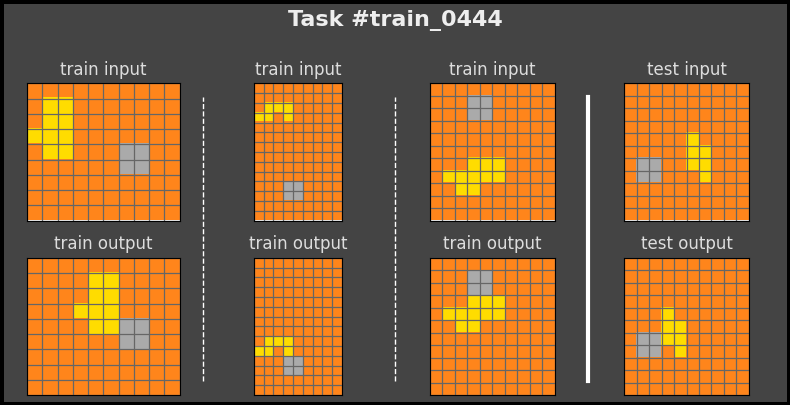

In [22]:
task_id, task = sample_arc_task(train_data, split=None)

test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [23]:
%%time 

expected_shape = get_grid_shape(test_output)

out = model.solve(
    task=task, 
    expected_rows=expected_shape[0],
    verbose=True
)

out

[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(11, 10)
[INFO] final_shape=(11, 10)
[INFO] Done!
CPU times: user 1.21 ms, sys: 927 μs, total: 2.14 ms
Wall time: 1.48 ms


[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 4, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 4, 4, 7, 7, 7],
 [7, 5, 5, 7, 7, 4, 4, 7, 7, 7],
 [7, 5, 5, 7, 7, 7, 4, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]]

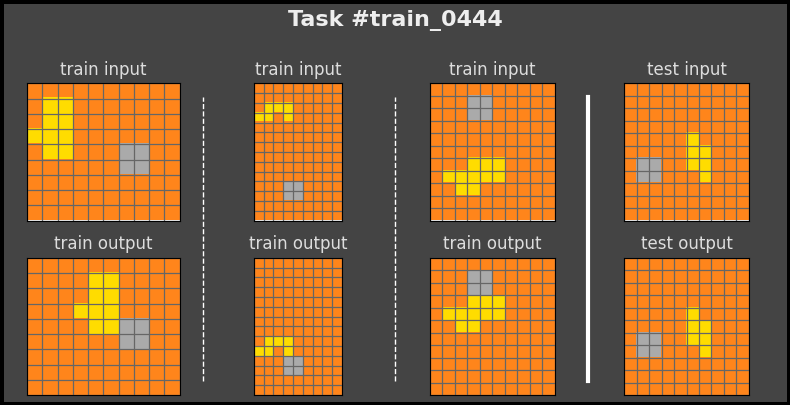

In [24]:
solution = {
    f"{task_id}": out
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Batch Solving

In [31]:
total_match = 0
total_pix_acc = 0
train_preds = []
N = 200

expected_shape = None

for _ in range(N):
    task_id, task = sample_arc_task(train_data, split=None)    
    logger.info(f"{task_id=}")
    
    test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

    if test_output is not None:
        expected_shape = get_grid_shape(test_output)
    
    pred = model.solve(
        task=task, 
        expected_rows=expected_shape[0] if expected_shape else None,
        verbose=True
    )

    solution = {
        f"{task_id}": pred
    }
    
    train_preds.append(solution)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()
        
    total_match+=match
    total_pix_acc+=pix_acc

    print()

avg_acc = total_match/N
avg_pix_acc = total_pix_acc/N

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

[INFO] task_id='train_0719'
[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(8, 8)
[INFO] final_shape=(8, 8)
[INFO] Done!

[INFO] task_id='train_0240'
[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(15, 15)
[INFO] final_shape=(15, 15)
[INFO] Done!

[INFO] task_id='train_0689'
[INFO] Test input shape matches a training input shape exactly
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(3, 9)
[INFO] final_shape=(3, 9)
[INFO] Done!

[INFO] task_id='train_0719'
[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(8, 8)
[INFO] final_shape=(8, 8)
[INFO] Done!

[INFO] task_id='train_0343'
[INFO] All outputs have same shape
[INFO] Fallback - Copy input solver...
[INFO] Adjust

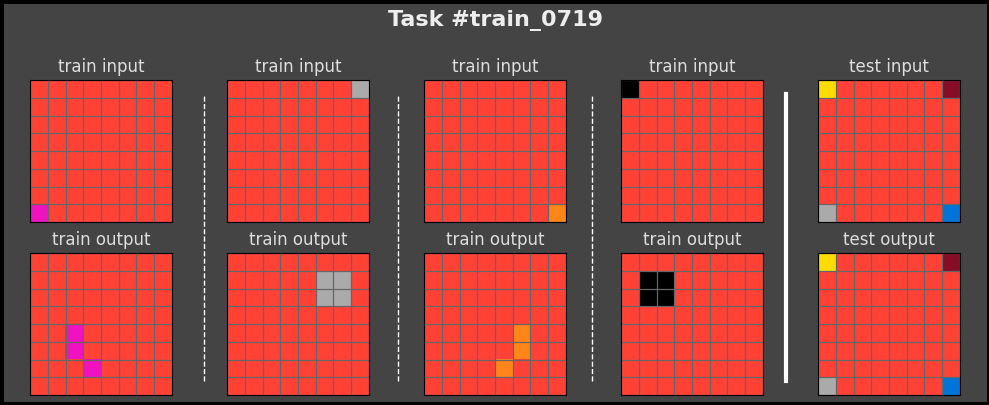

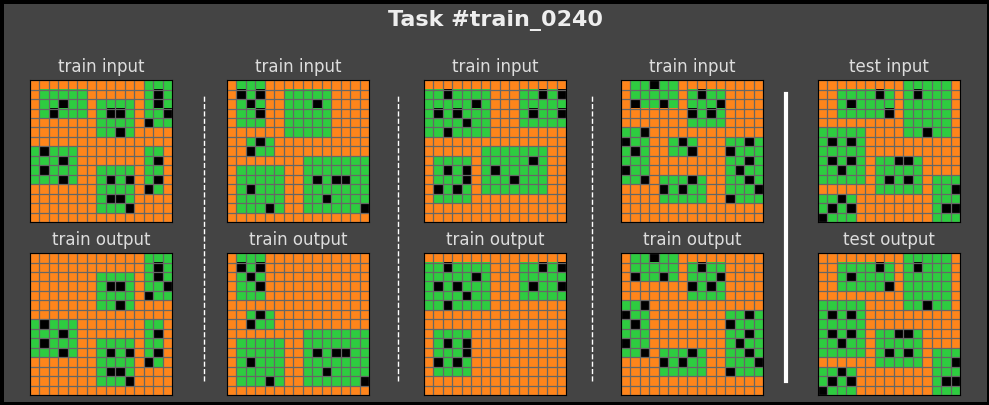

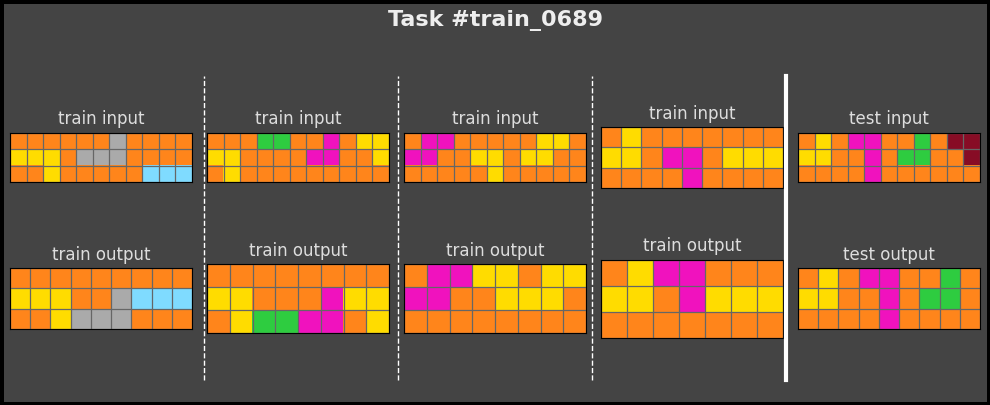

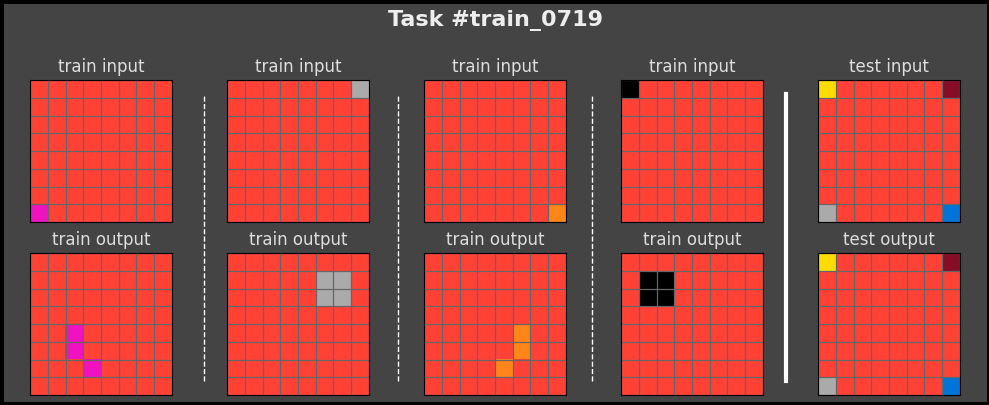

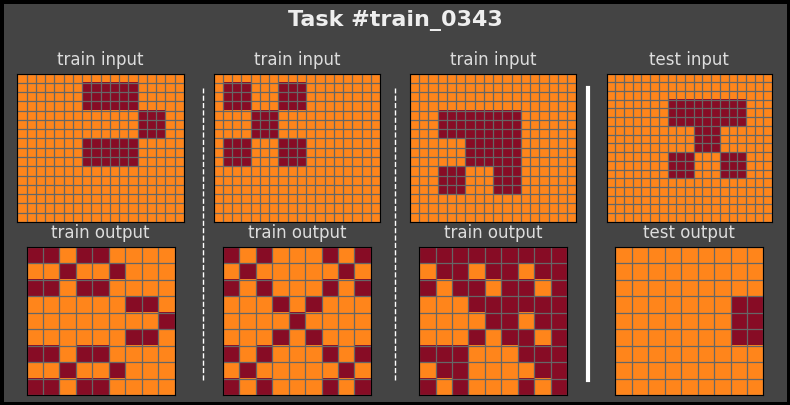

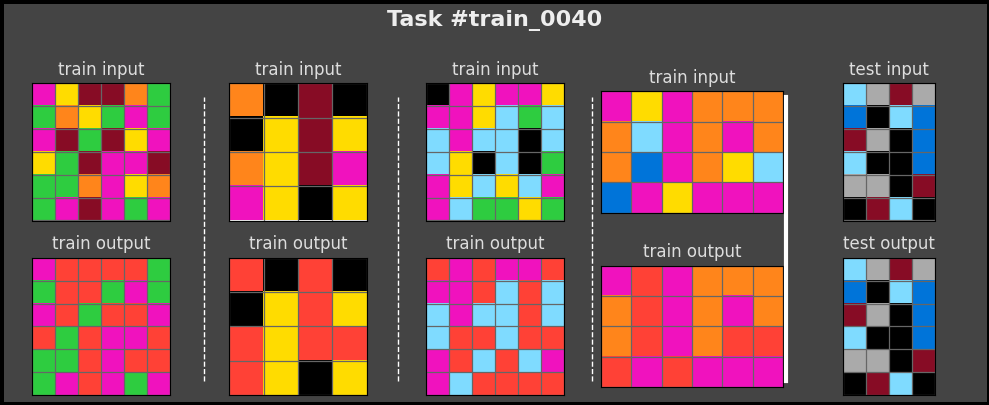

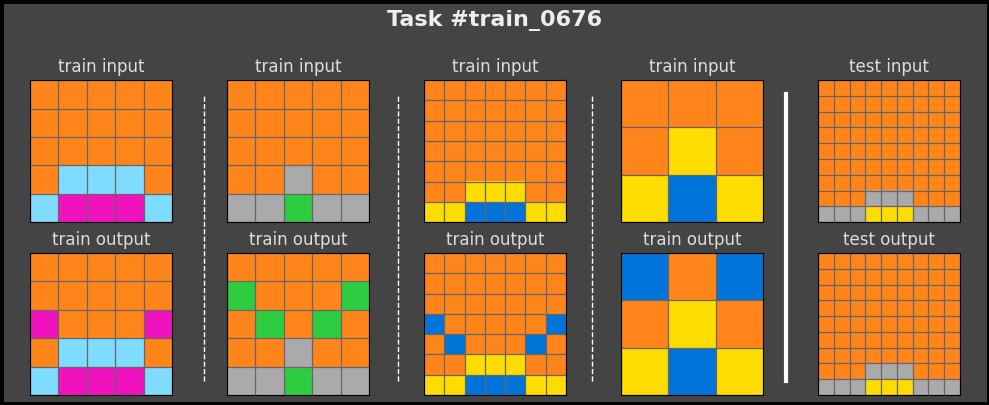

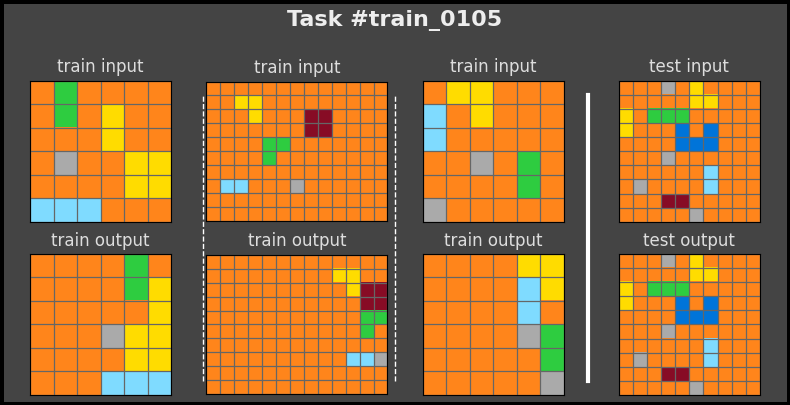

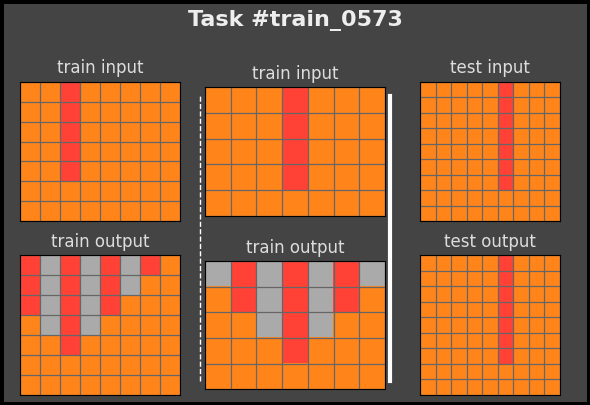

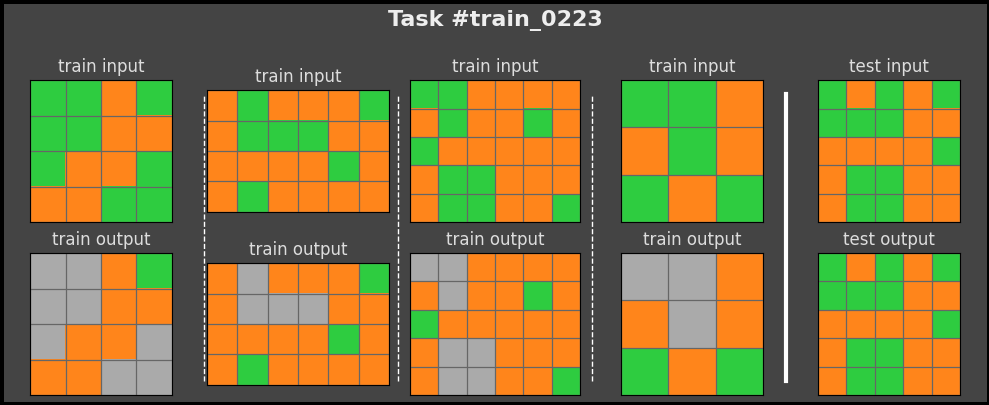

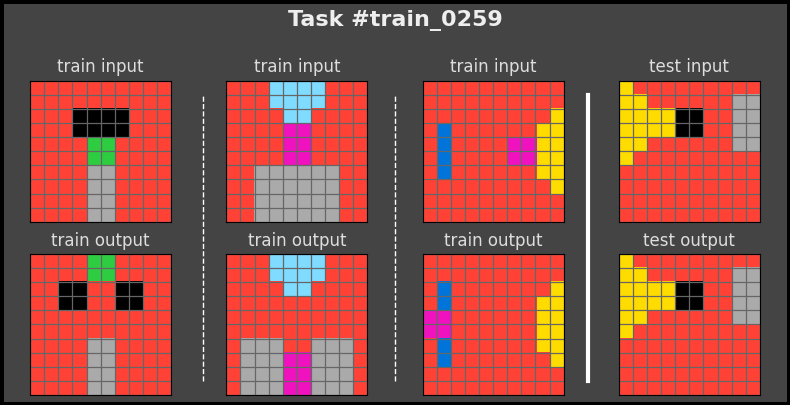

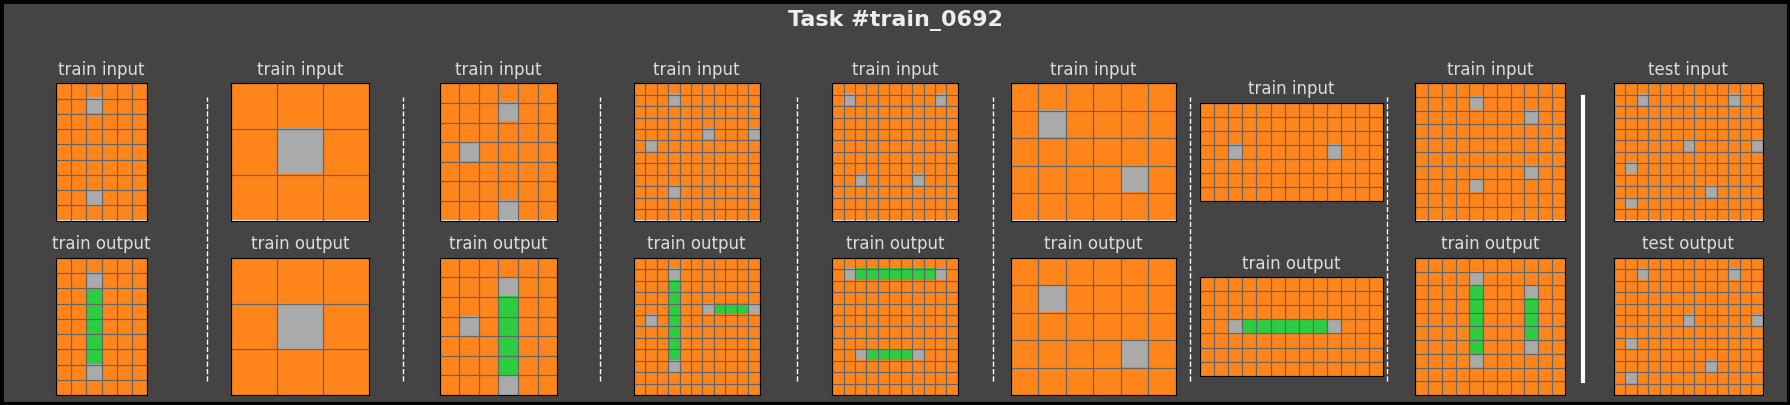

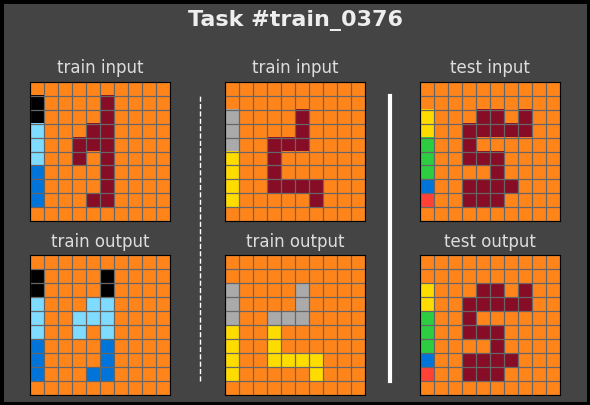

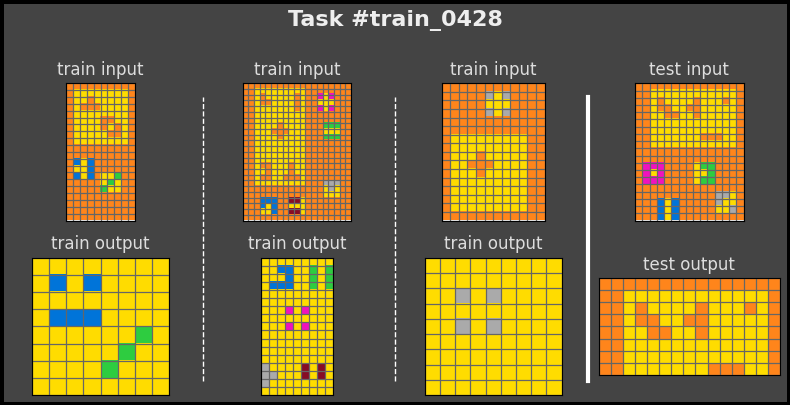

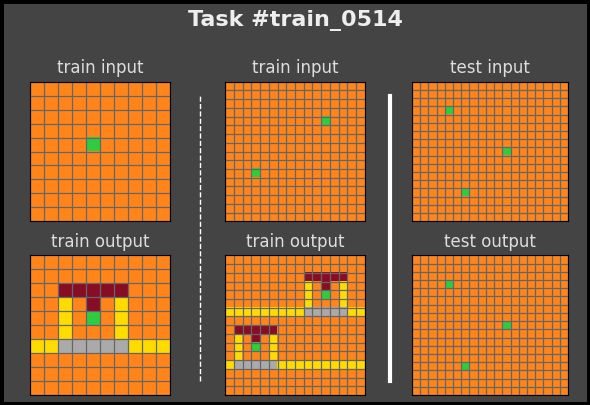

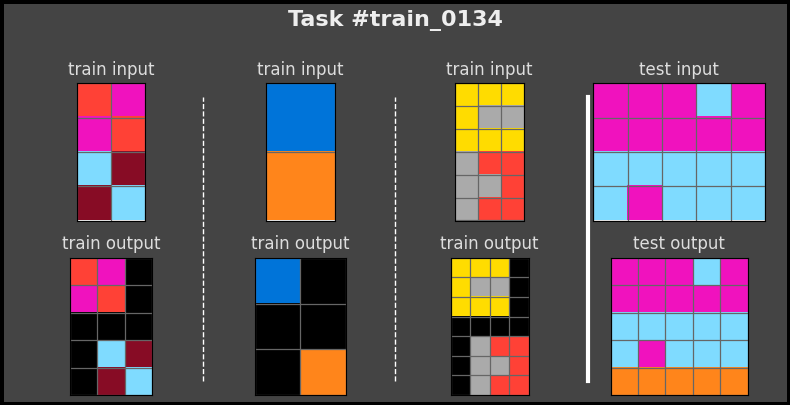

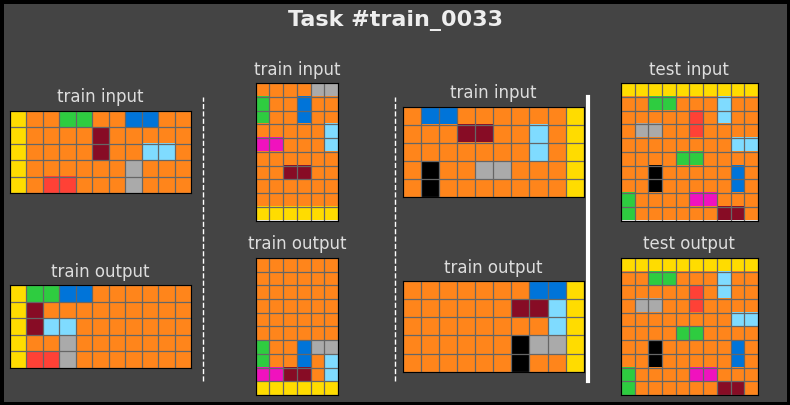

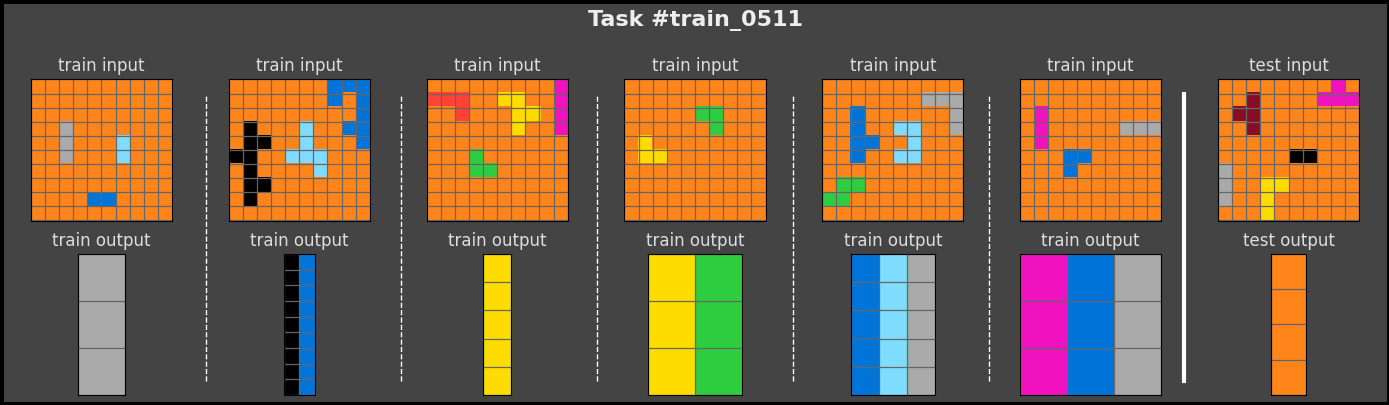

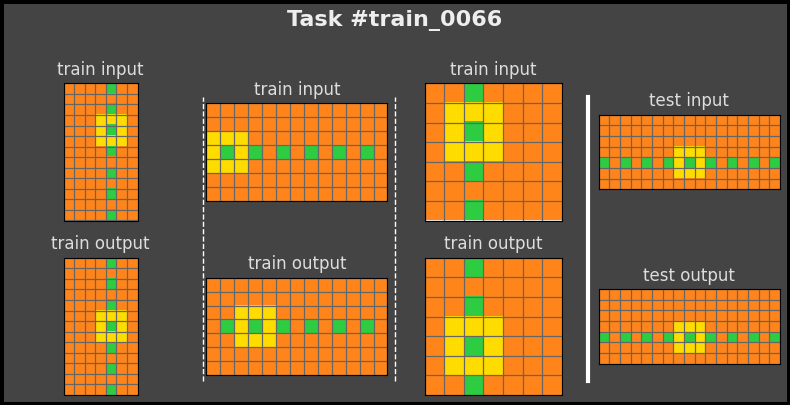

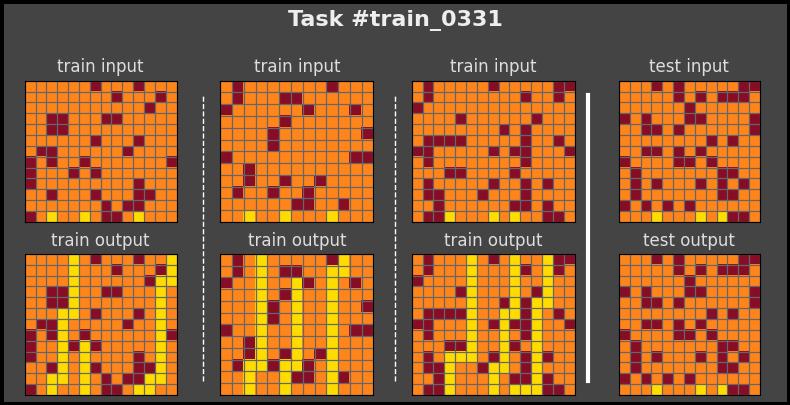

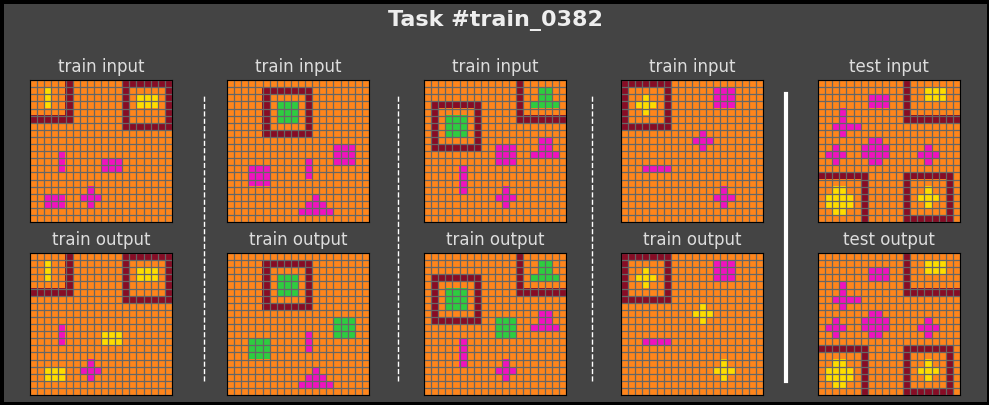

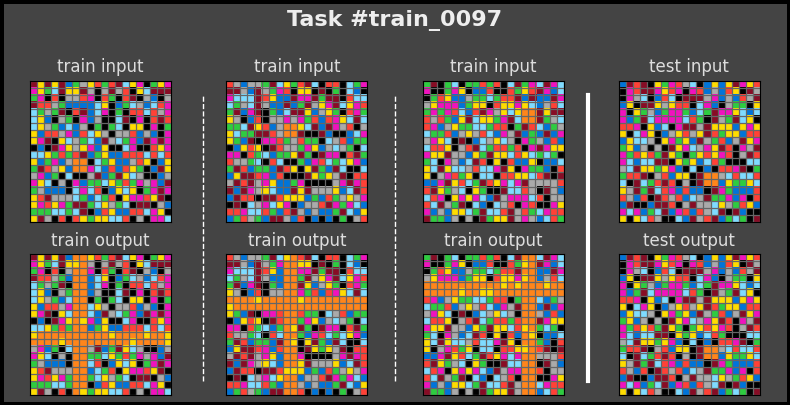

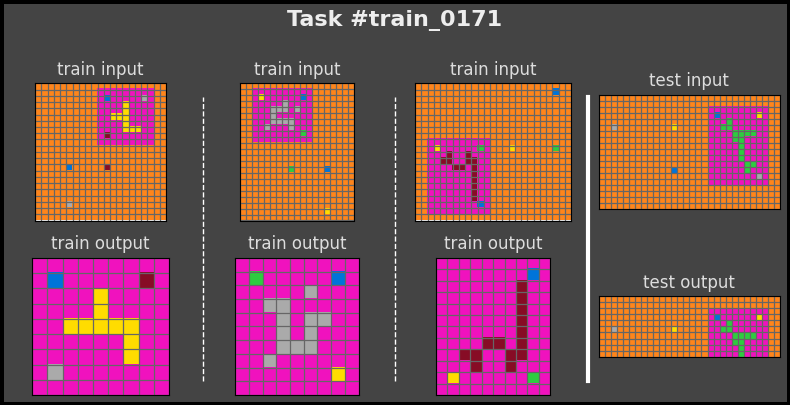

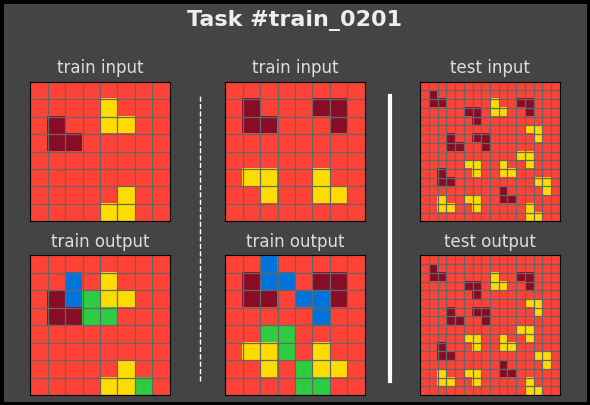

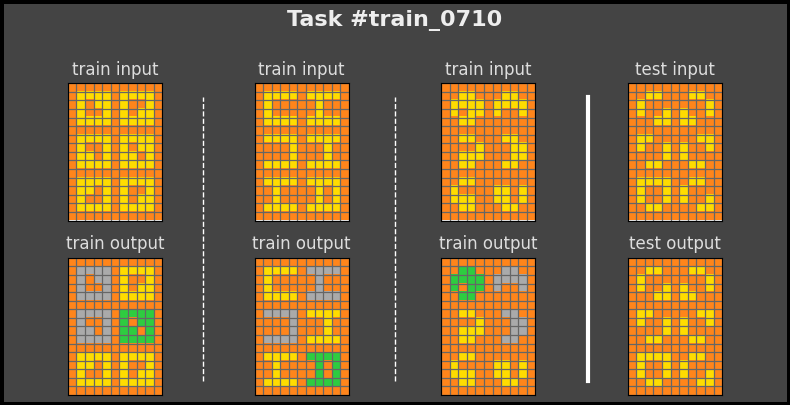

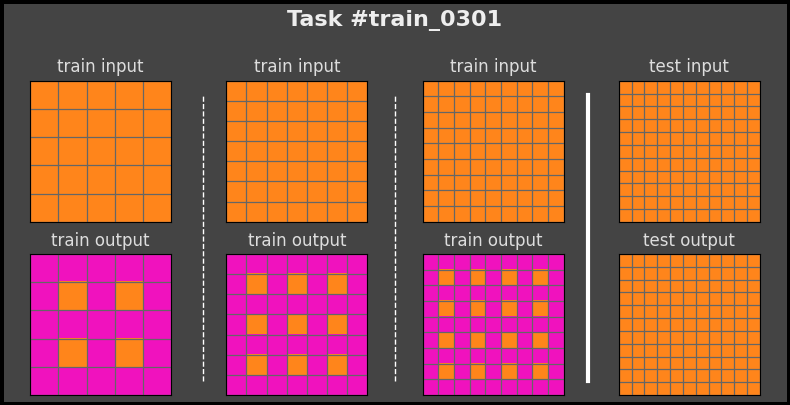

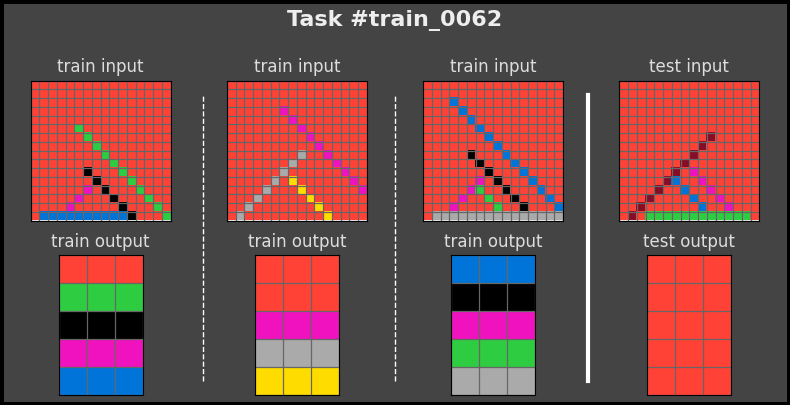

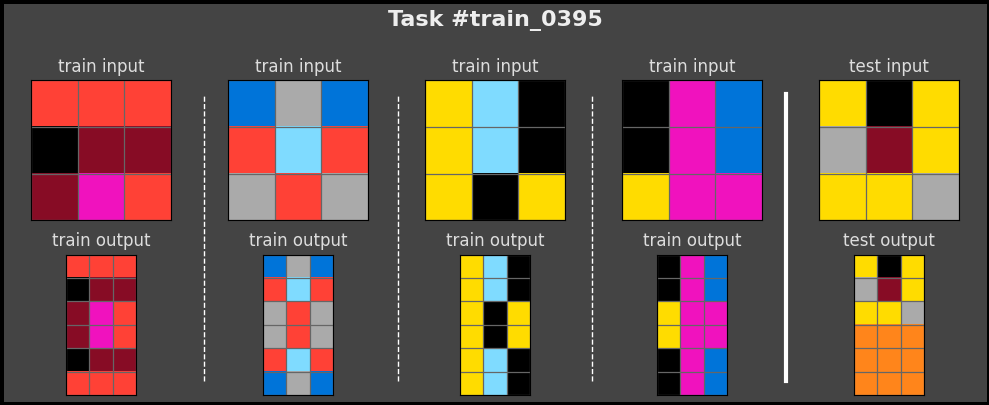

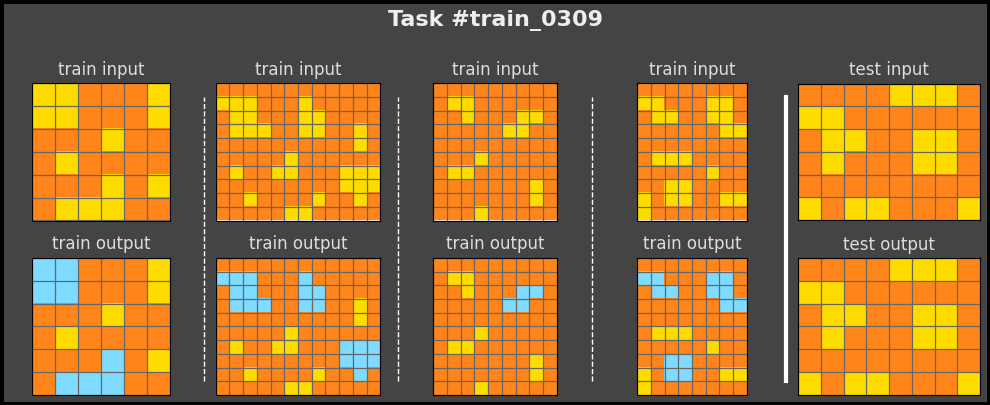

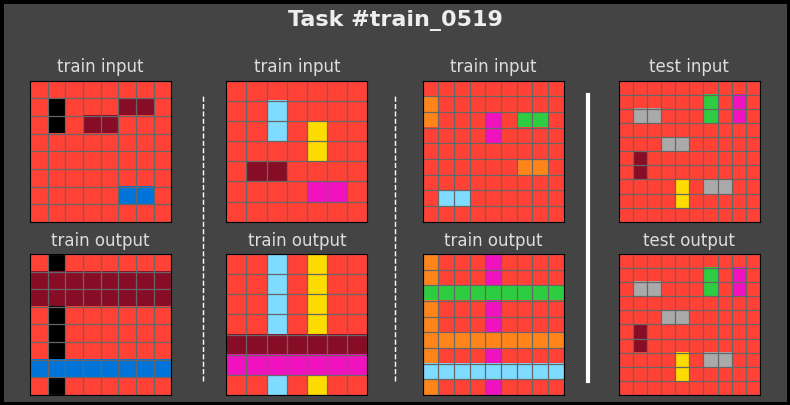

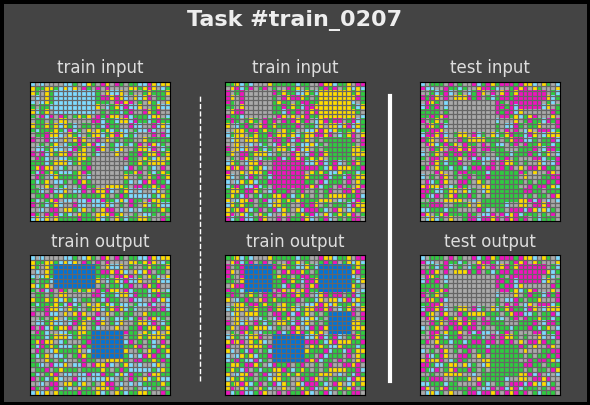

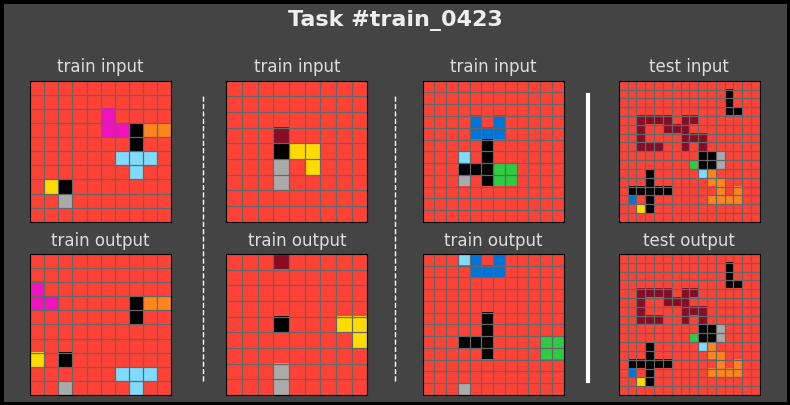

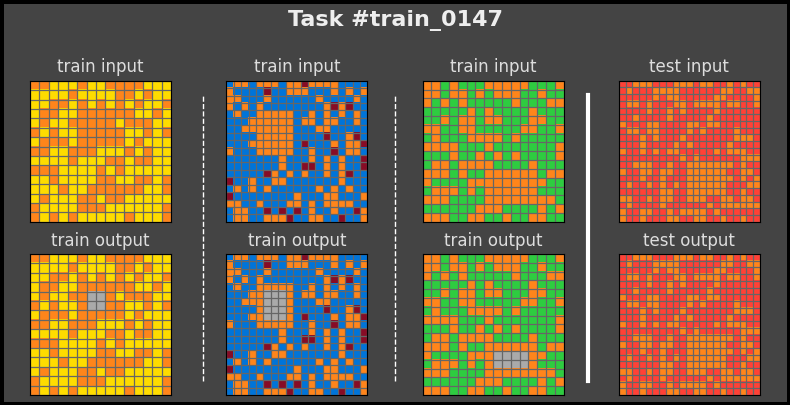

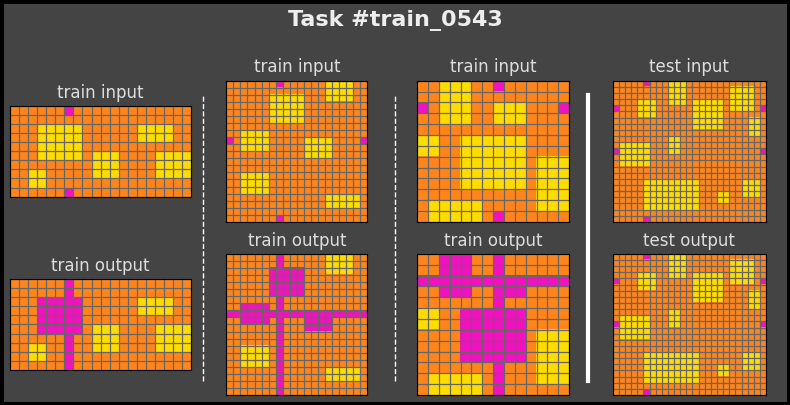

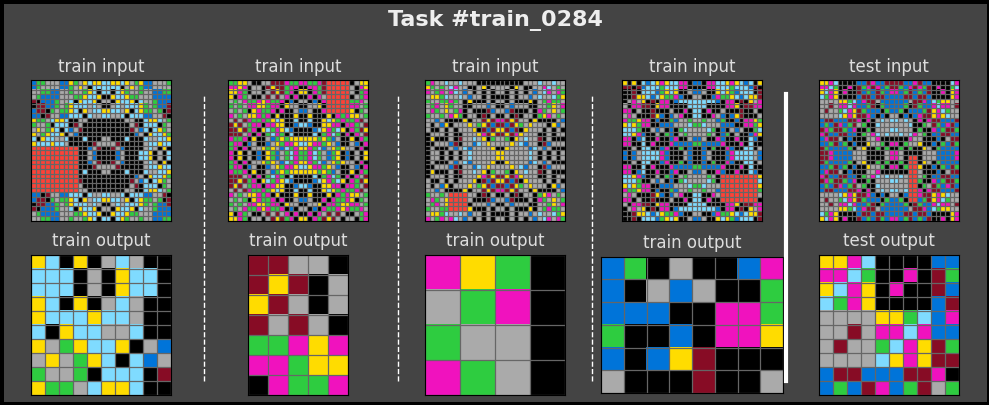

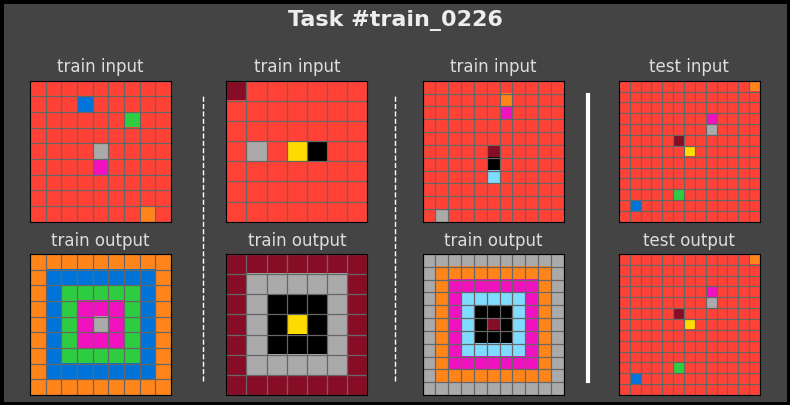

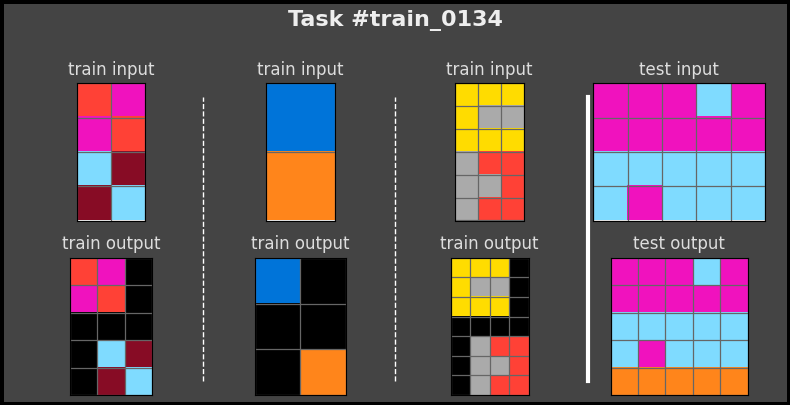

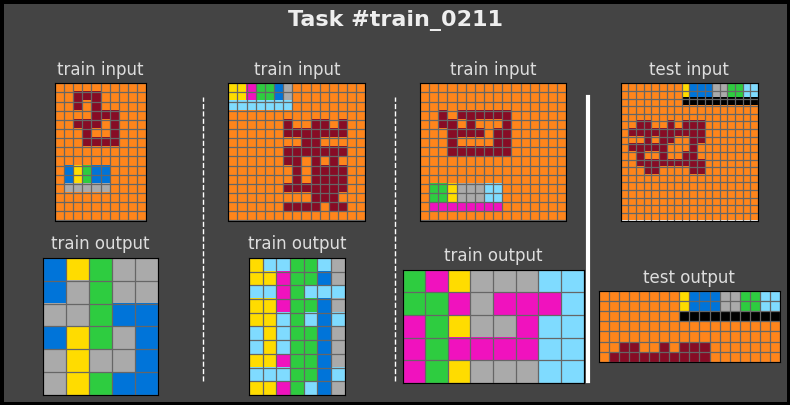

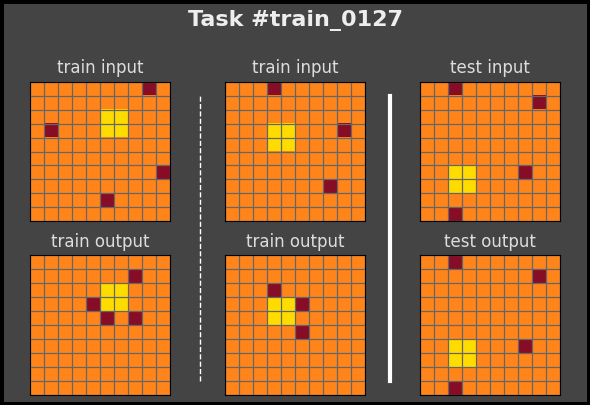

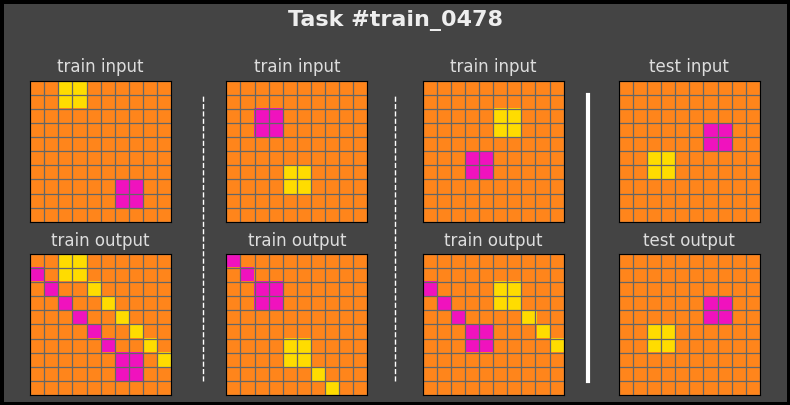

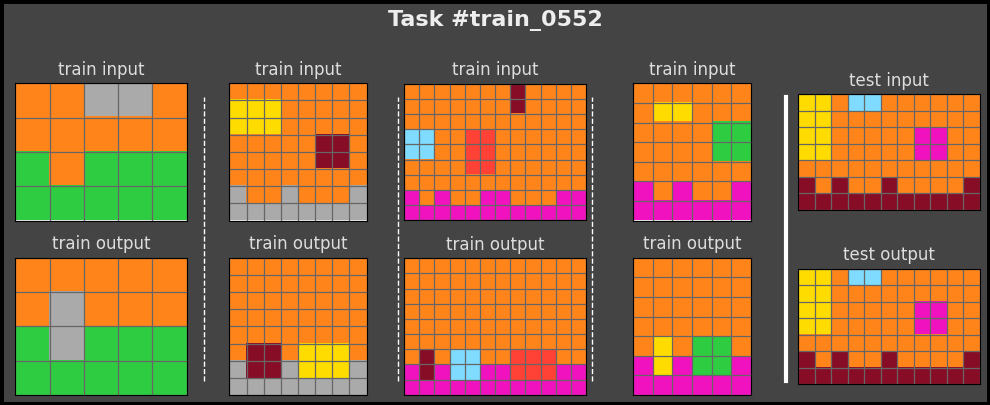

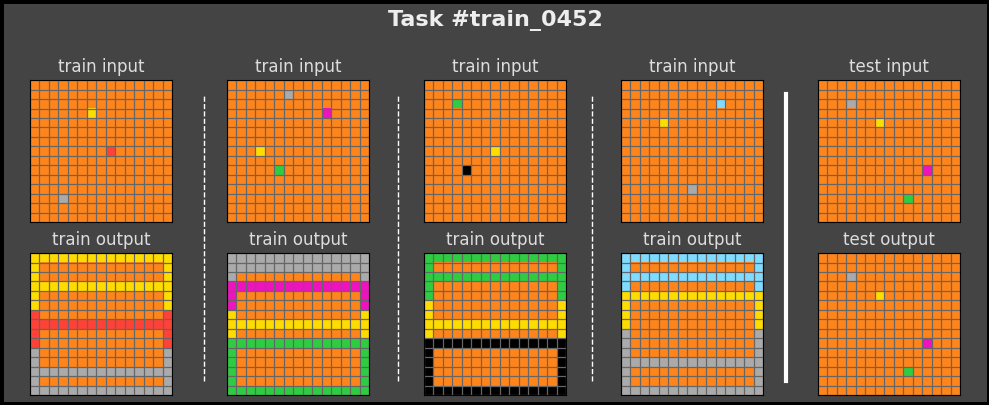

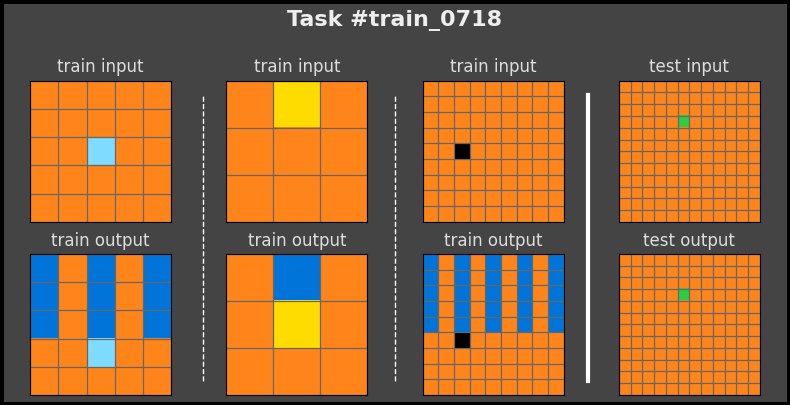

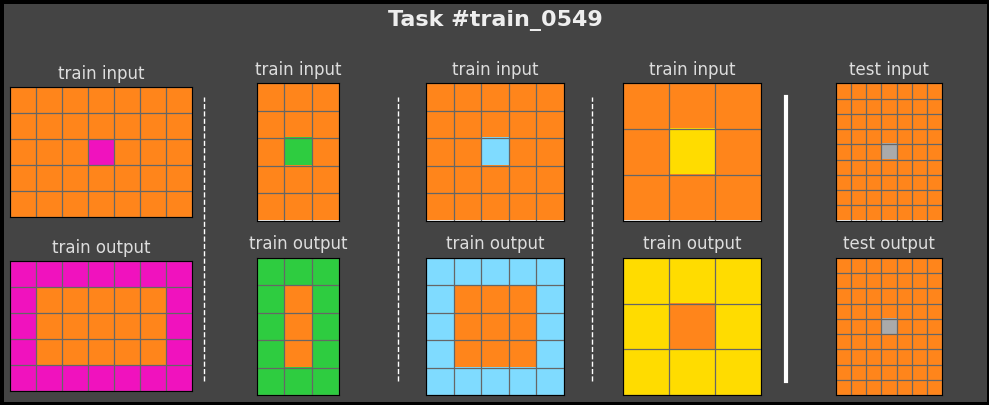

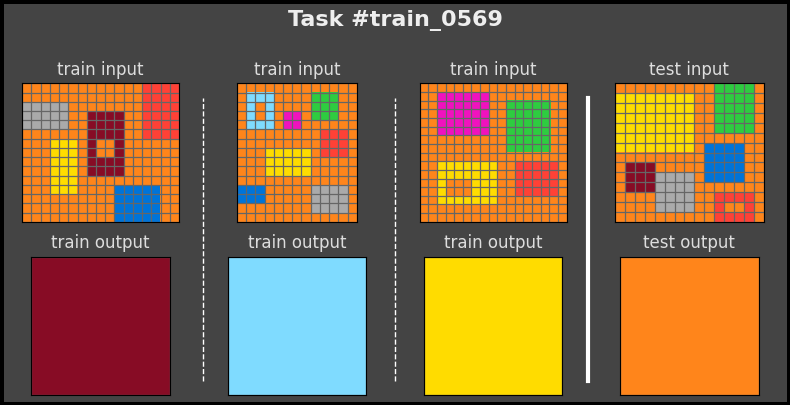

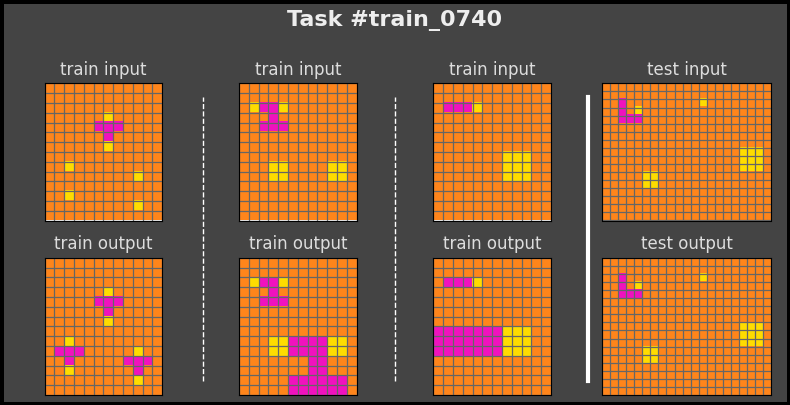

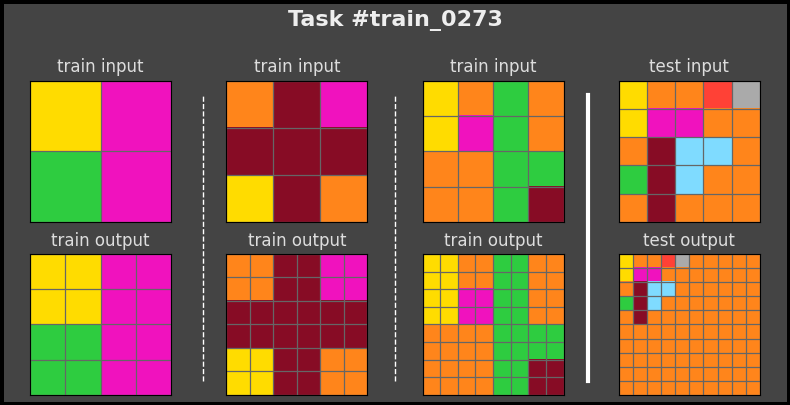

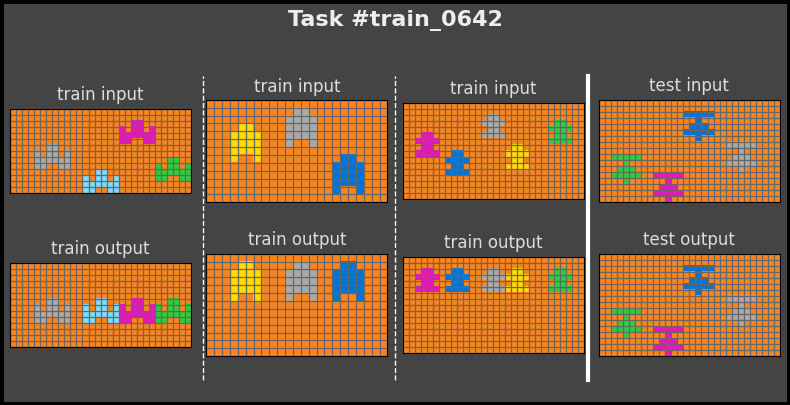

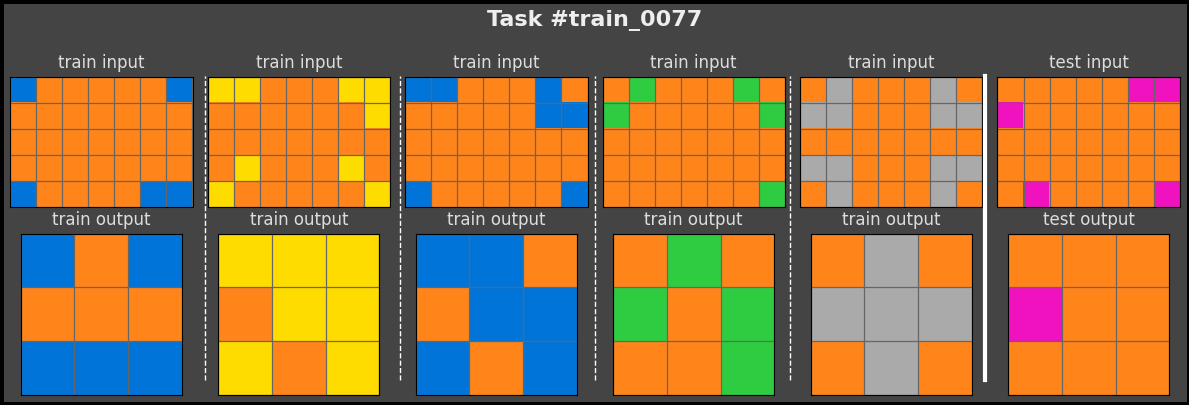

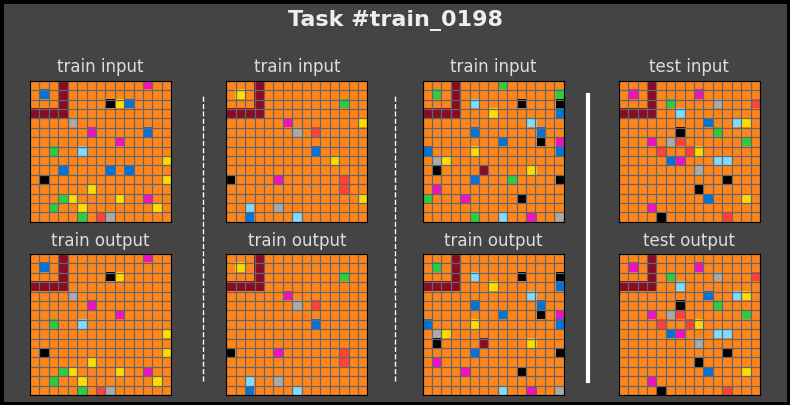

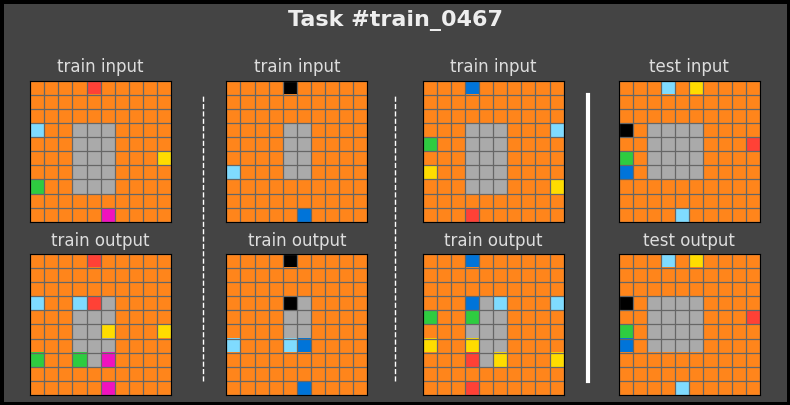

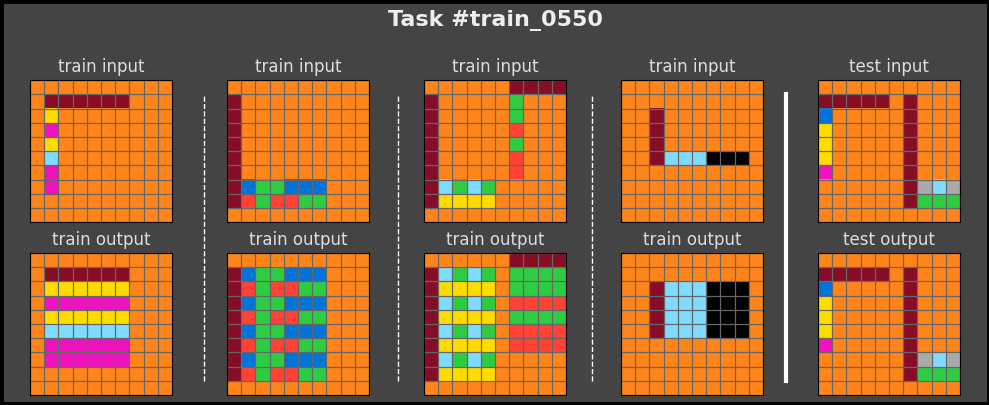

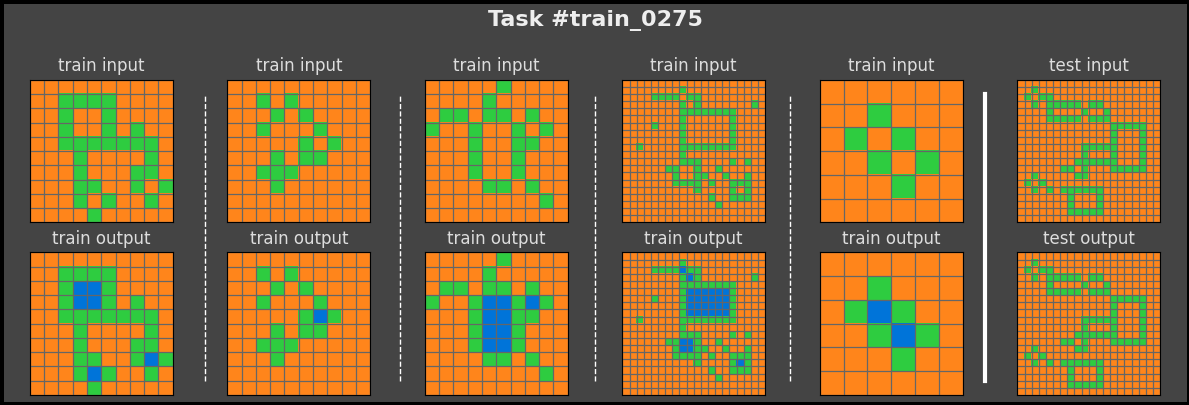

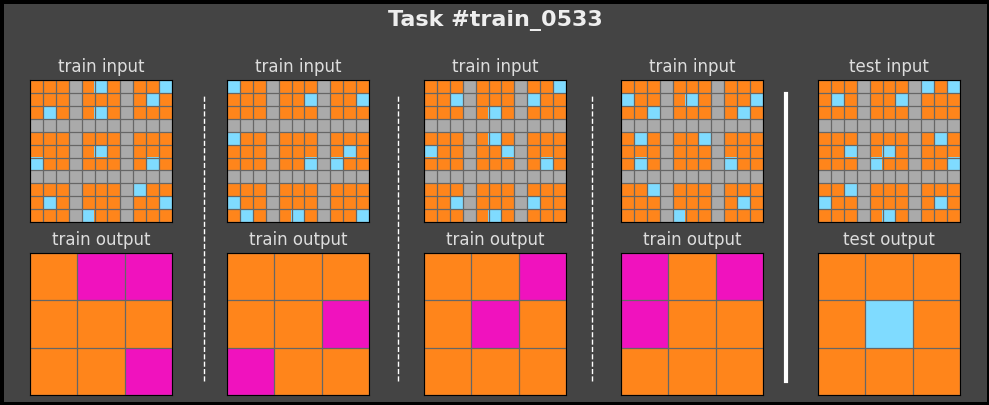

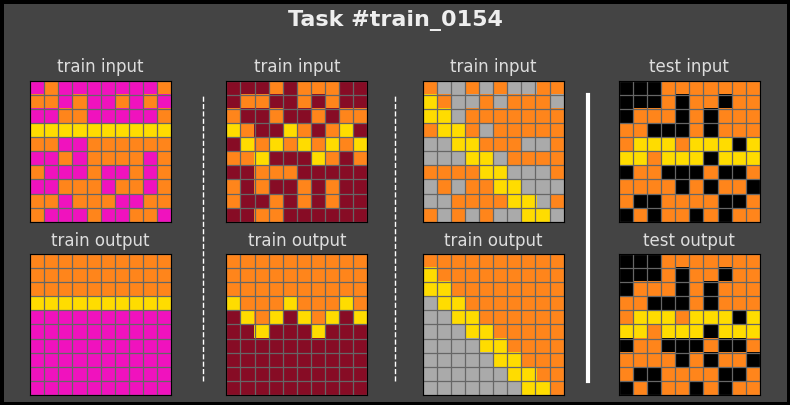

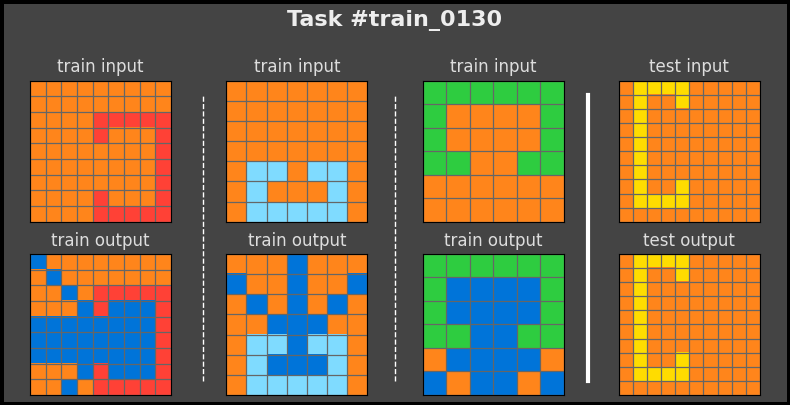

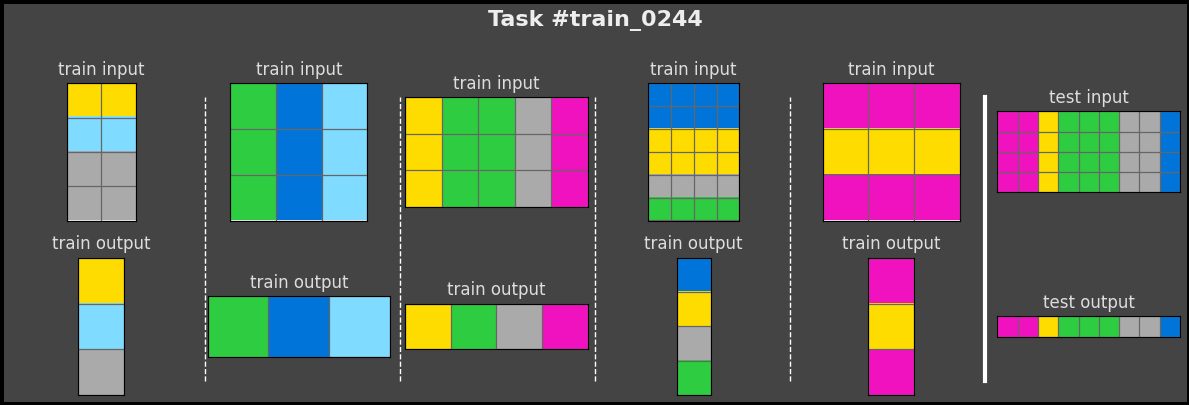

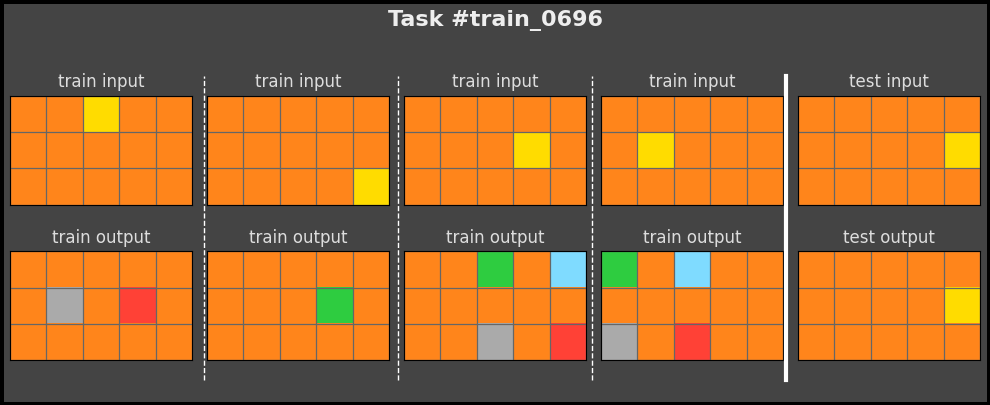

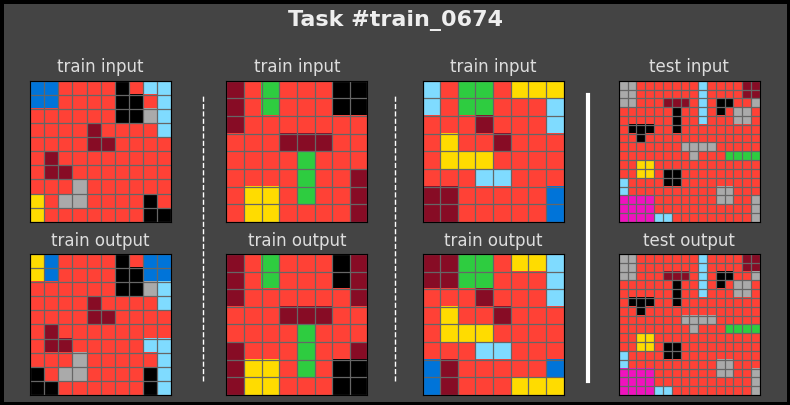

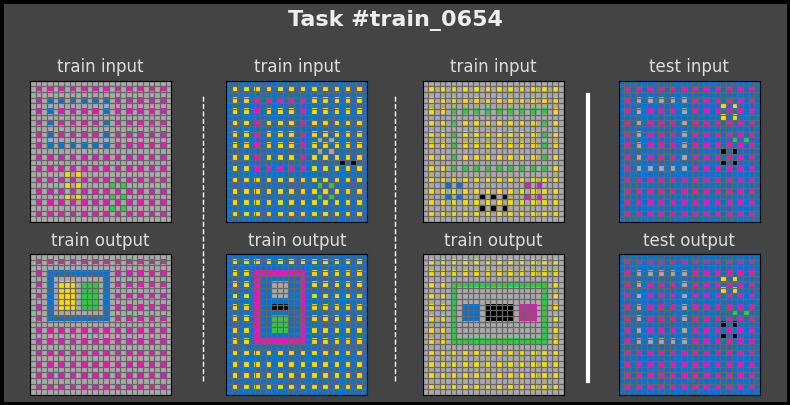

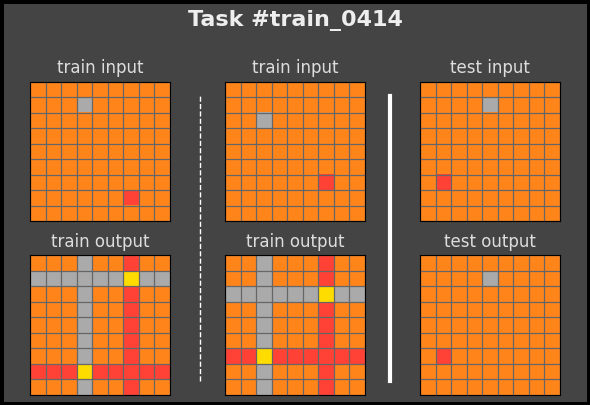

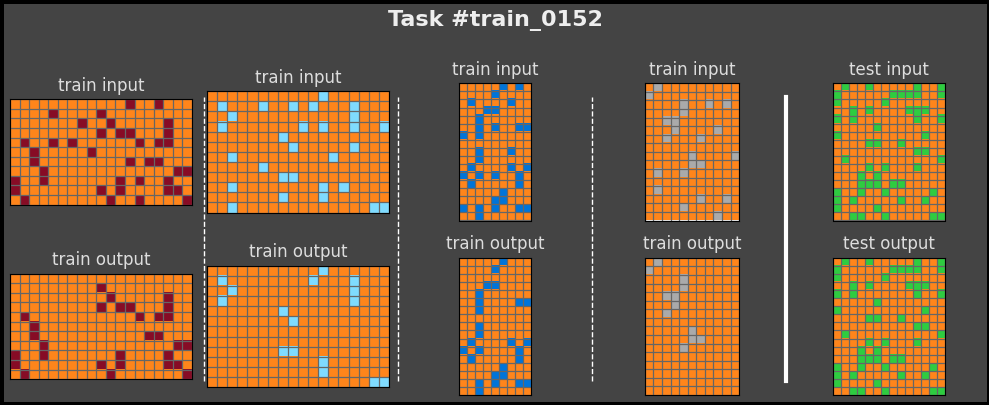

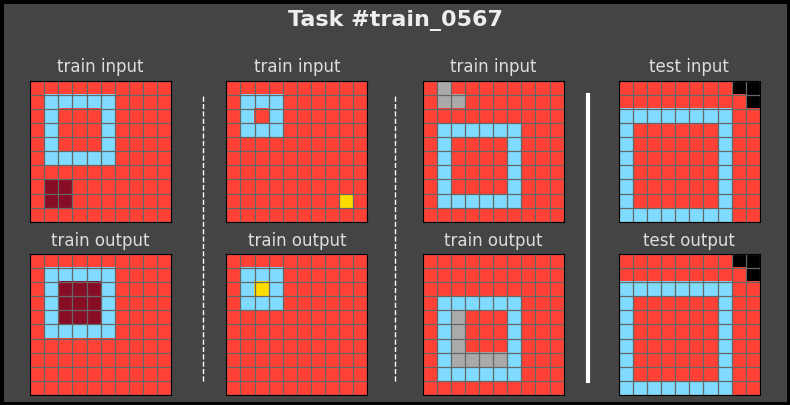

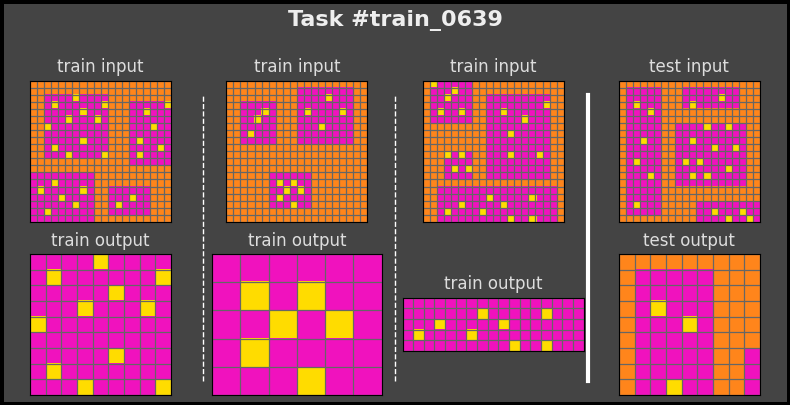

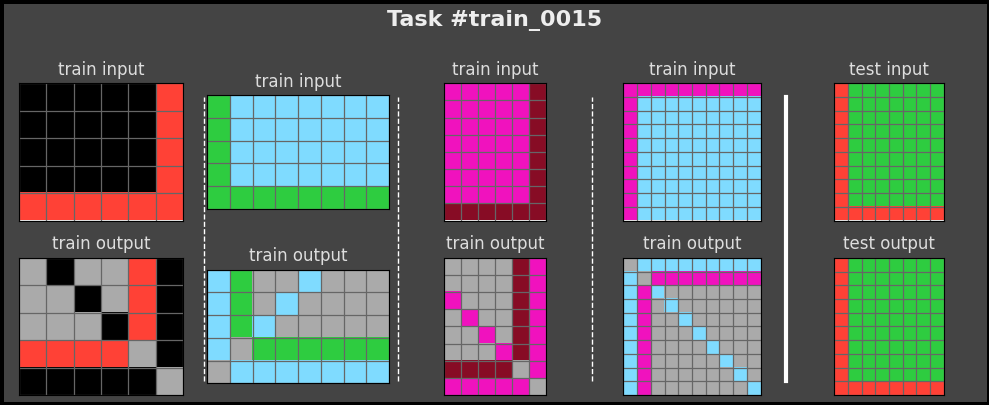

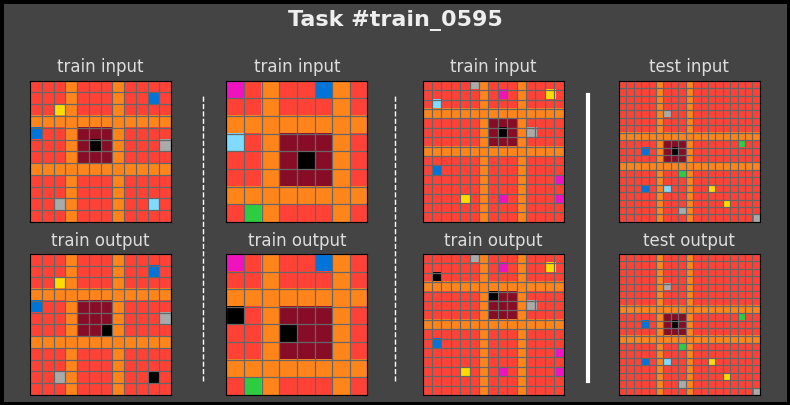

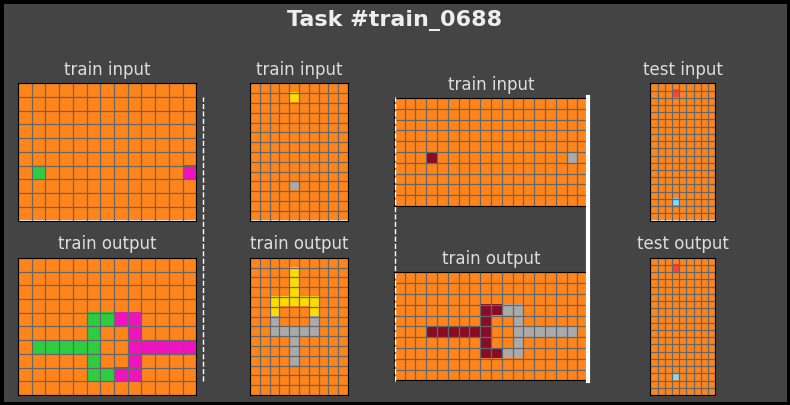

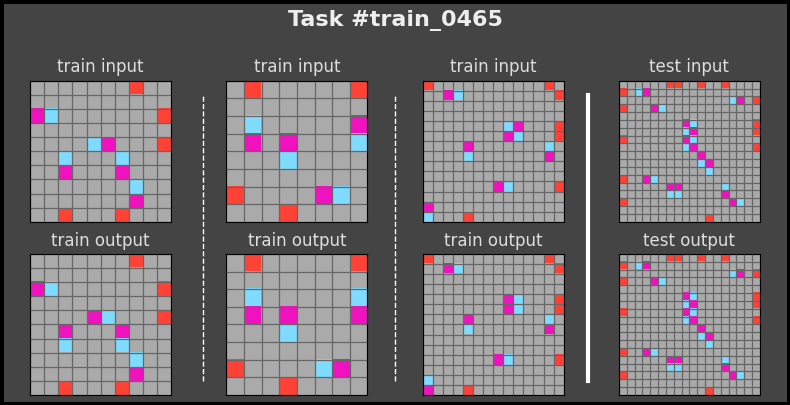

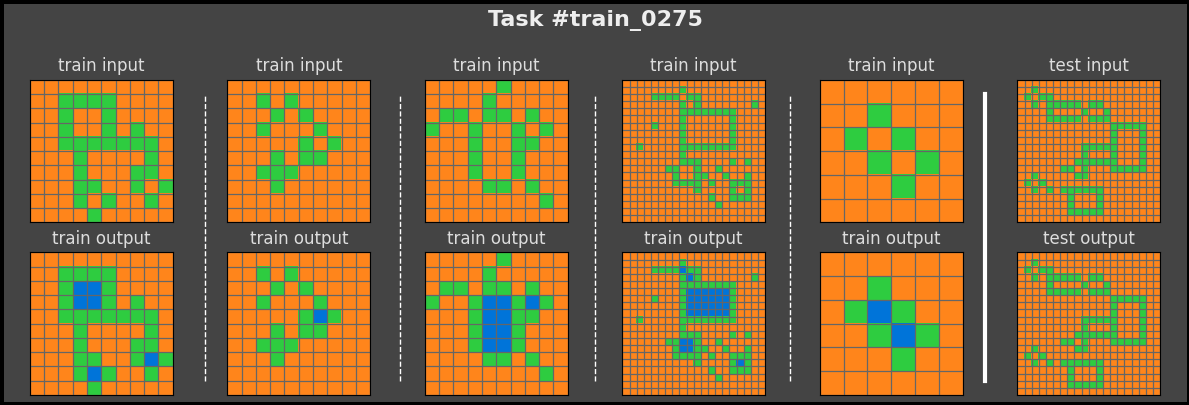

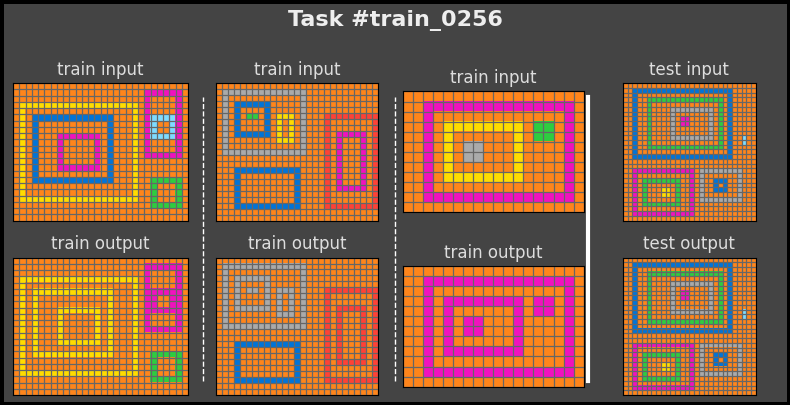

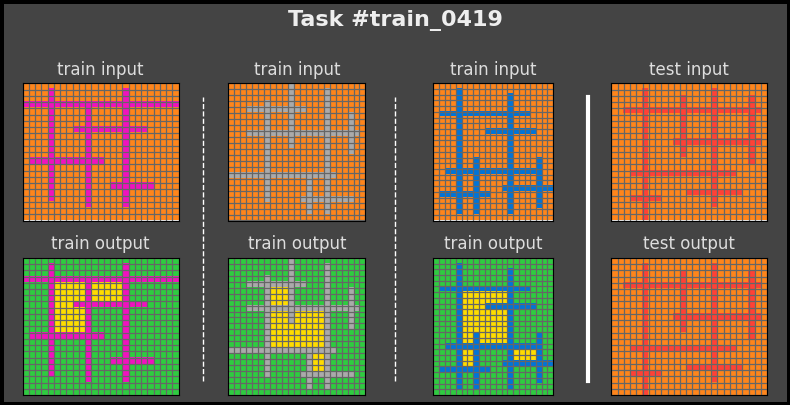

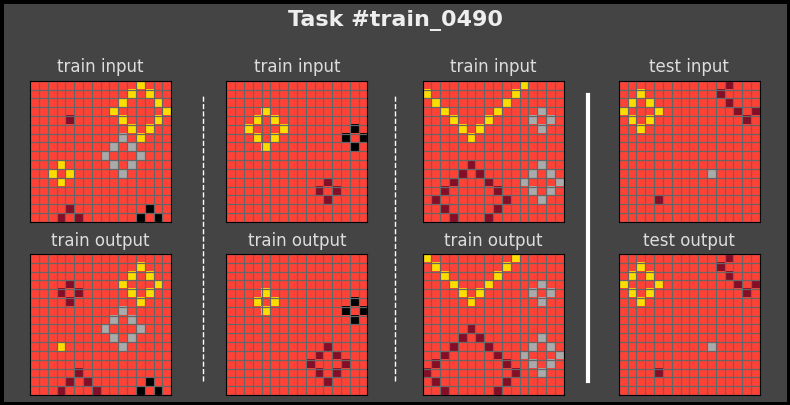

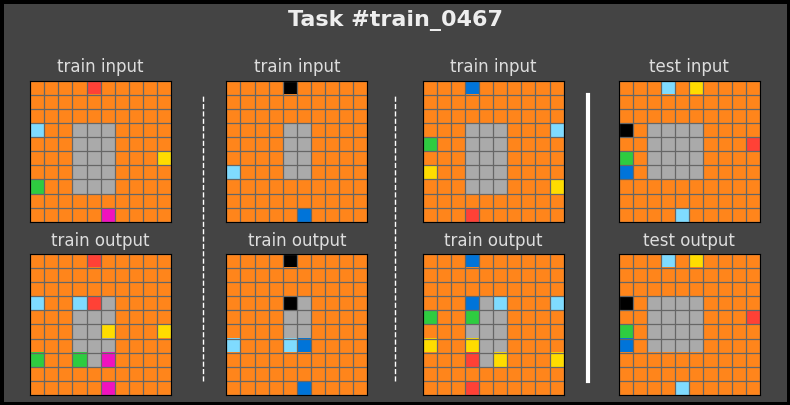

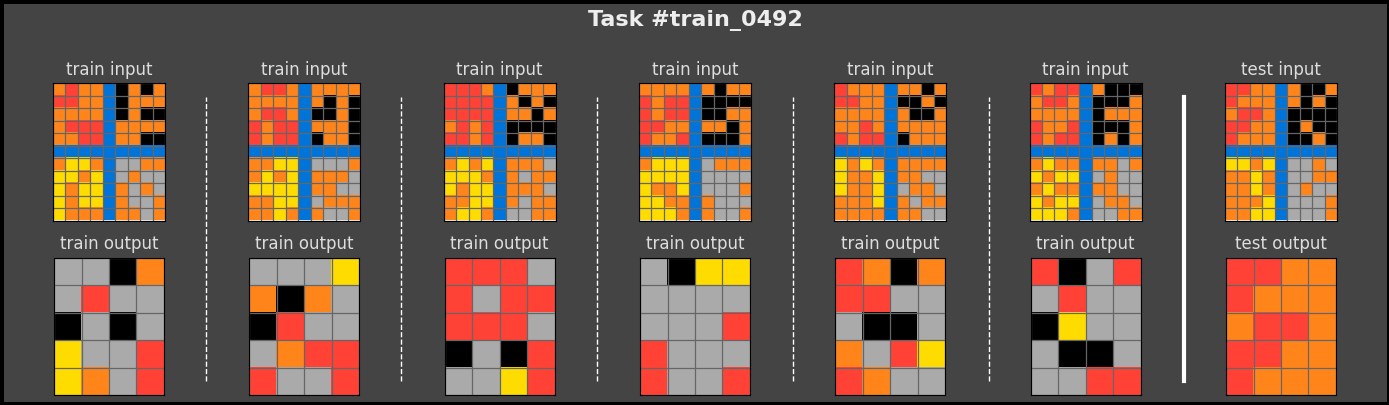

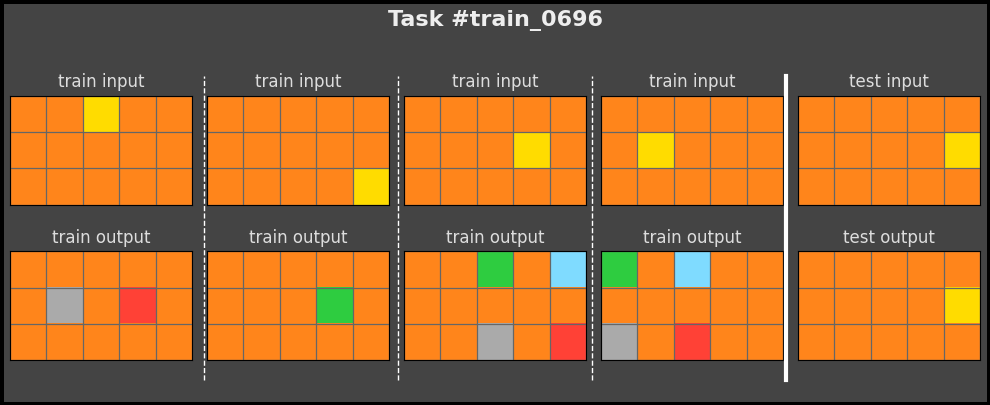

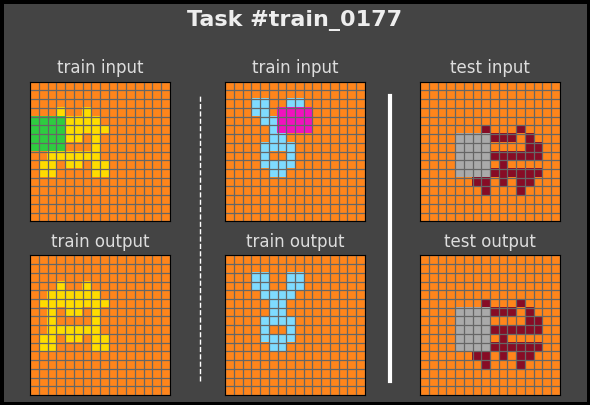

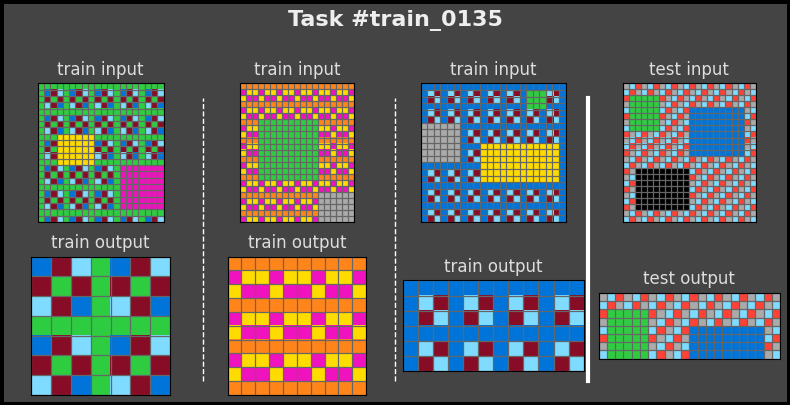

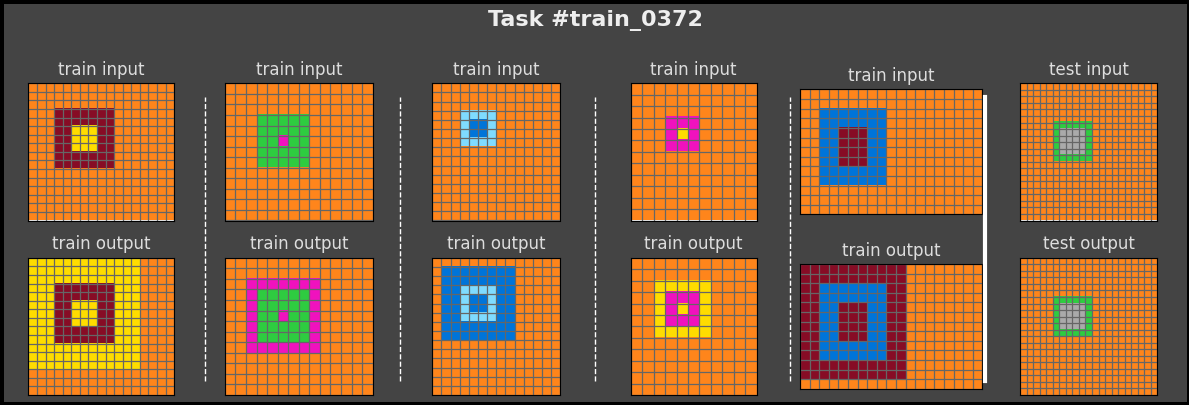

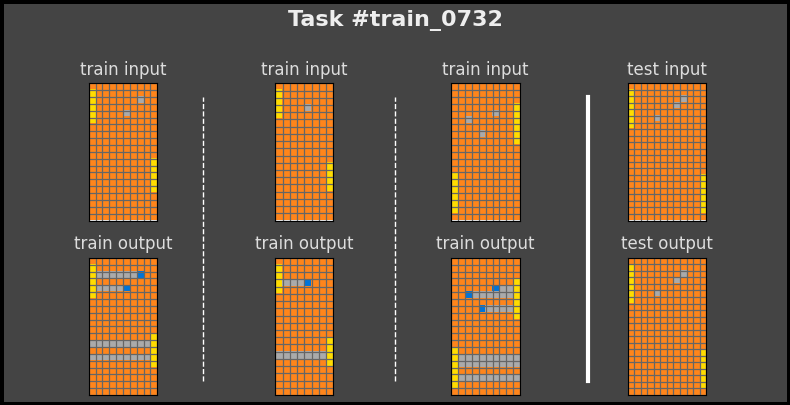

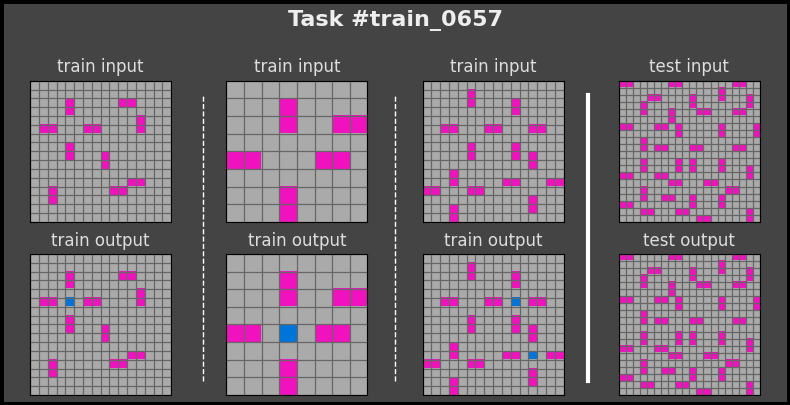

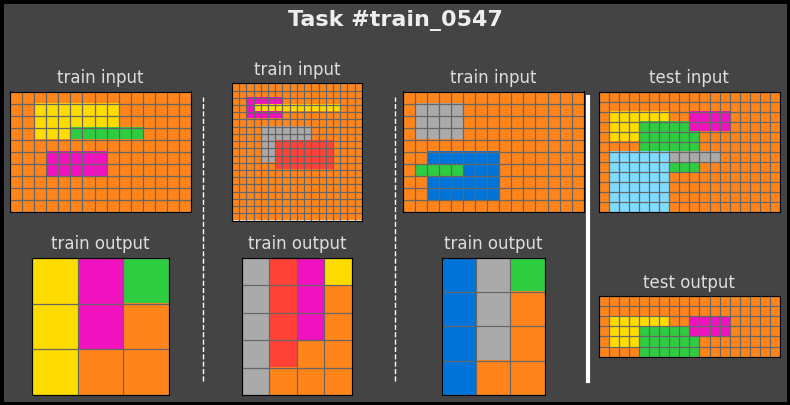

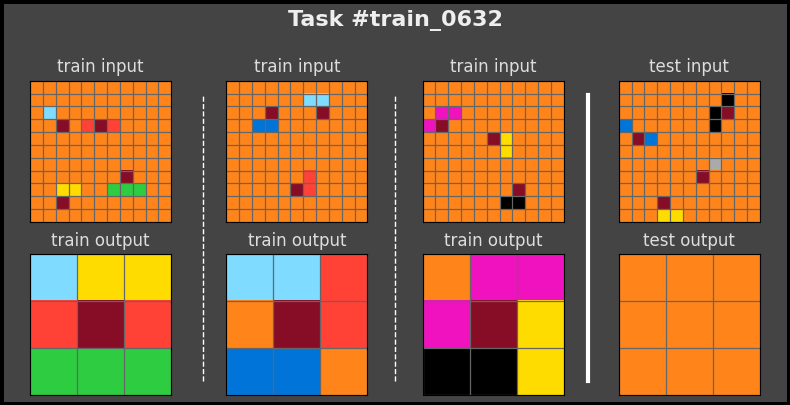

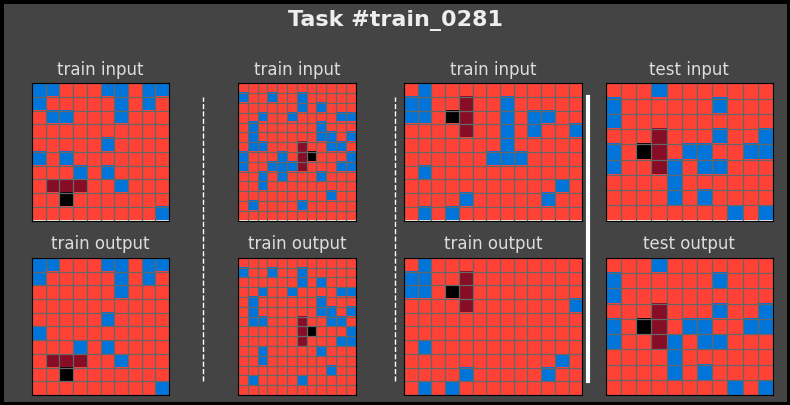

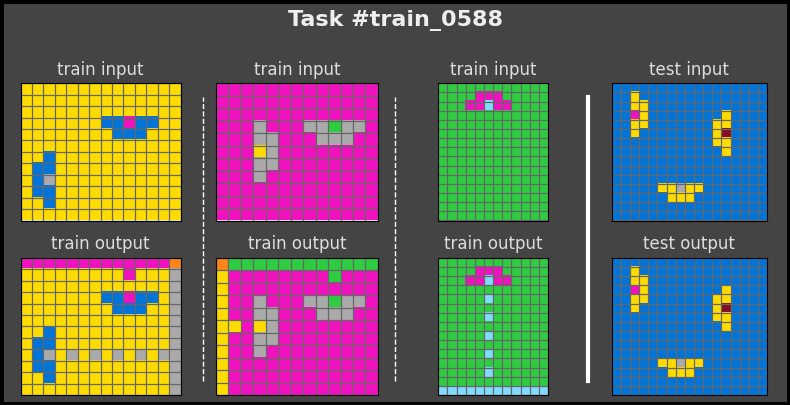

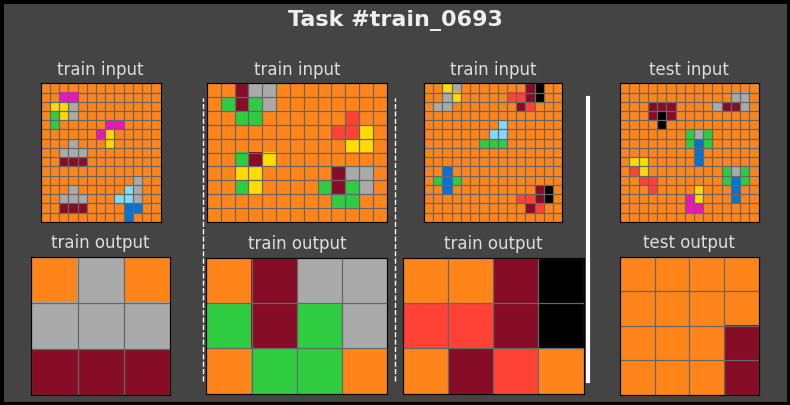

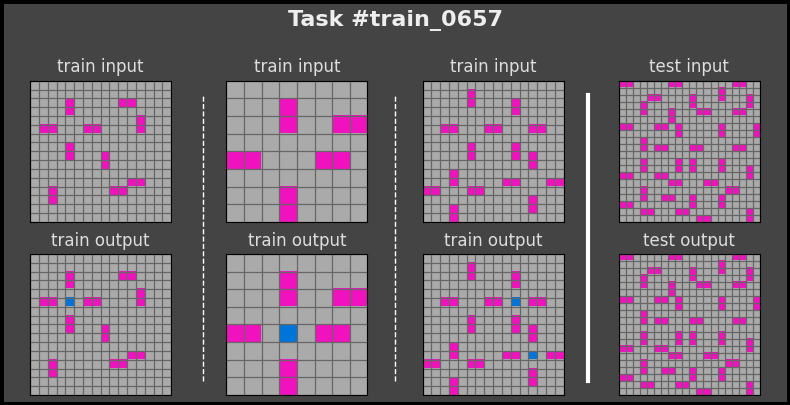

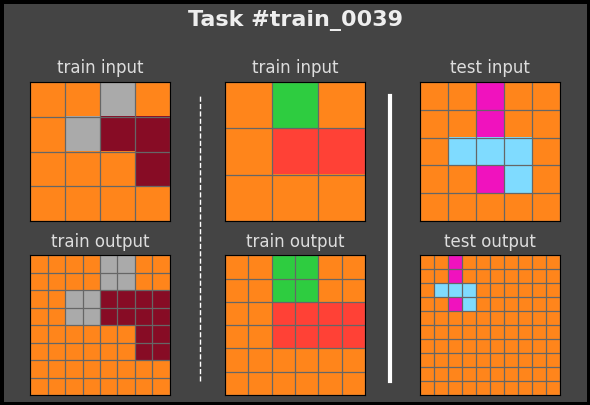

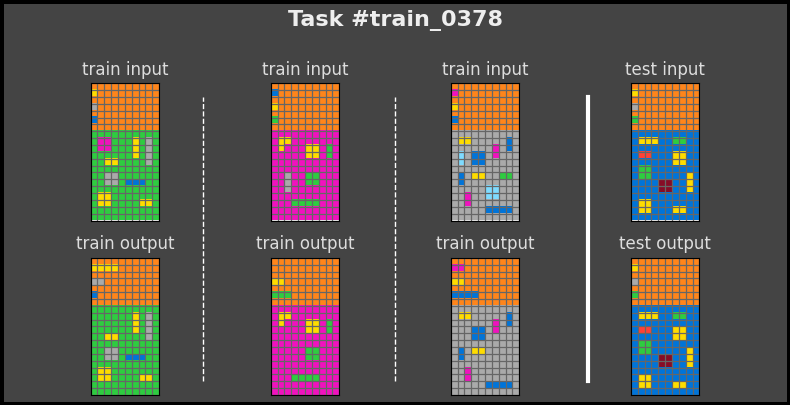

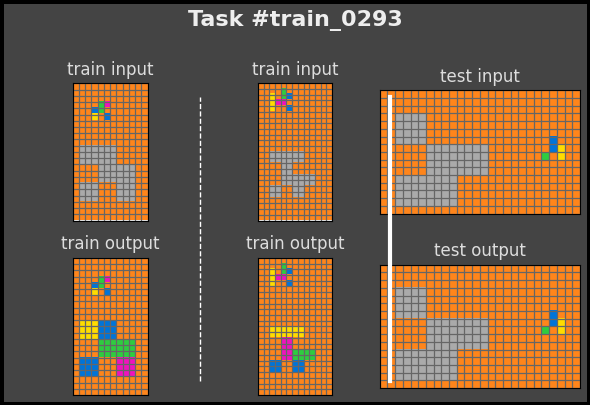

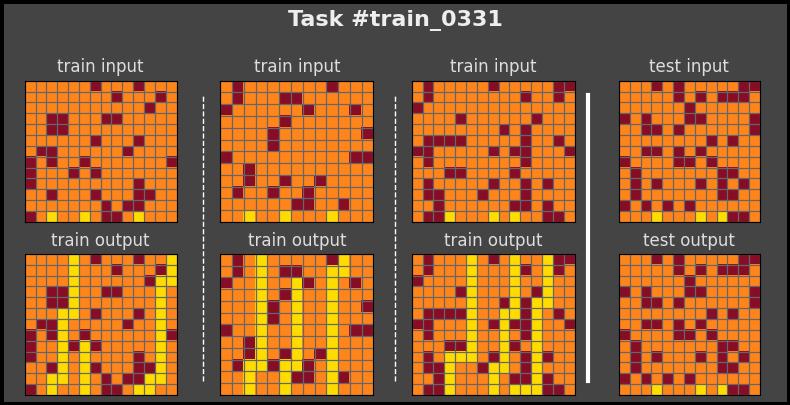

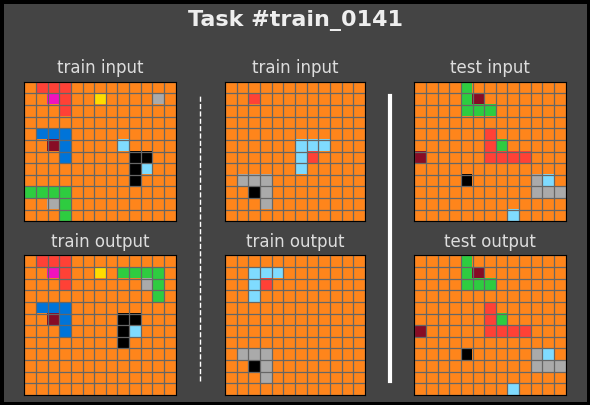

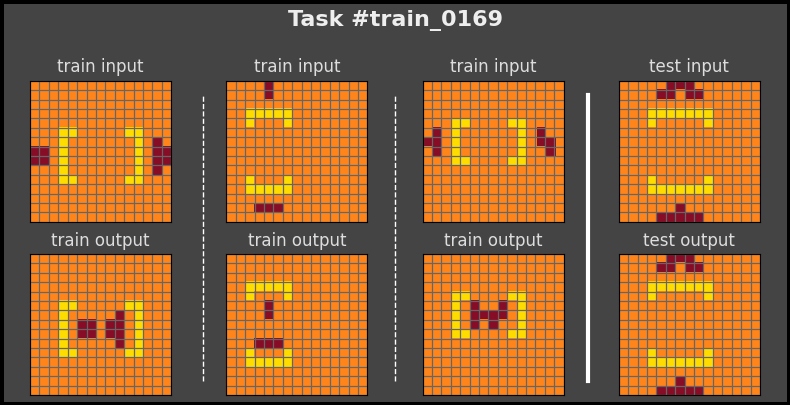

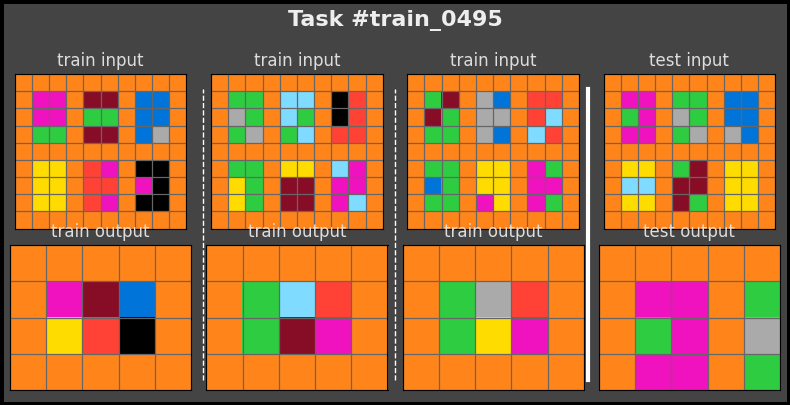

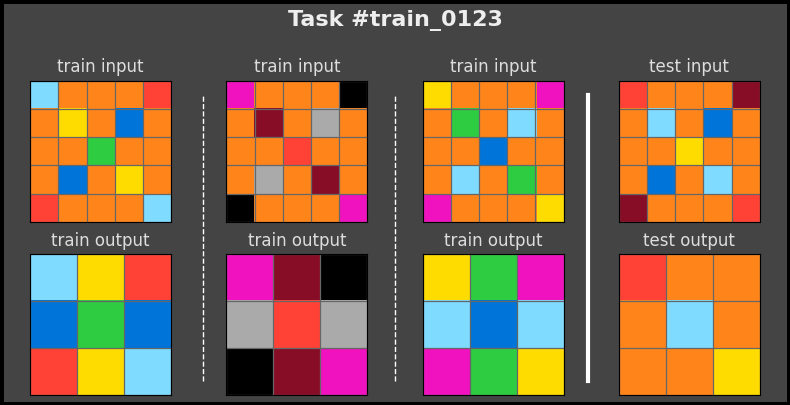

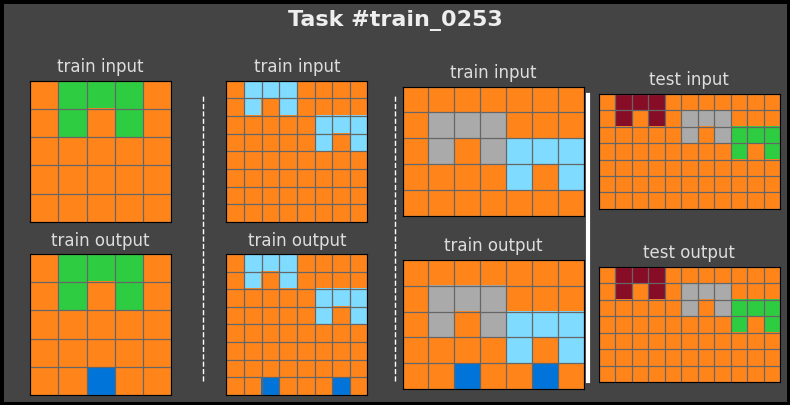

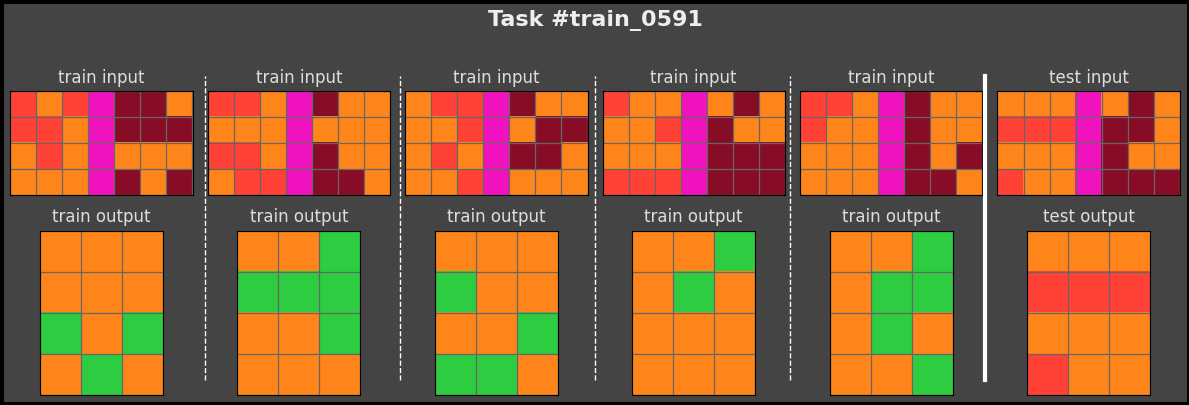

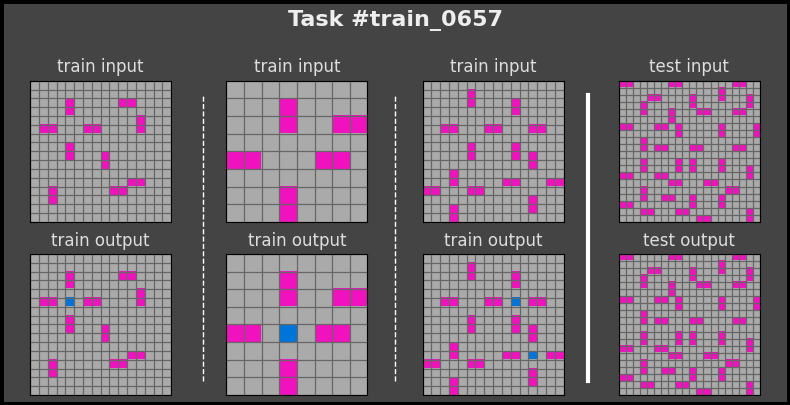

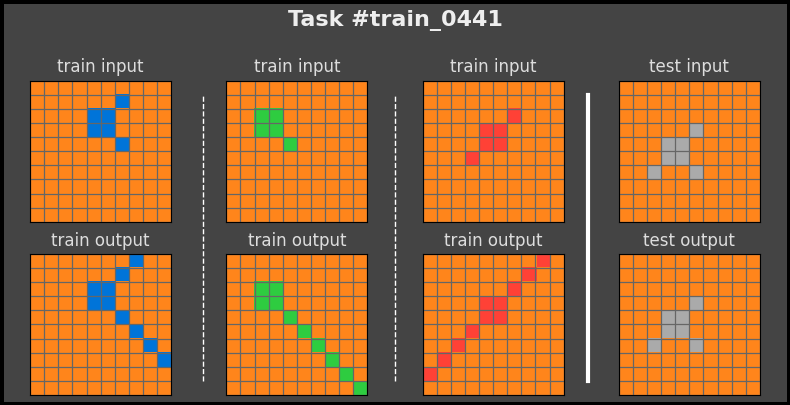

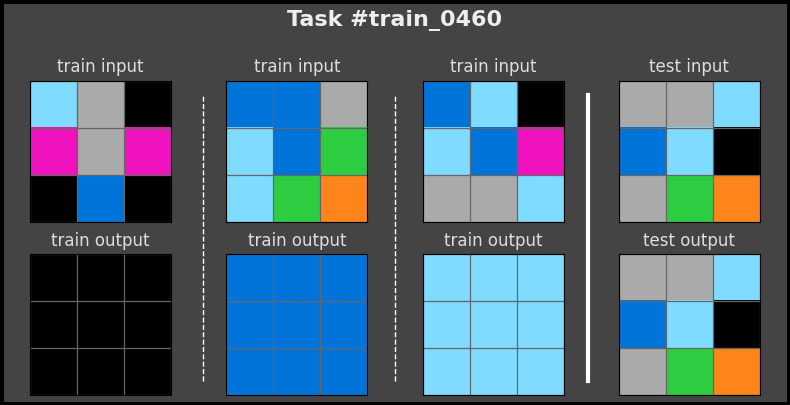

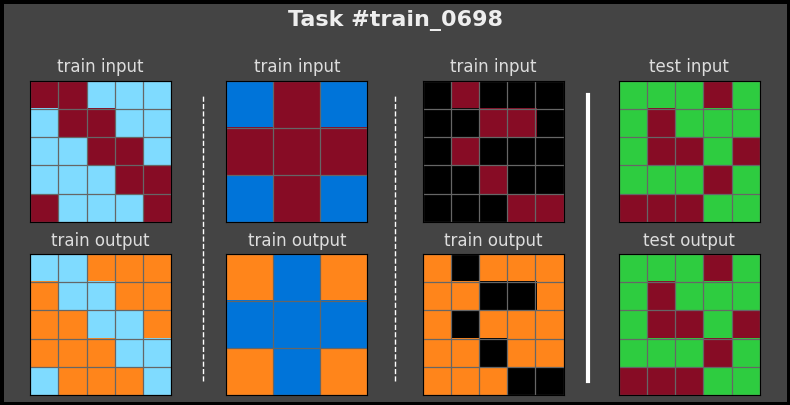

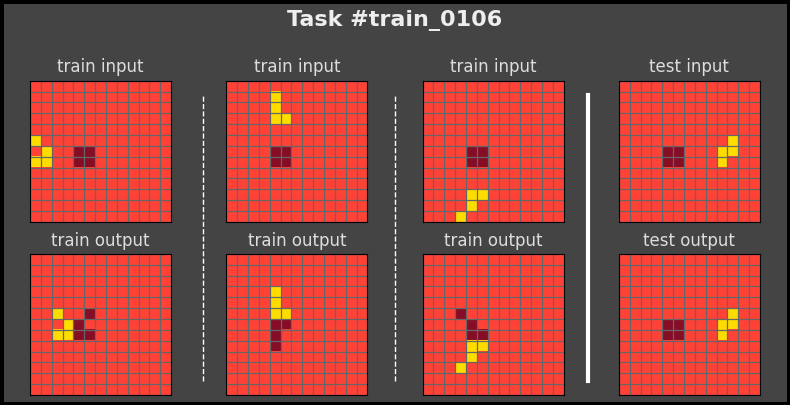

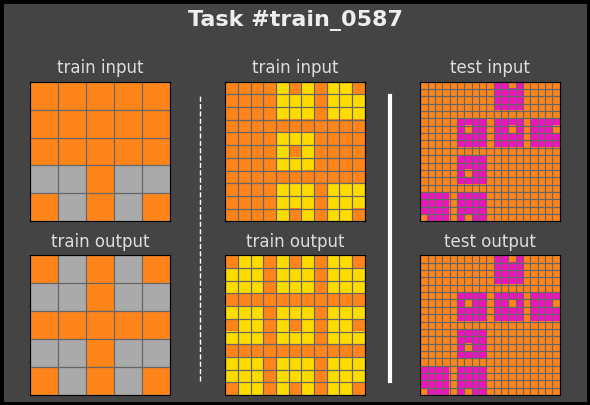

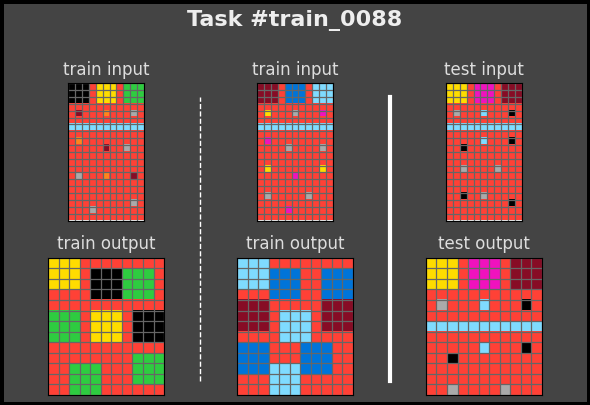

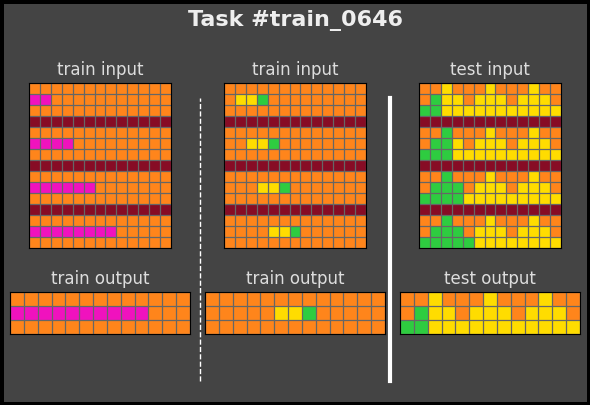

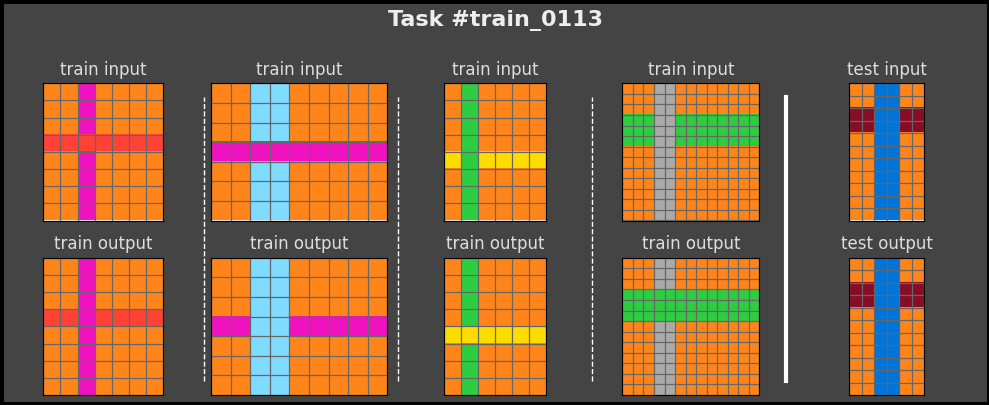

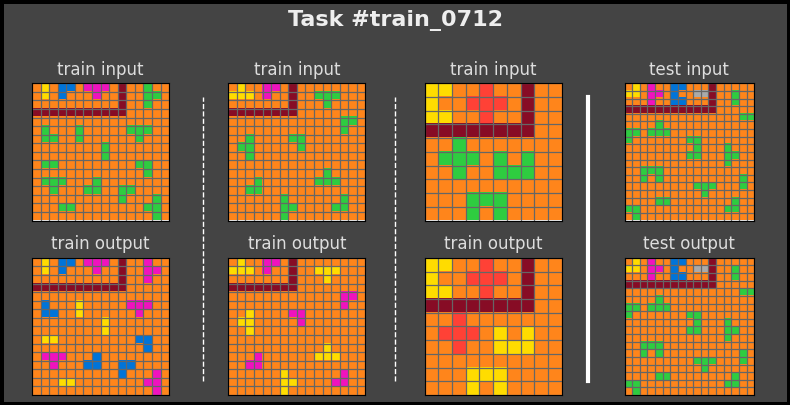

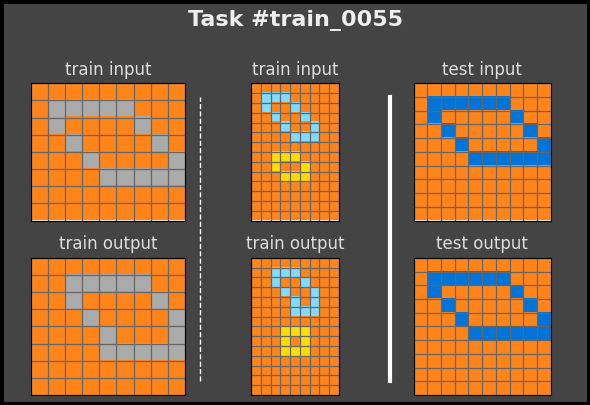

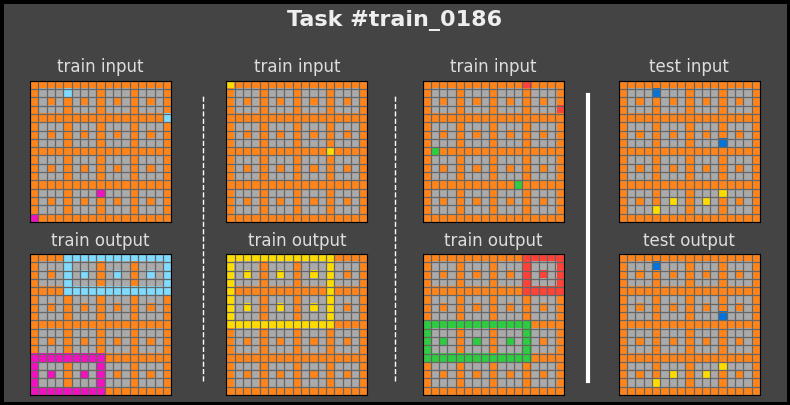

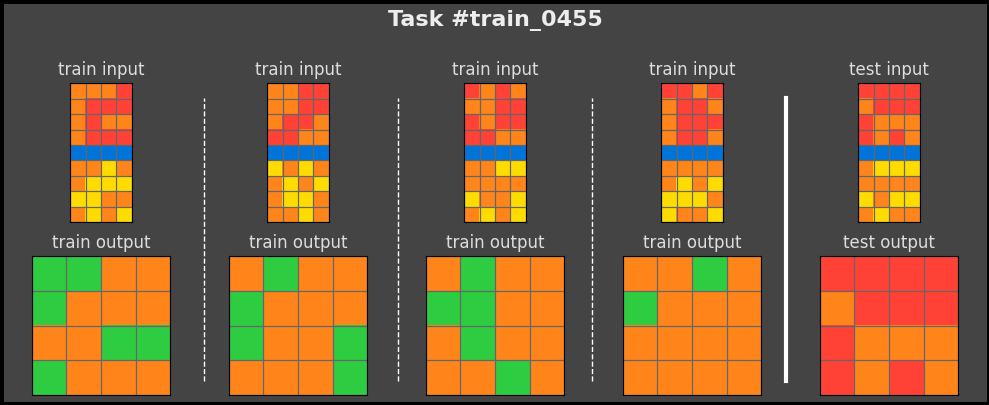

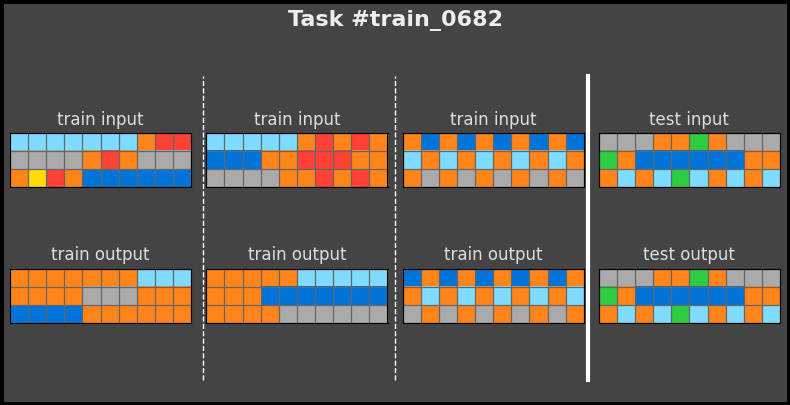

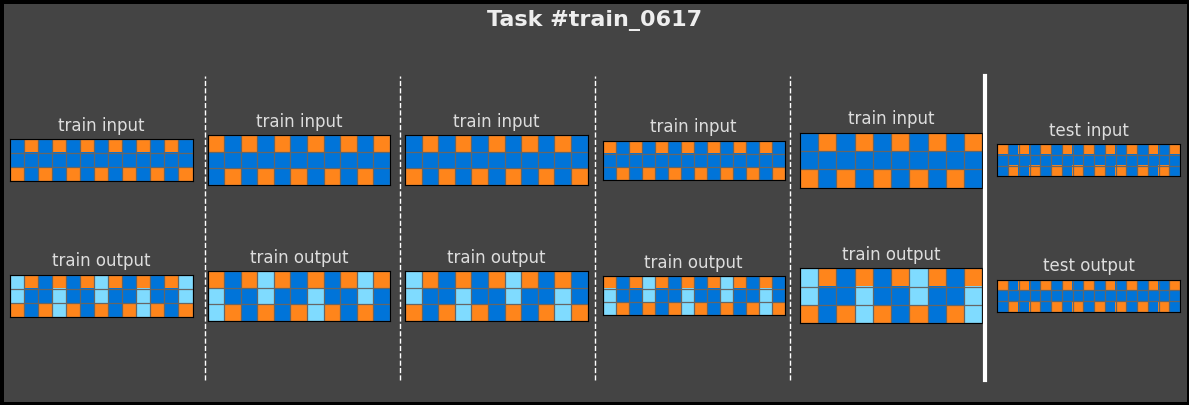

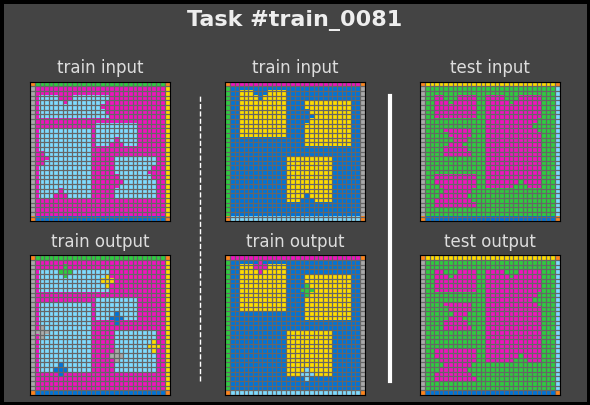

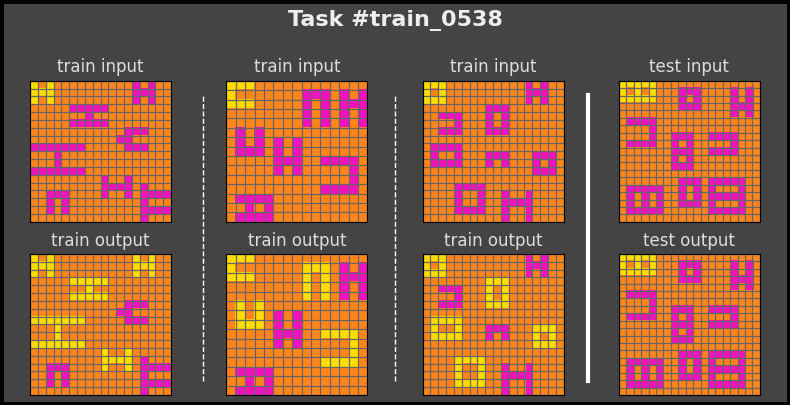

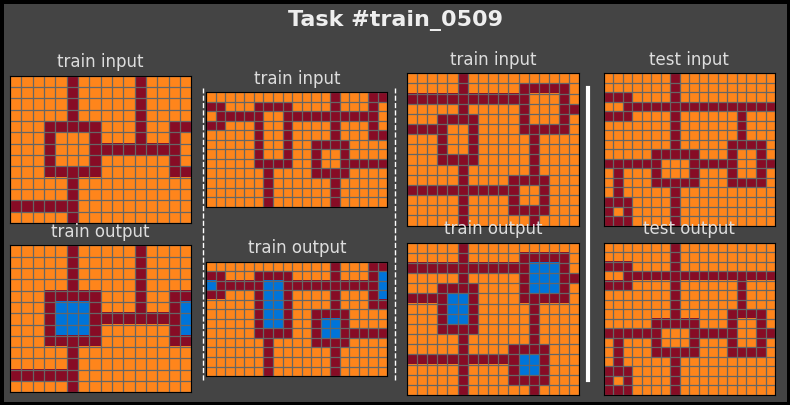

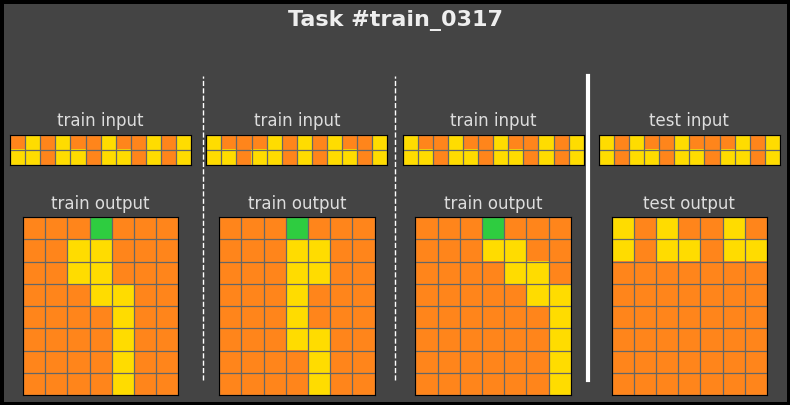

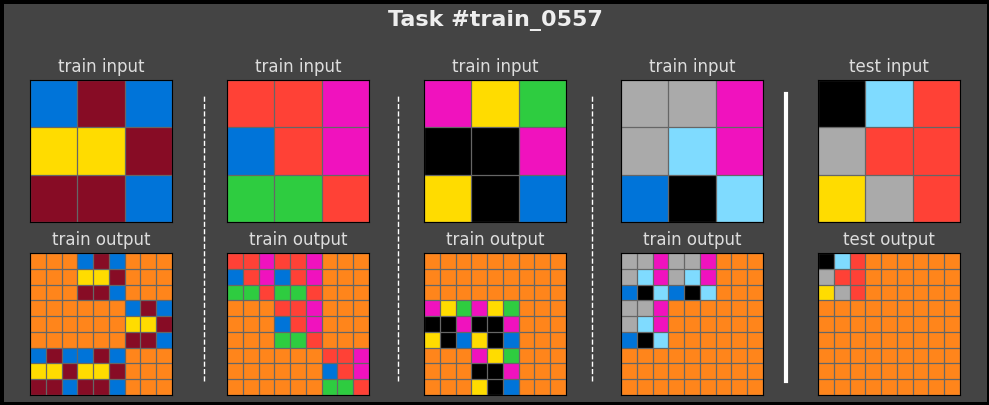

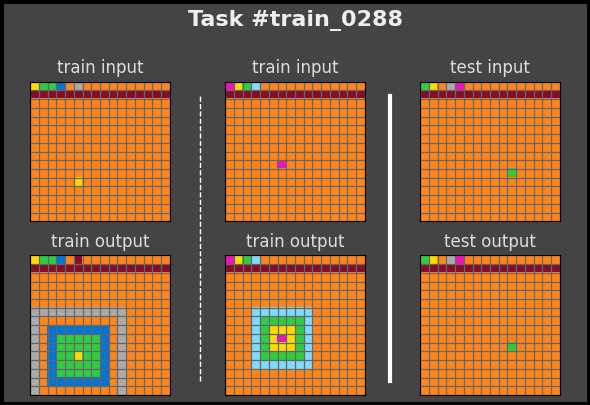

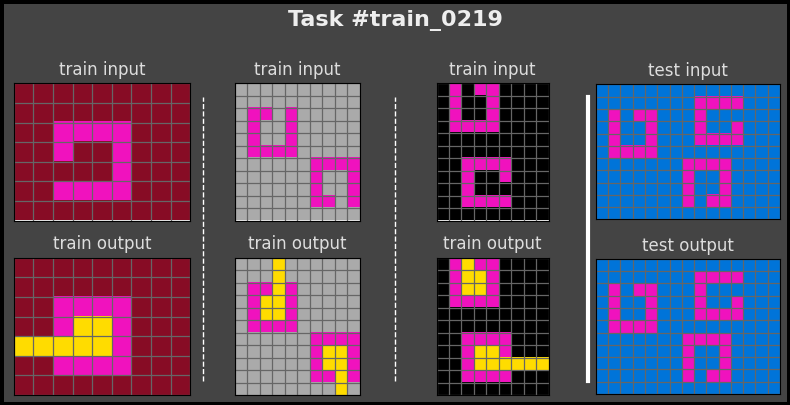

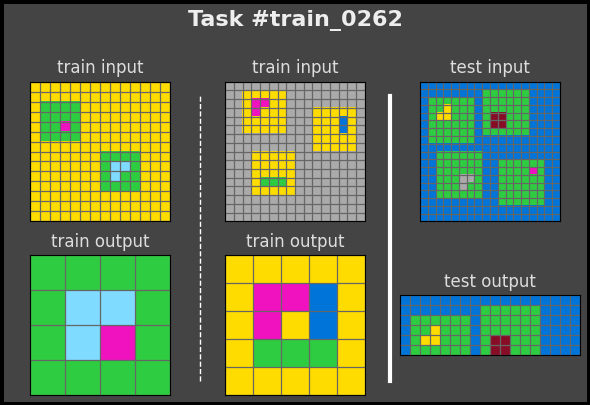

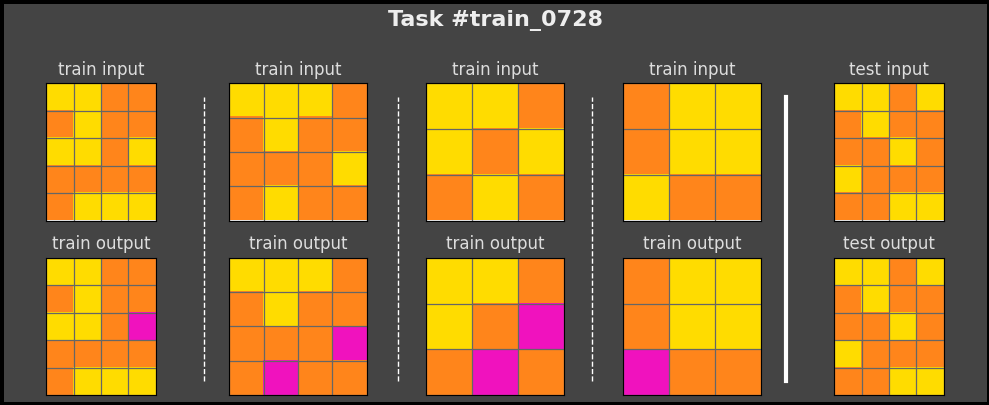

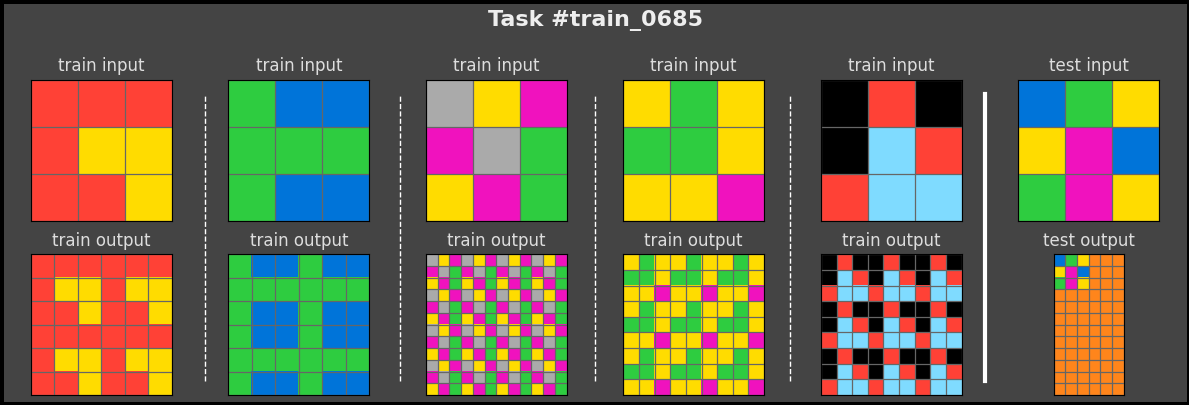

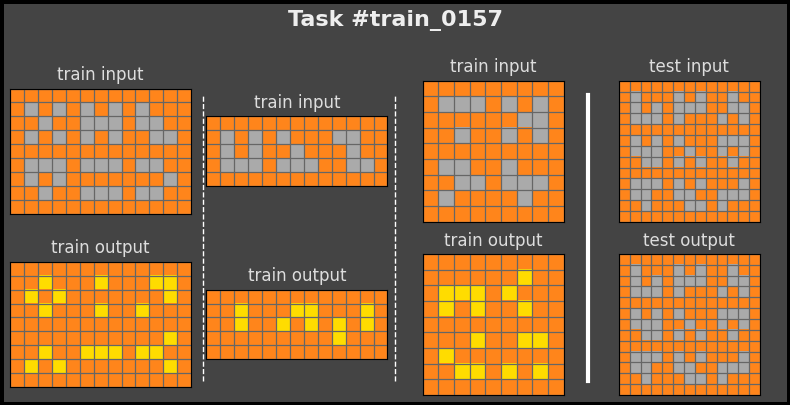

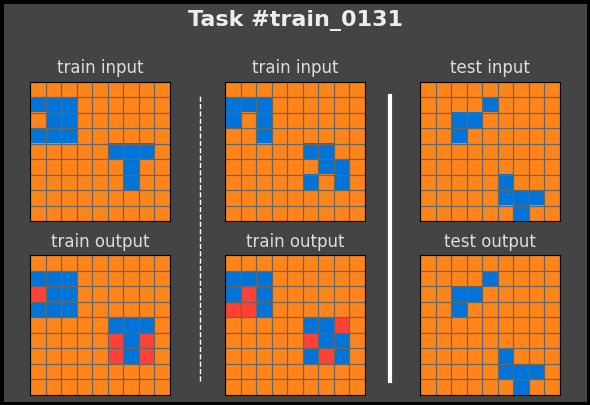

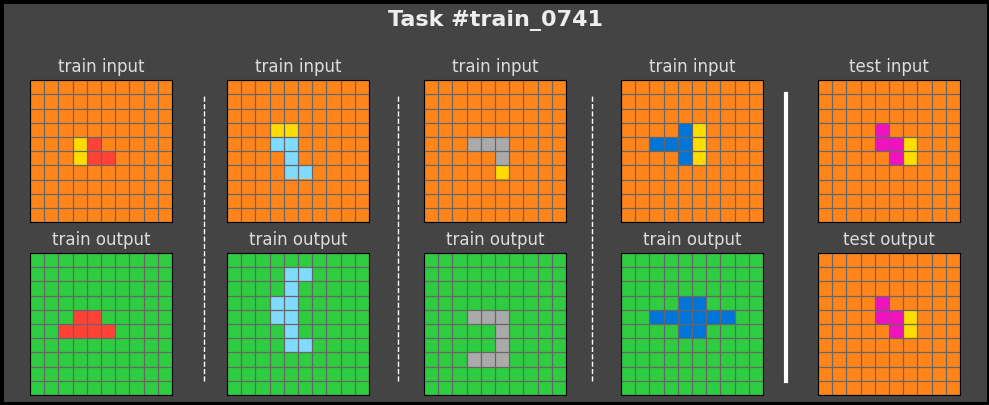

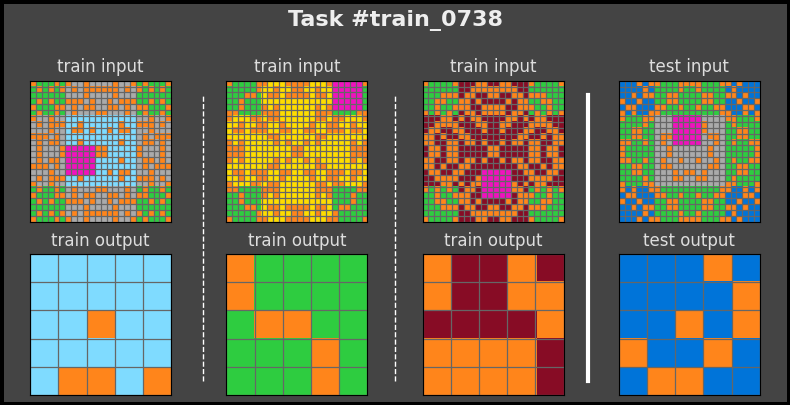

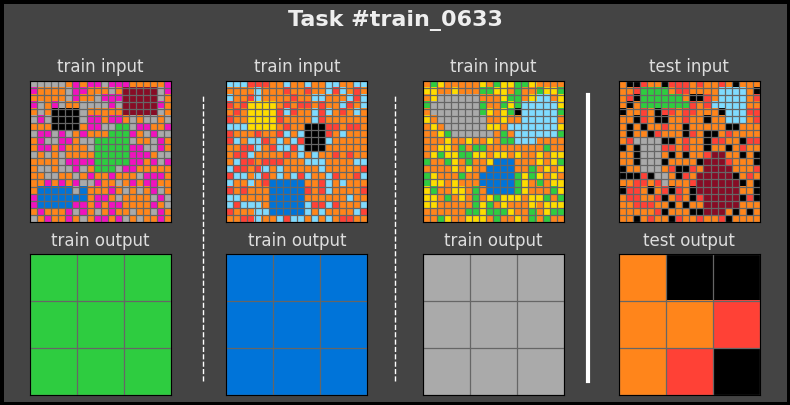

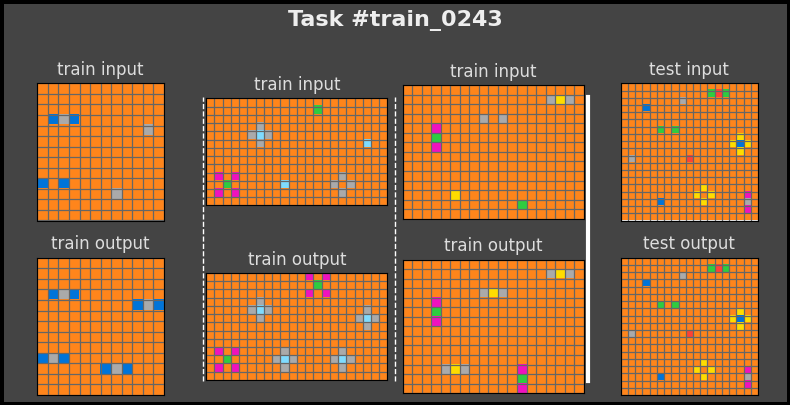

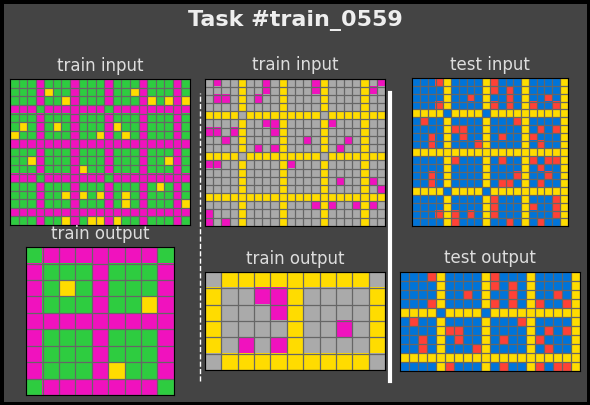

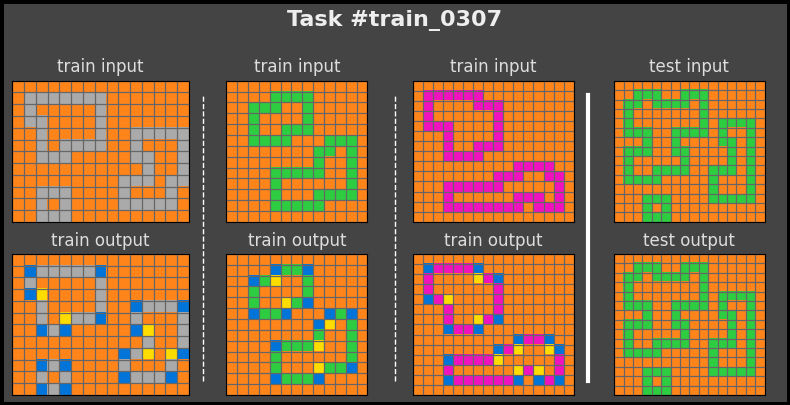

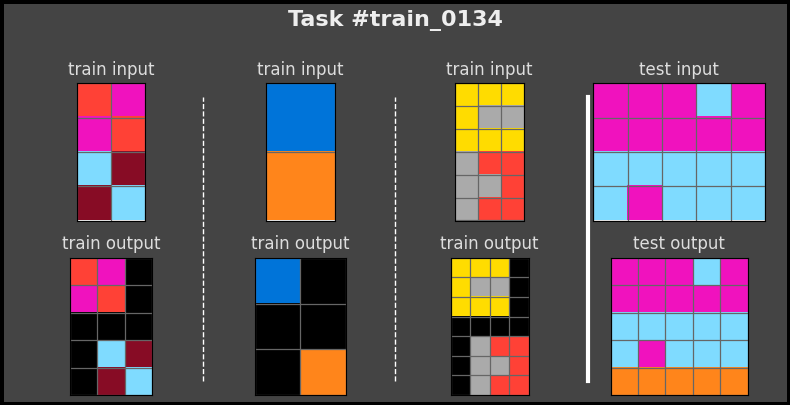

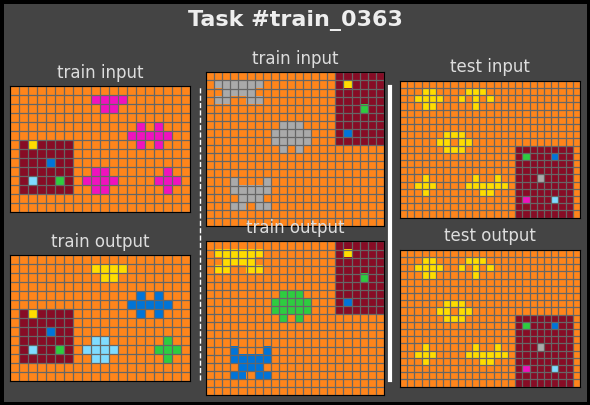

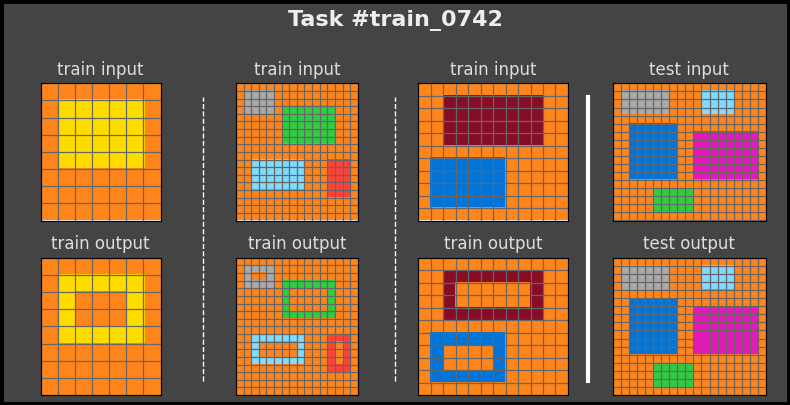

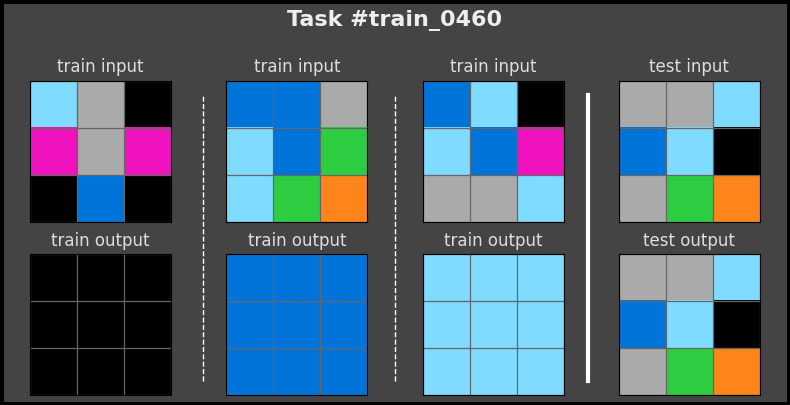

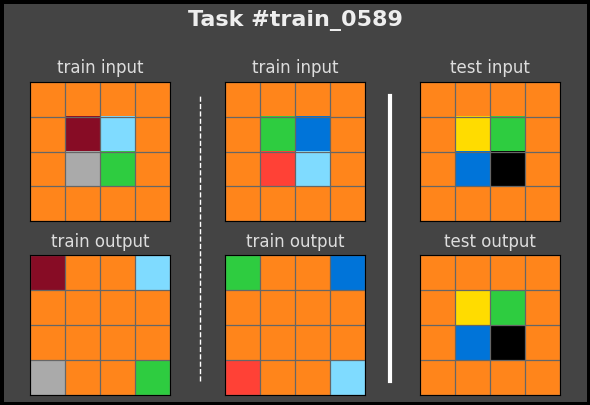

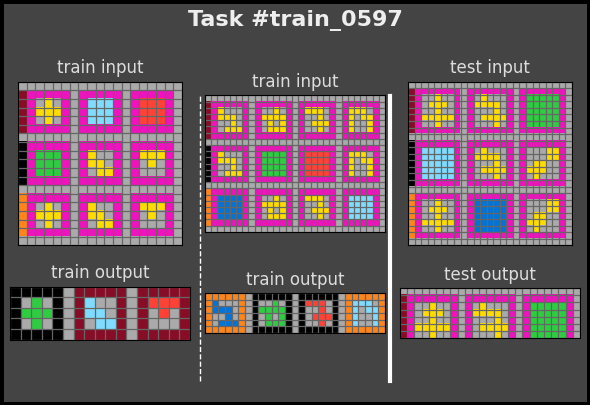

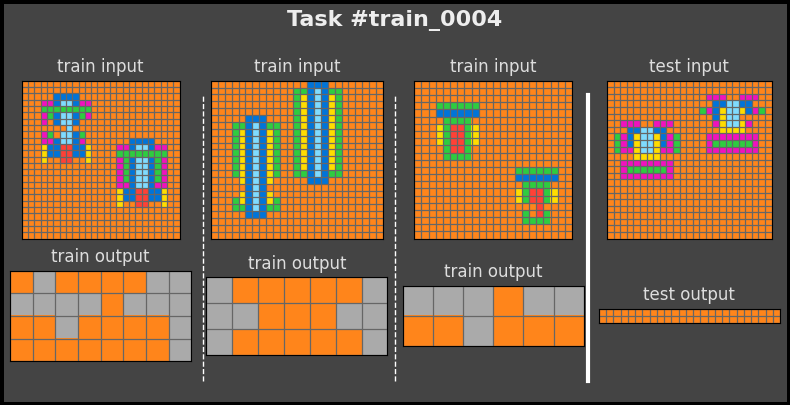

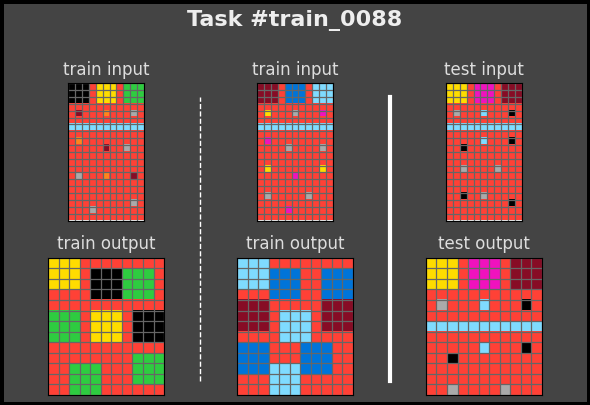

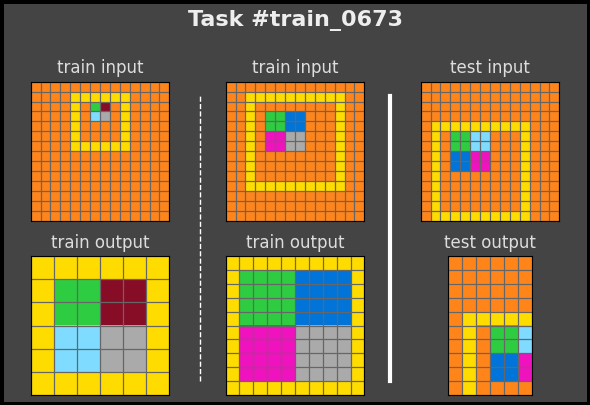

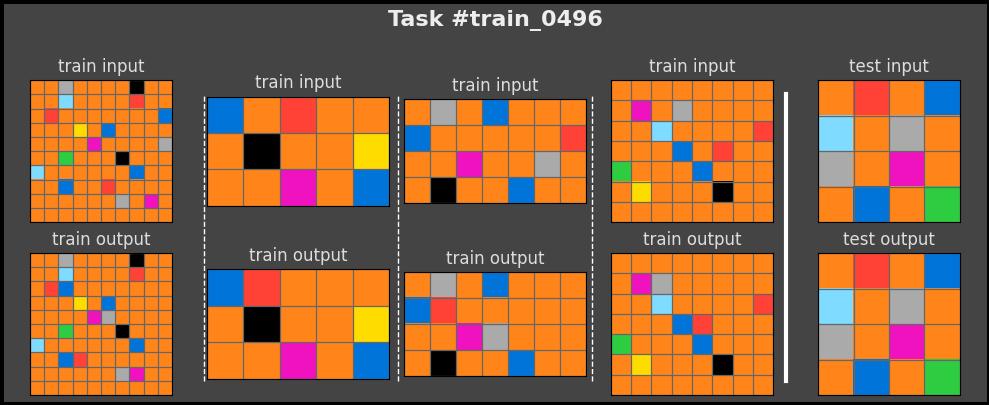

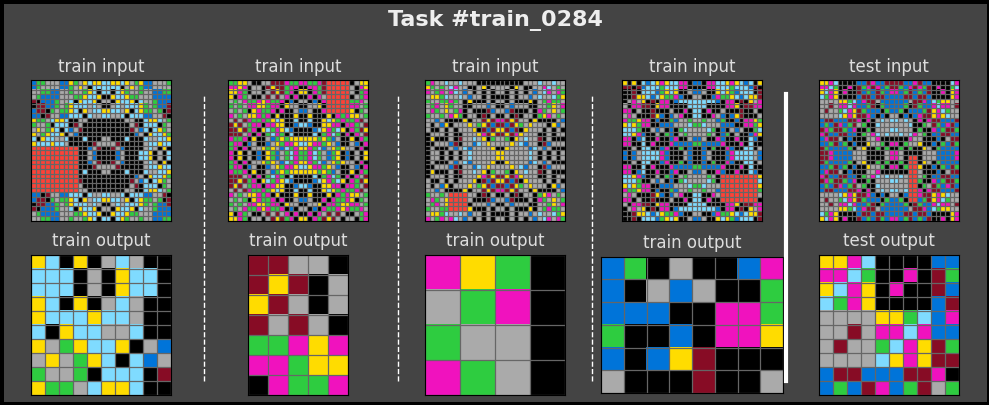

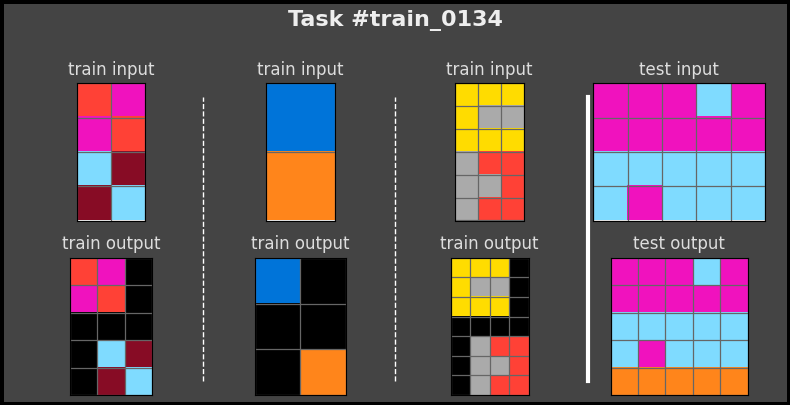

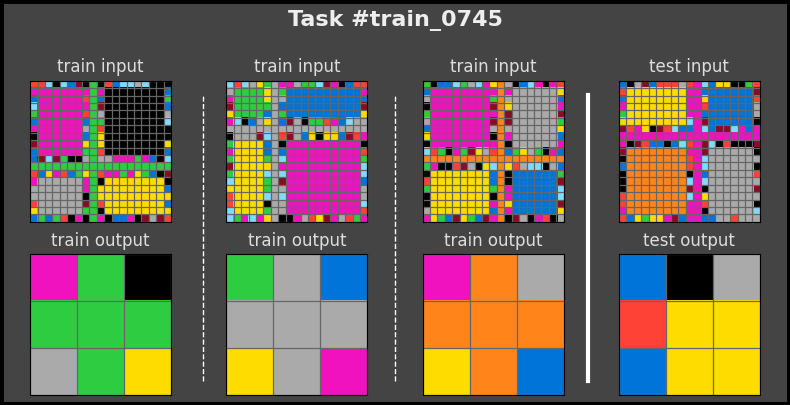

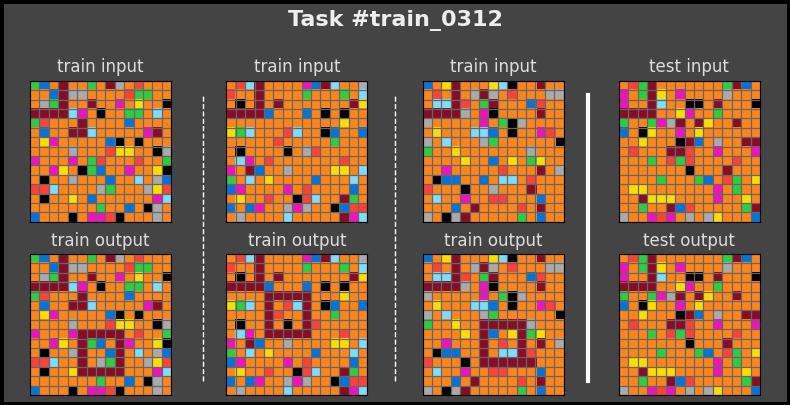

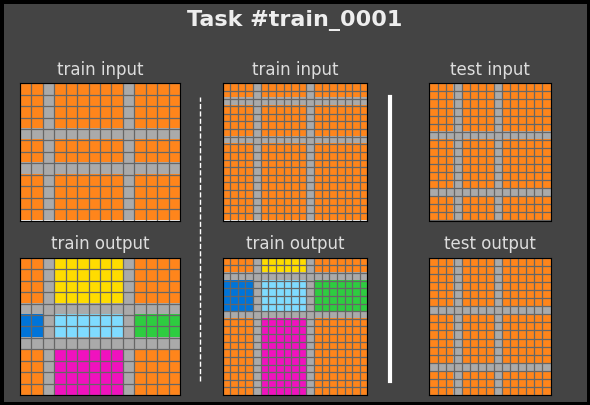

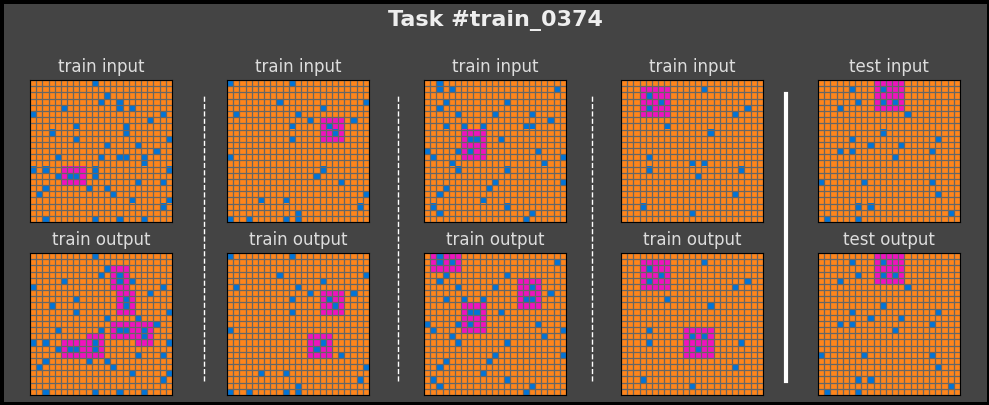

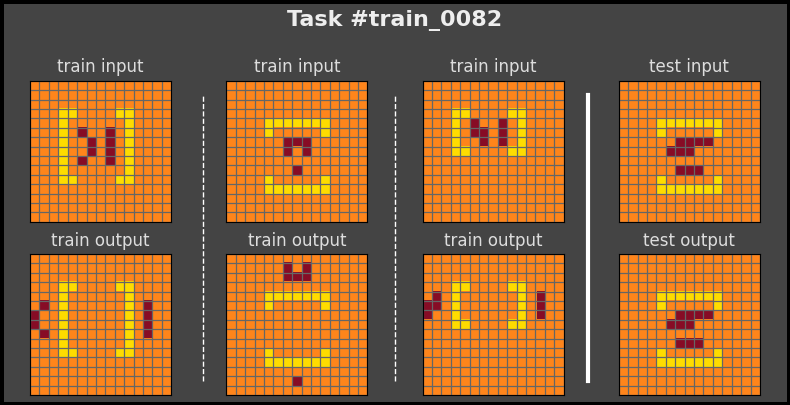

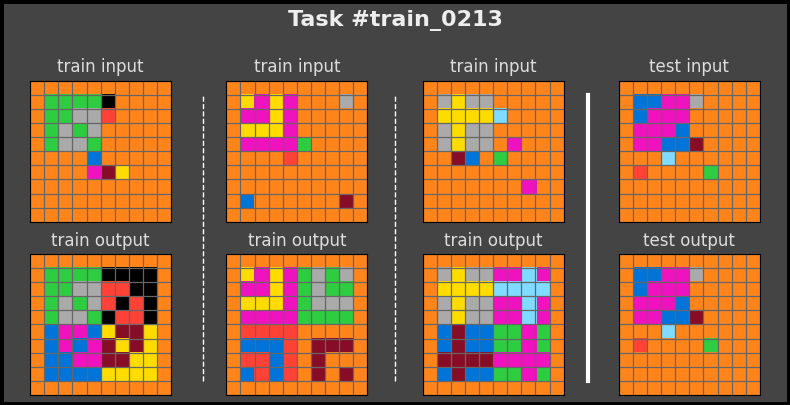

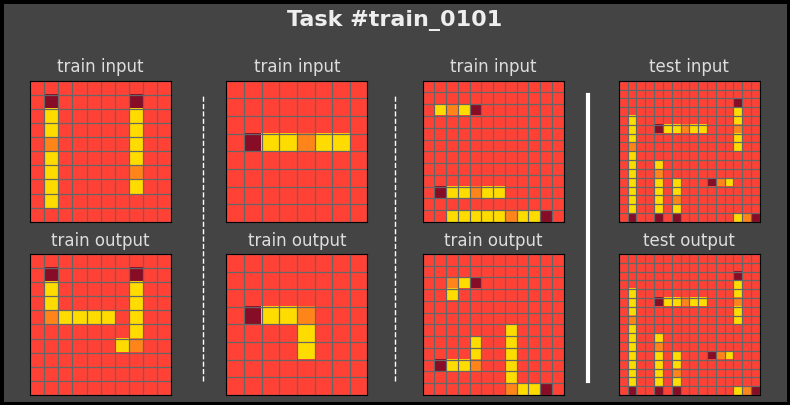

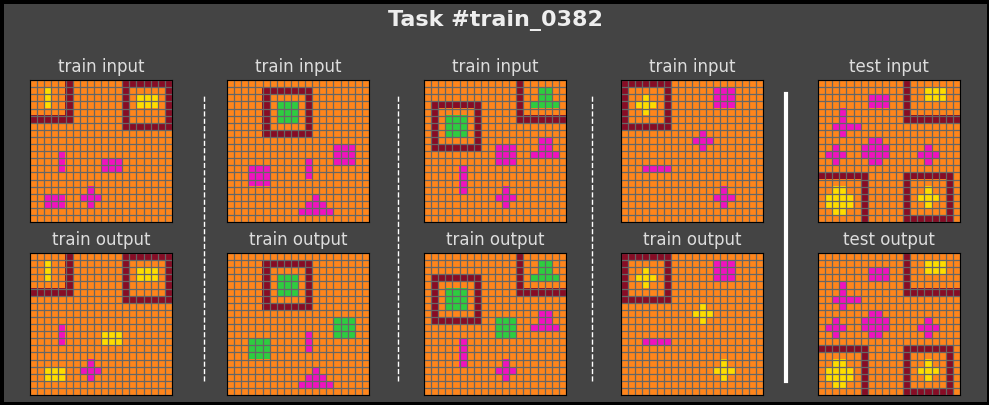

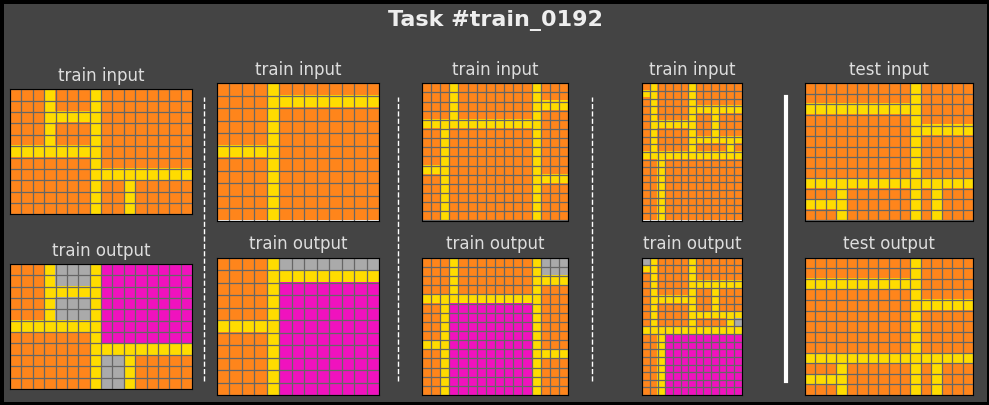

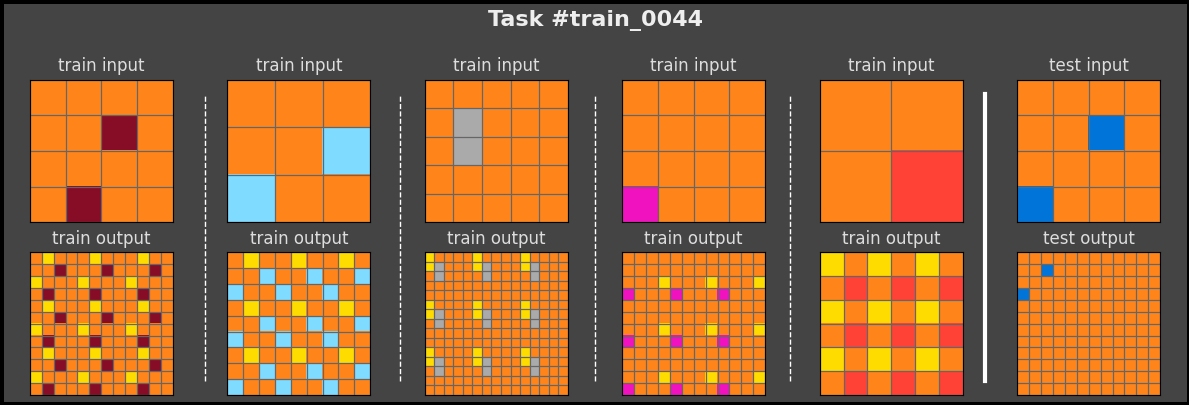

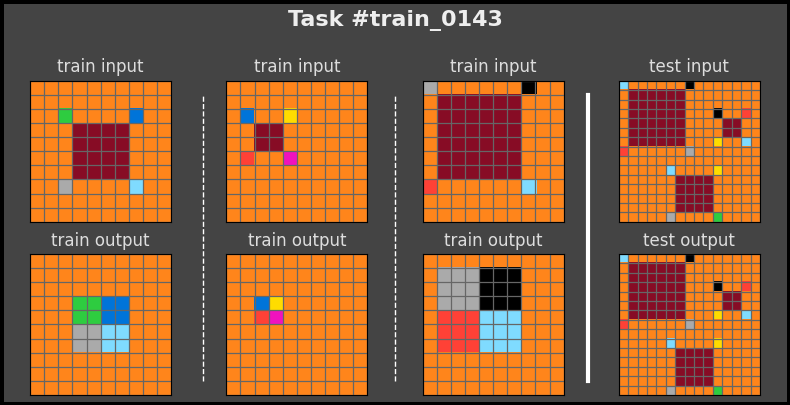

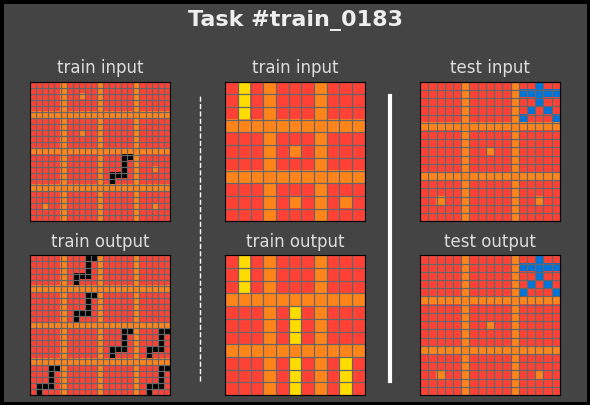

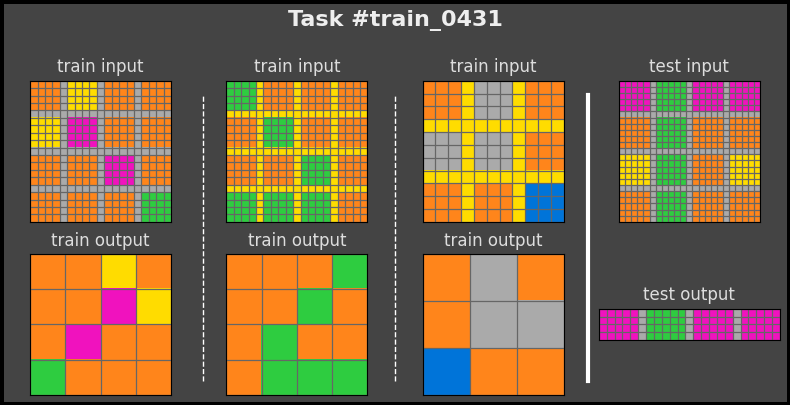

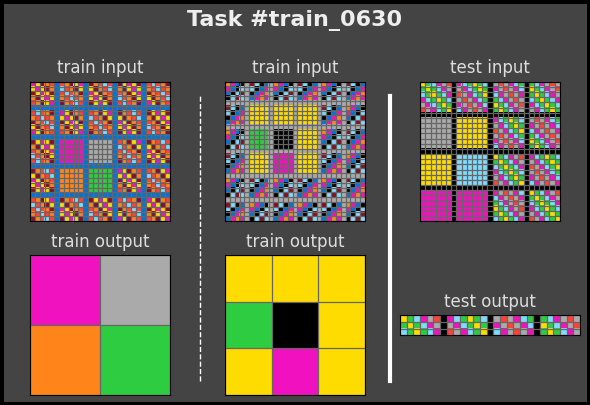

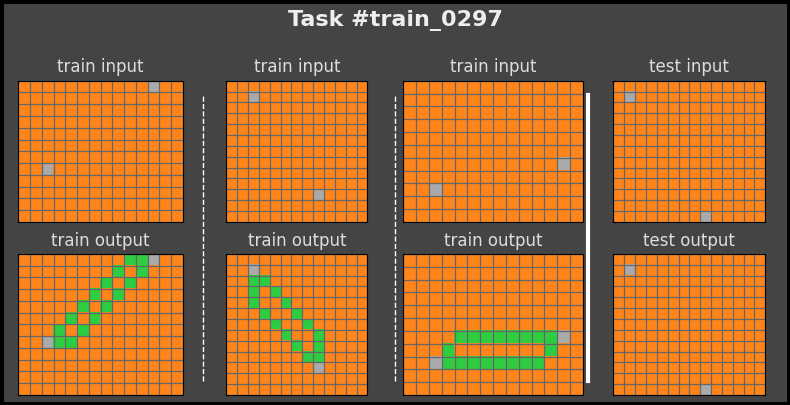

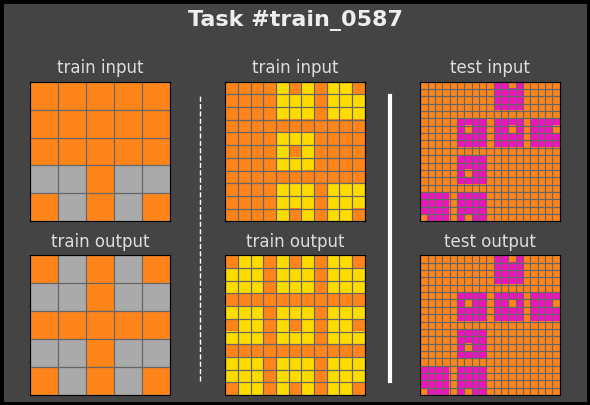

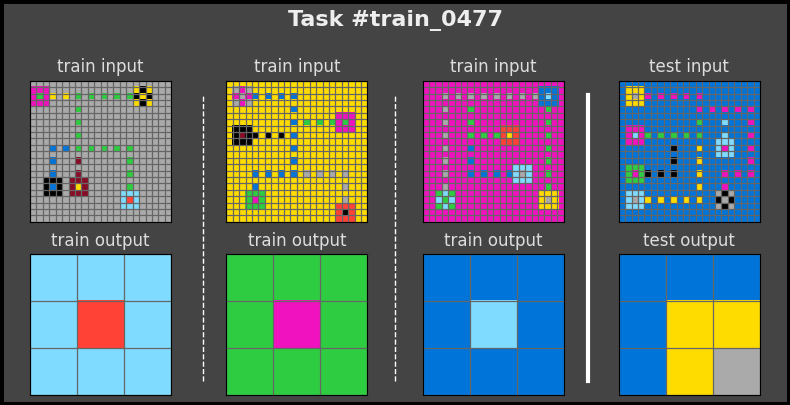

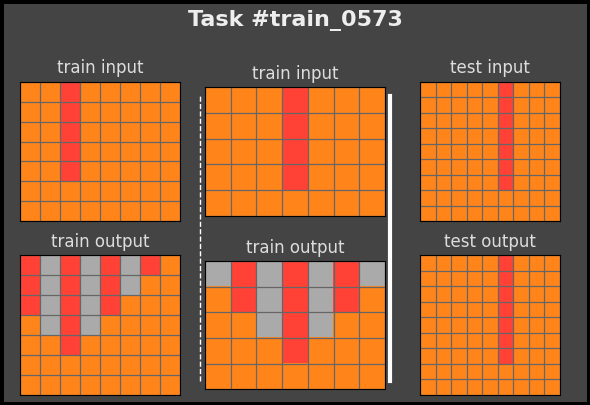

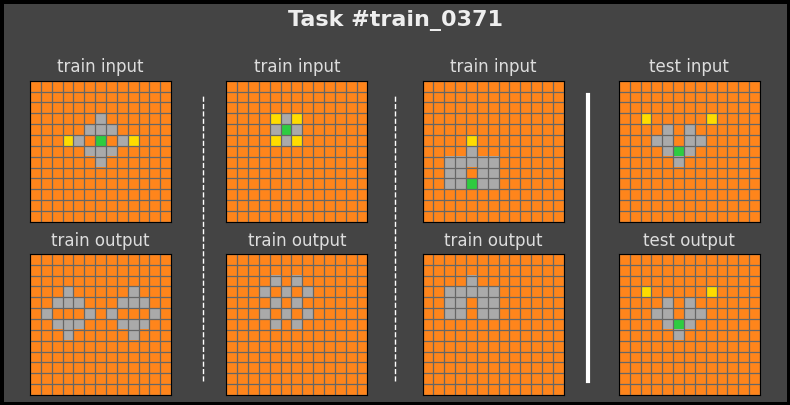

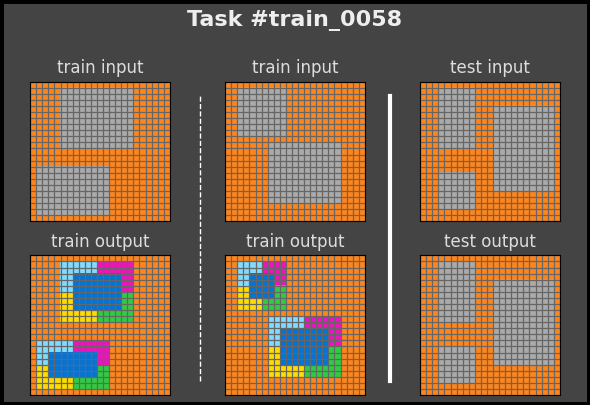

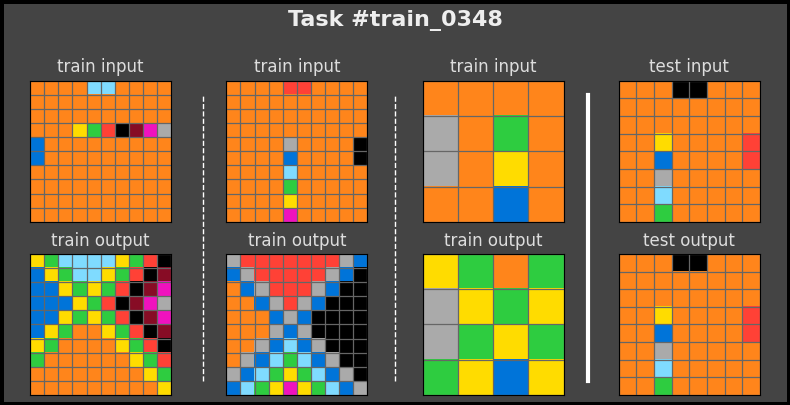

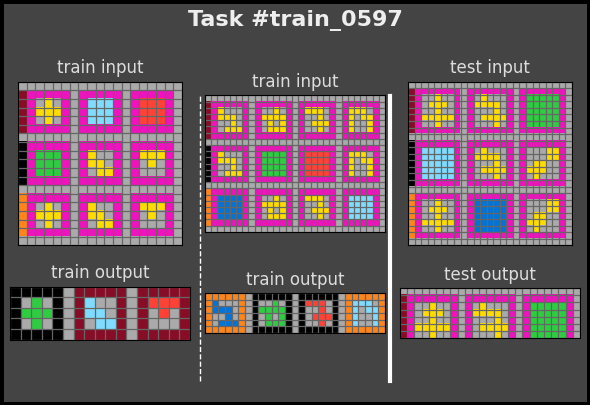

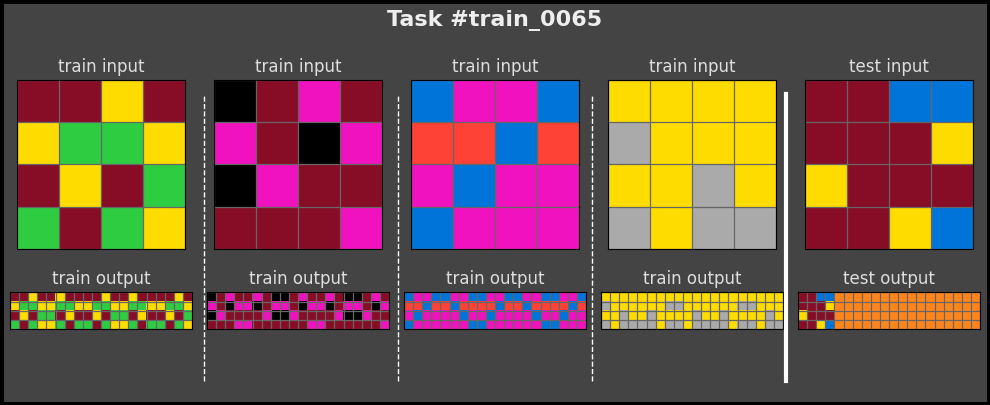

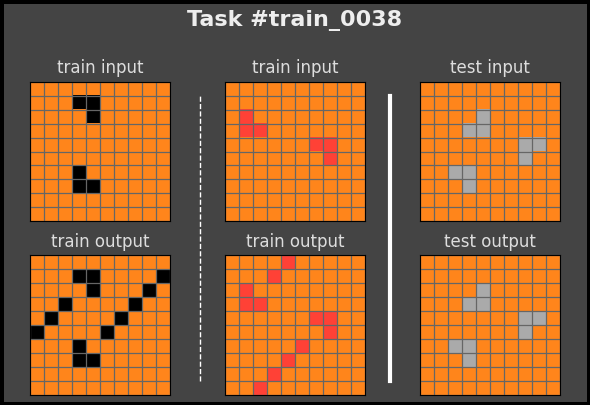

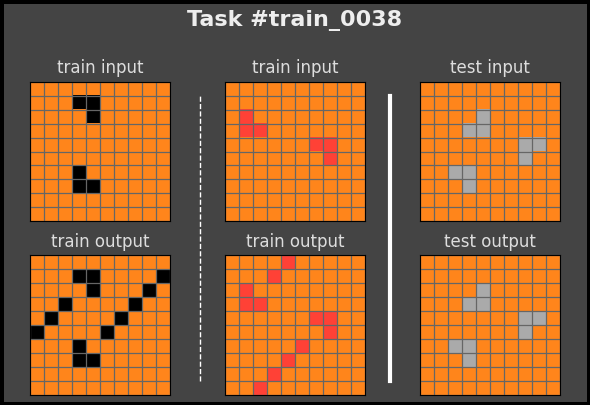

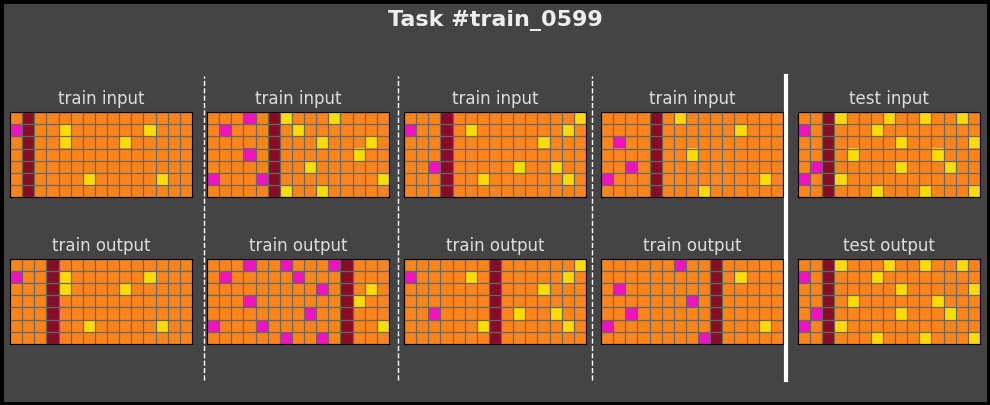

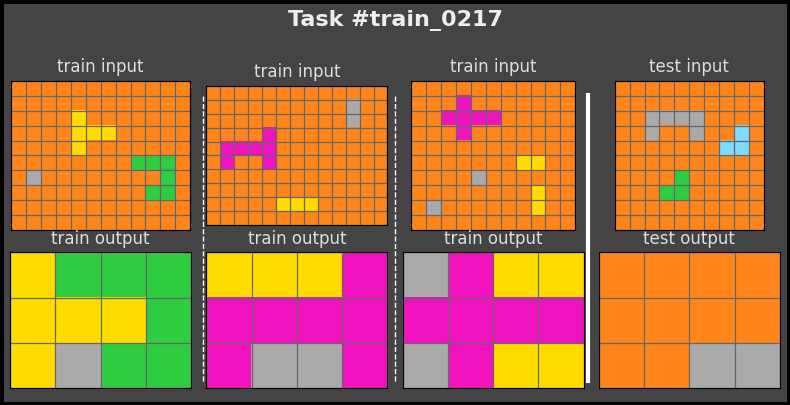

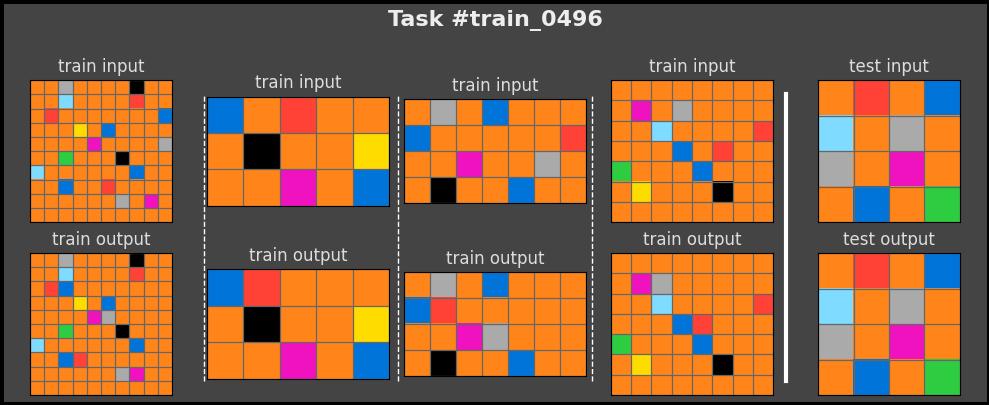

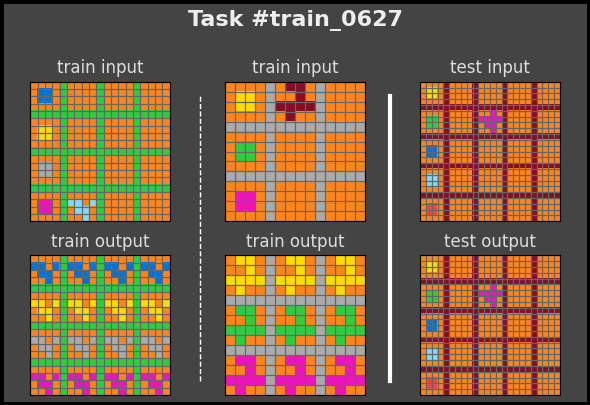

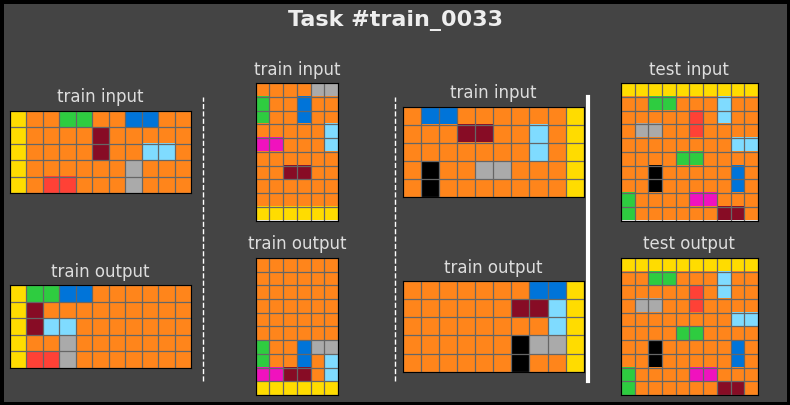

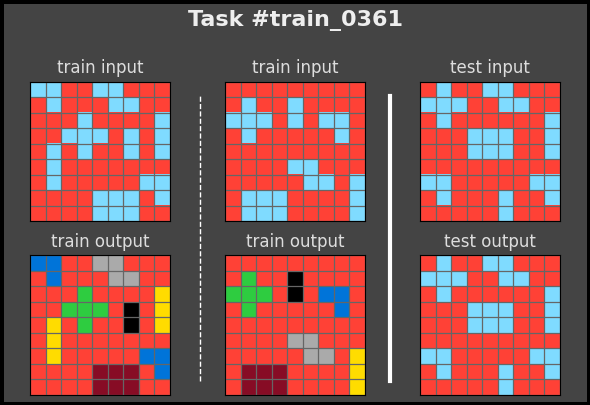

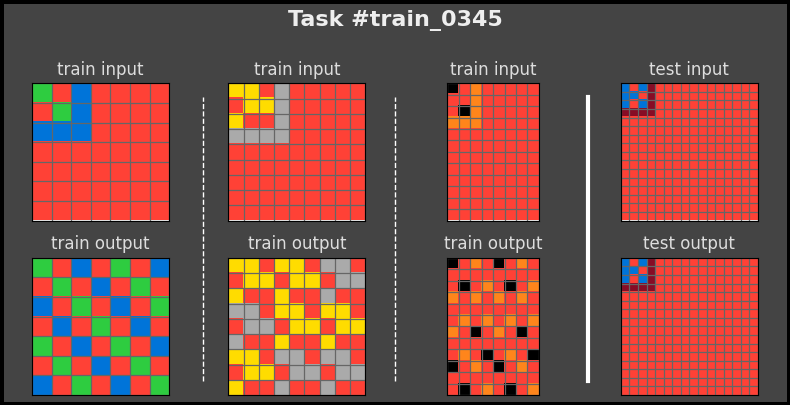

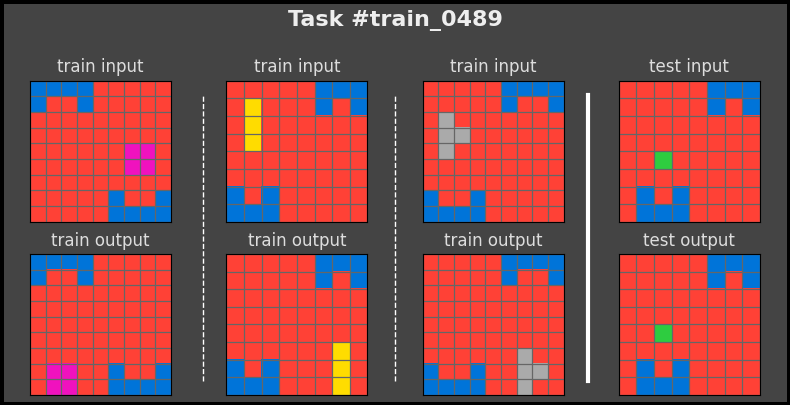

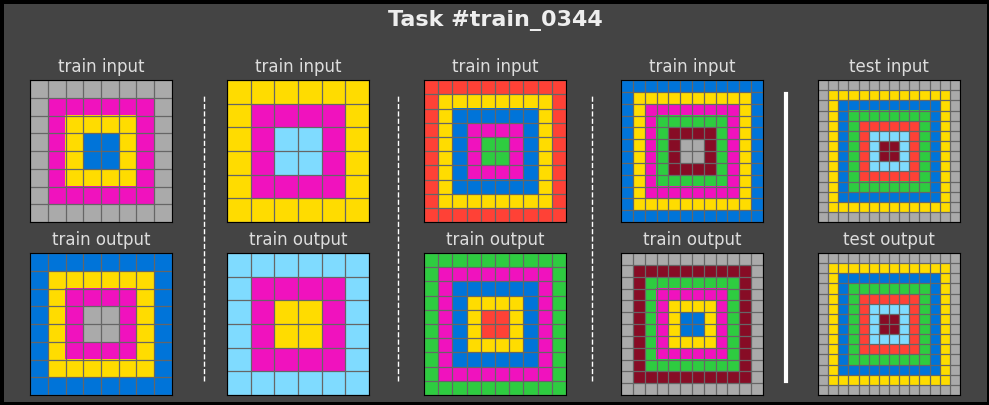

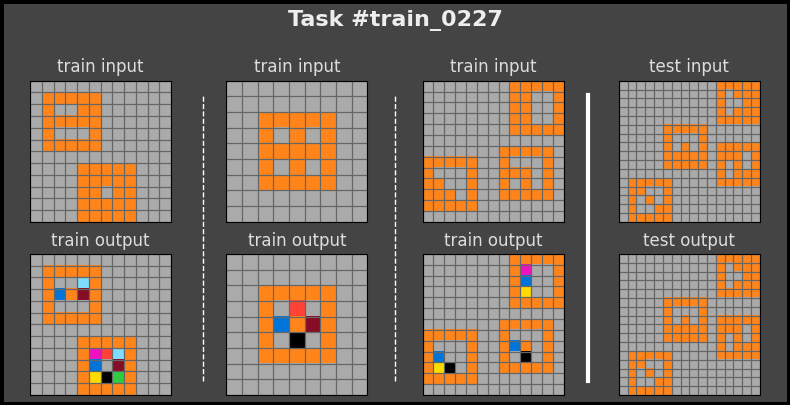

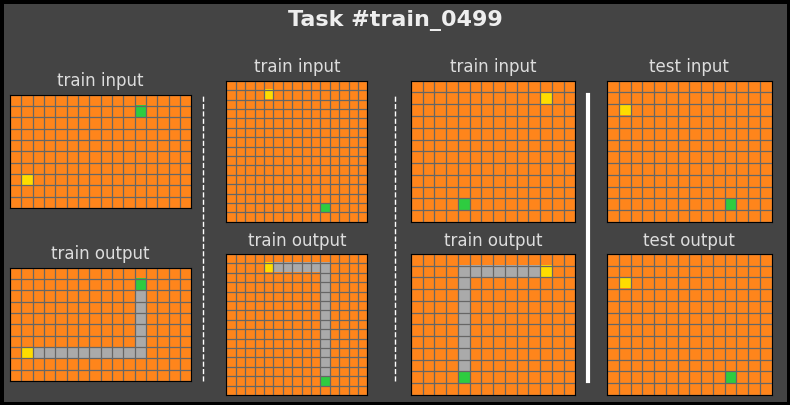

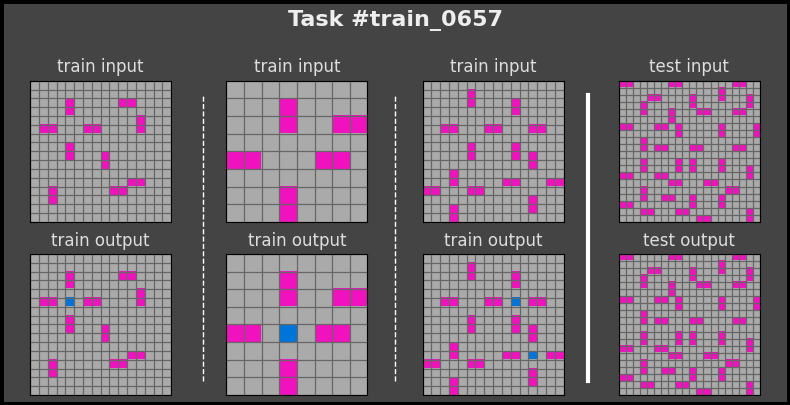

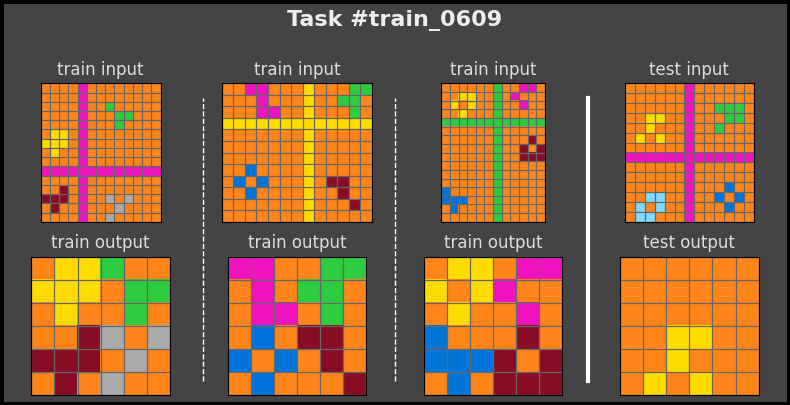

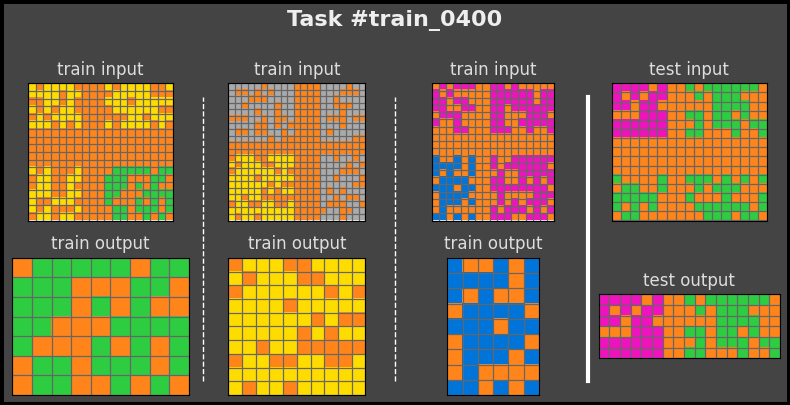

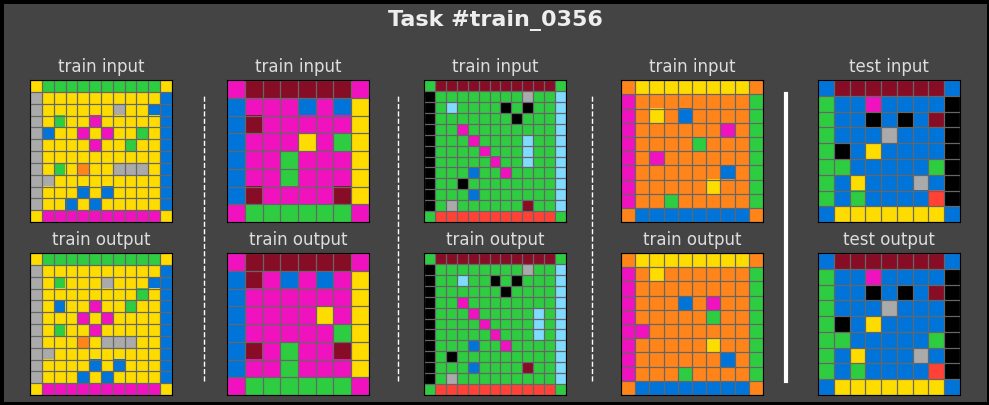

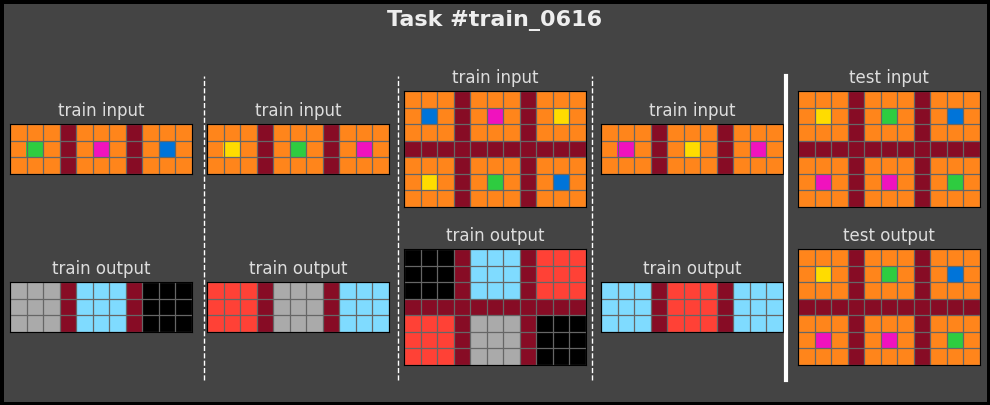

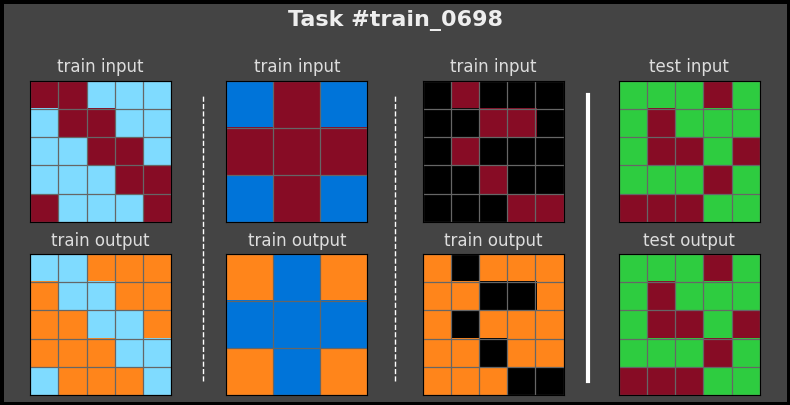

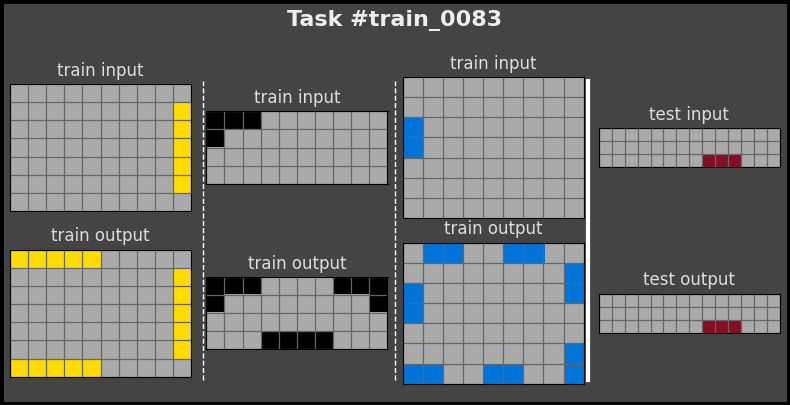

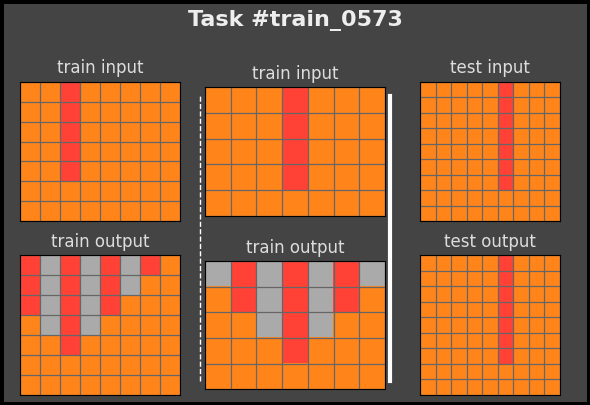

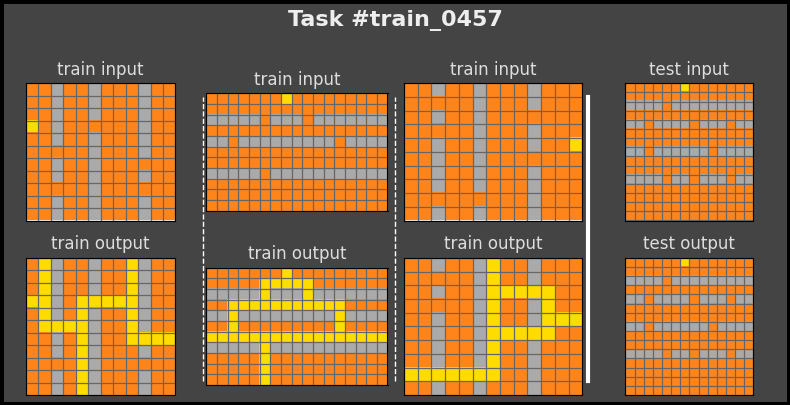

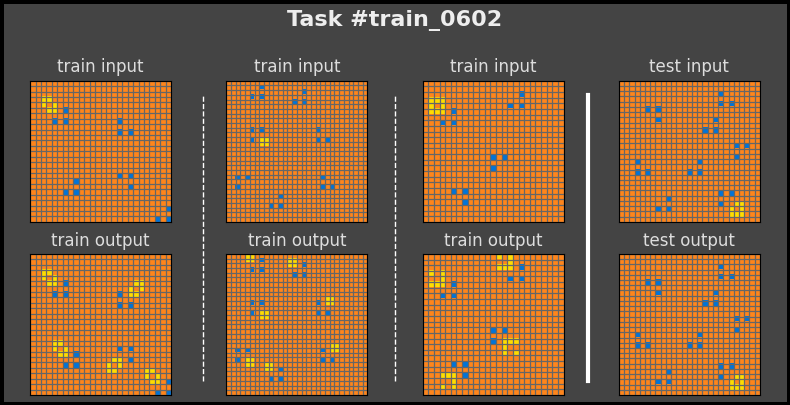

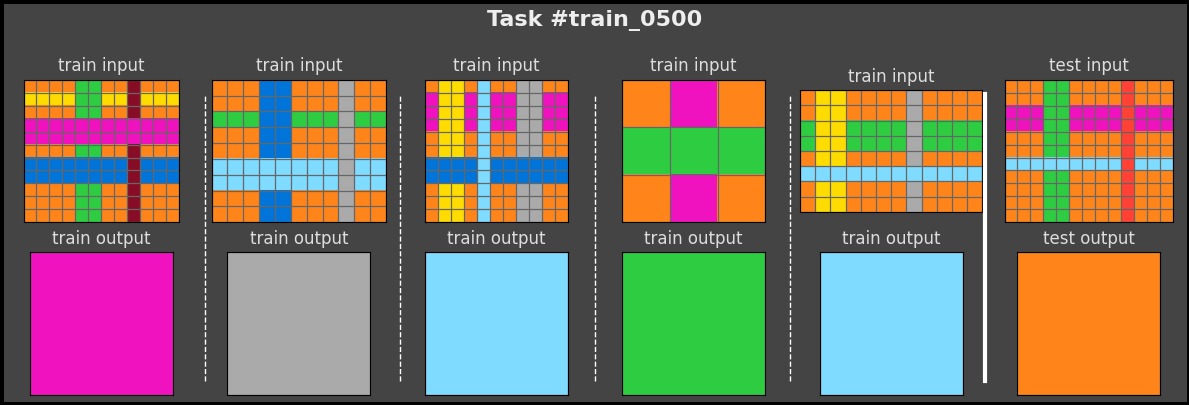

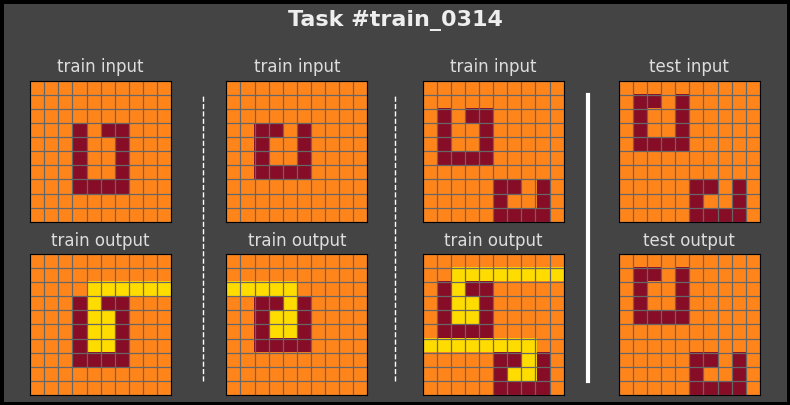

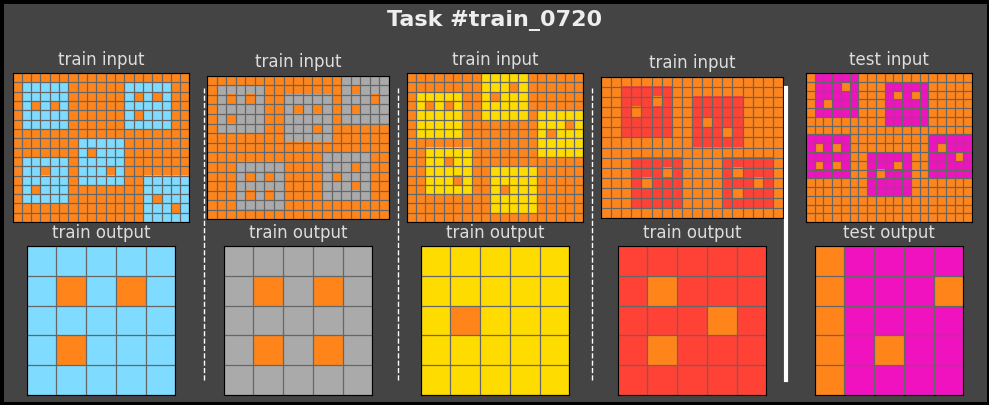

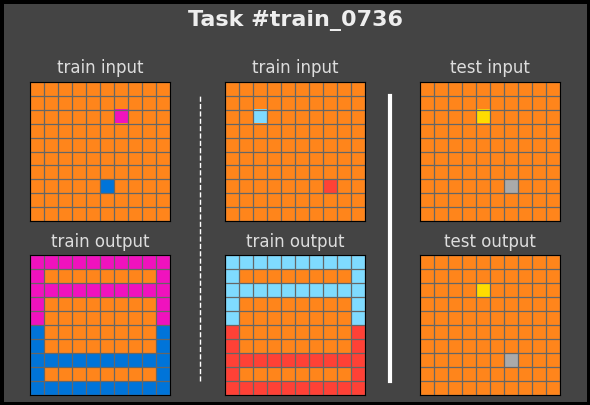

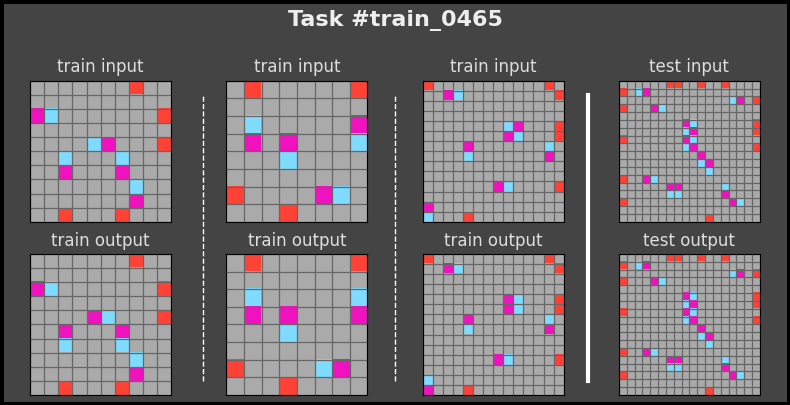

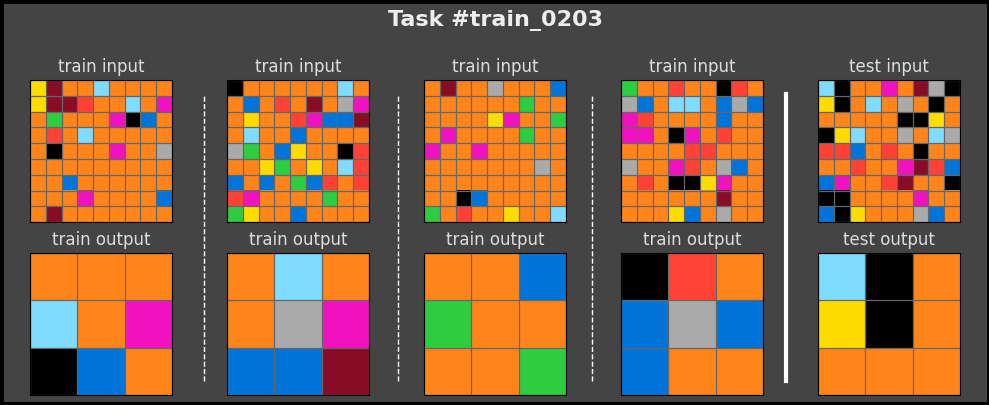

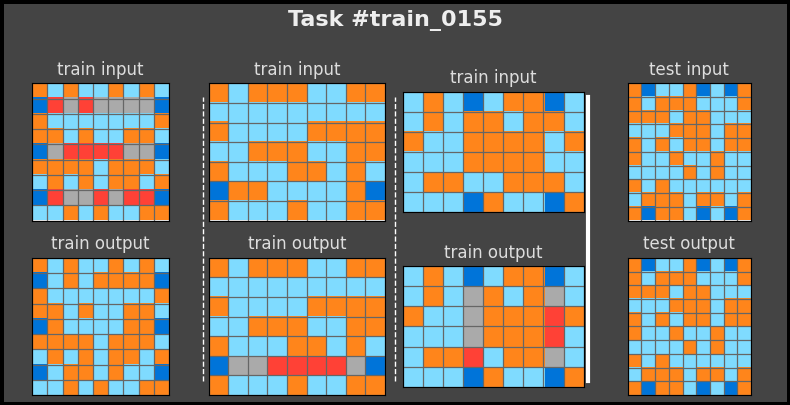

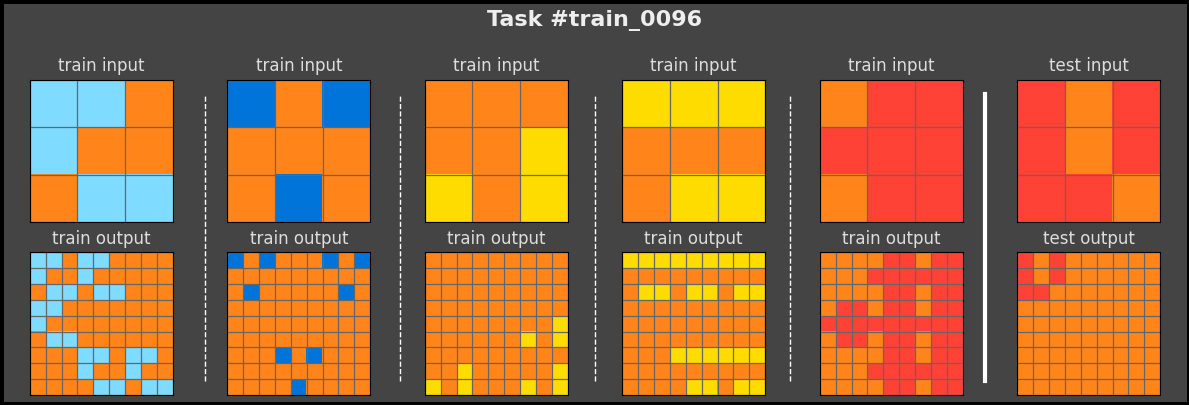

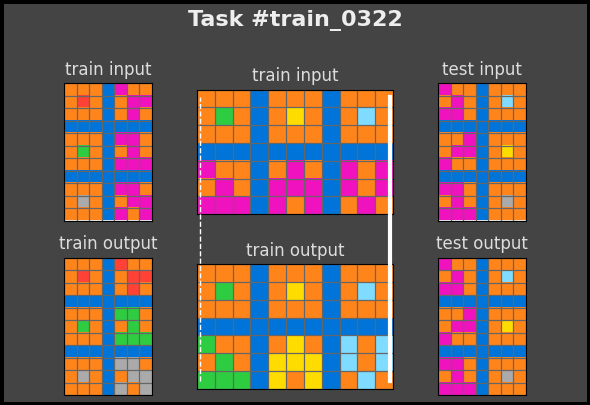

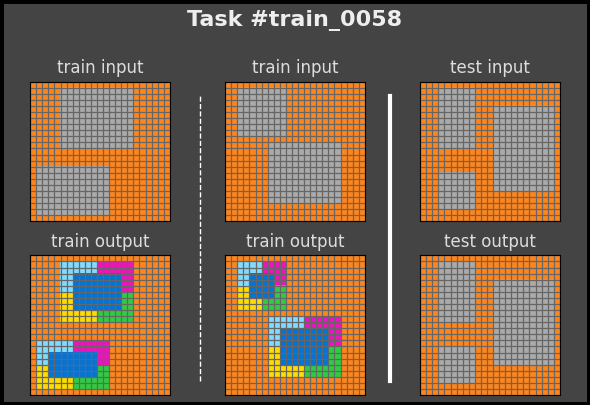

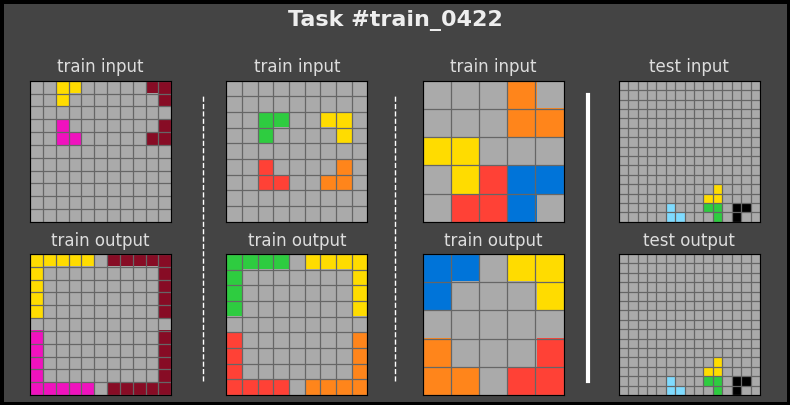

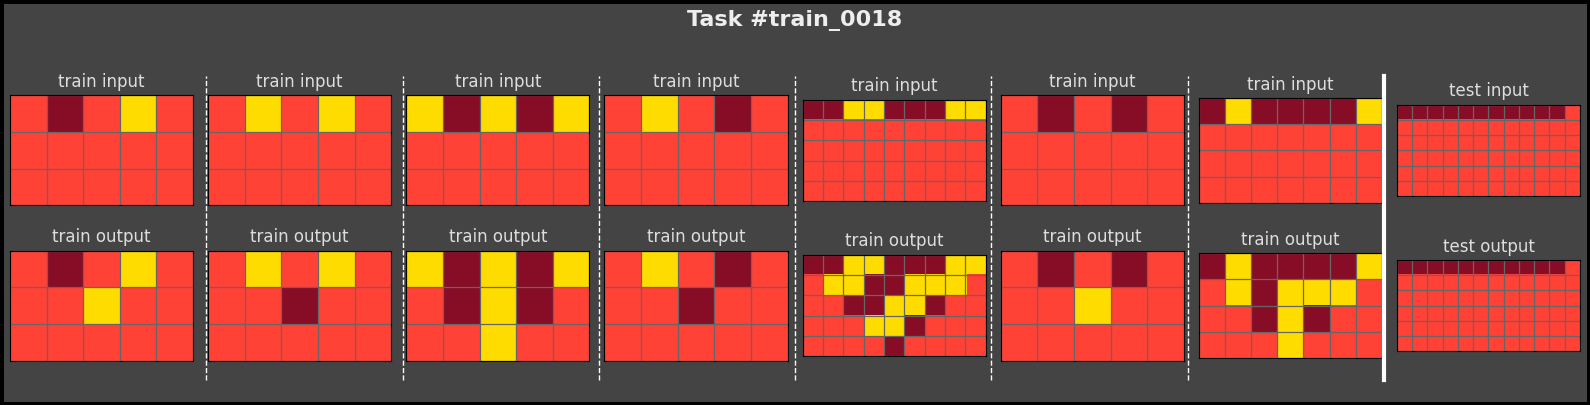

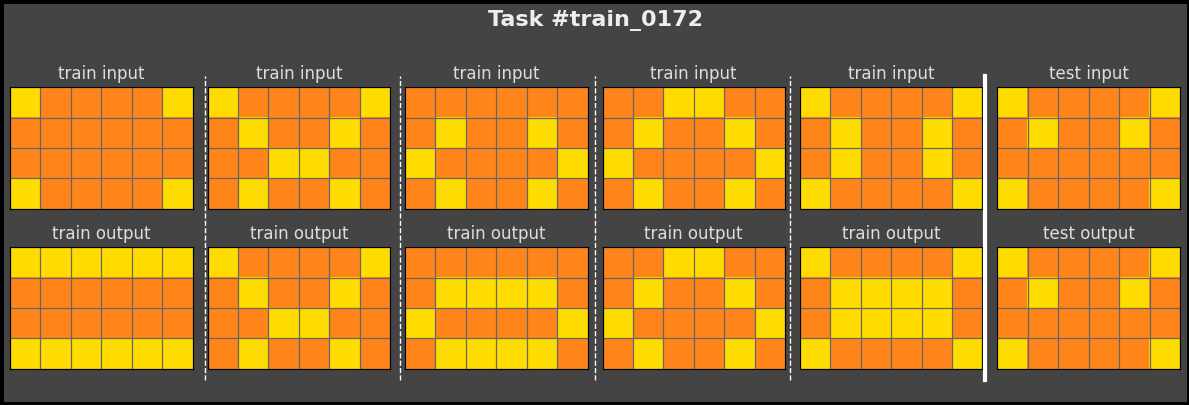

In [32]:
for solution in train_preds:
    task_id = list(solution.keys())[0]
    task = train_data[task_id]
    visualize_task(
        task_data=task,
        task_id=task_id, 
        size=2.0, 
        w1=.9,
        task_solutions=solution
    )

# Predict on Test Set

In [33]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join("../", Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [34]:
test_out_rows = get_row_sizes(ss)
test_out_rows

ID_  n_rows
0    test_0000      10
1    test_0001      12
2    test_0002      10
3    test_0003       8
4    test_0004      30
..         ...     ...
180  test_0180      25
181  test_0181      10
182  test_0182      19
183  test_0183      10
184  test_0184      10

[185 rows x 2 columns]

In [35]:
test_out_rows.describe().transpose()

count       mean       std  min  25%   50%   75%   max
n_rows  185.0  12.448649  7.509328  1.0  8.0  10.0  16.0  30.0

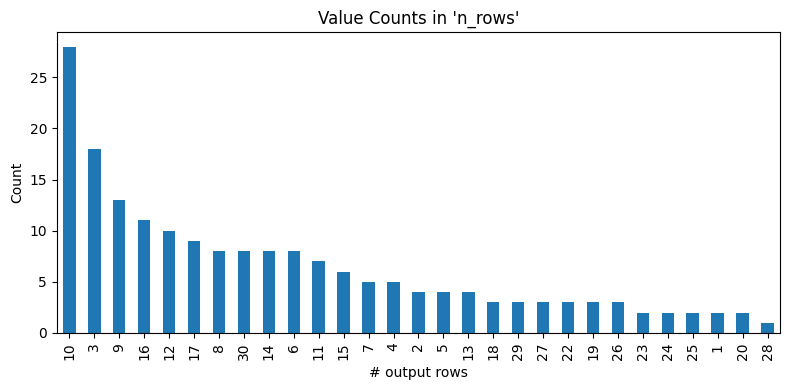

In [36]:
value_counts = test_out_rows["n_rows"].value_counts()

value_counts.plot(kind="bar", figsize=(8, 4))
plt.xlabel("# output rows")
plt.ylabel("Count")
plt.title("Value Counts in 'n_rows'")
plt.tight_layout()
plt.show()

In [37]:
task_id = "test_0003"
n_out_rows = test_out_rows.loc[test_out_rows["ID_"] == task_id, "n_rows"].item()
task = test_data[task_id]
train = task["train"]
test = task["test"][0]

inferred_out_shape = infer_out_shape(
    train_pairs=train, 
    test_input=test["input"],  
    expected_rows=n_out_rows,
    verbose=False
)

pred = model.solve(
    task=task, 
    expected_rows=inferred_out_shape[0],
    verbose=True
) 

[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(8, 12)
[INFO] final_shape=(8, 12)
[INFO] Done!


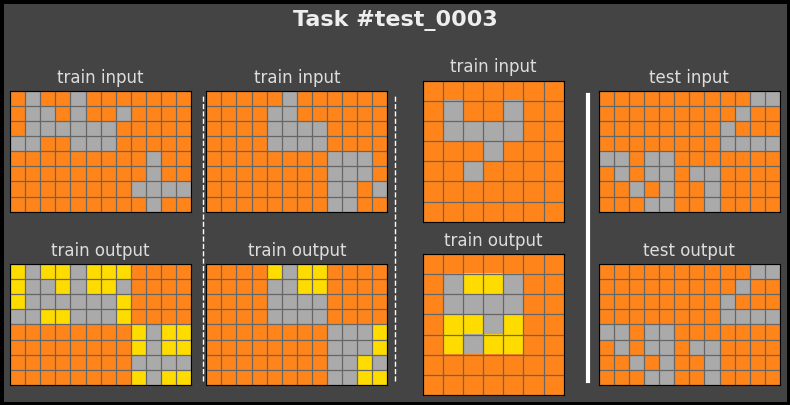

In [38]:
solution = {
    f"{task_id}": pred
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Submission

In [39]:
test_out_rows_sorted = test_out_rows.sort_values(by="n_rows", ascending=False)
test_out_rows_sorted

ID_  n_rows
161  test_0161      30
36   test_0036      30
22   test_0022      30
74   test_0074      30
167  test_0167      30
..         ...     ...
143  test_0143       2
54   test_0054       2
108  test_0108       2
169  test_0169       1
135  test_0135       1

[185 rows x 2 columns]

In [53]:
%%time

test_preds = []

for idx, row in tqdm(test_out_rows_sorted.iterrows(), total=len(test_out_rows_sorted)):
    
    task = test_data[row.ID_]
    train = task["train"]
    test = task["test"][0]

    pred = model.solve(
        task=task, 
        expected_rows=row.n_rows,
        verbose=False
    )  

    test_preds.append(pred)


  0%|          | 0/185 [00:00<?, ?it/s]

CPU times: user 5.26 ms, sys: 806 μs, total: 6.06 ms
Wall time: 5.41 ms


In [54]:
def sort_K(id_str):
    match = re.match(r"(.*)_(\d+)$", id_str)
    if match:
        task_id, row_num = match.groups()
        return (task_id, int(row_num))
    return (id_str, 0)  # fallback

def generate_submission(
    test_data,
    predictions, 
    expected_rows_list: pd.DataFrame, 
    output_path="submission.csv",
    fill_value=Config.DEFAULT_BG_VALUE
):
    """
    Generates a CSV submission file by solving all test tasks.
    Pads missing rows and sorts by ID before saving.
    """
    assert len(predictions) == len(expected_rows_list), "Mismatch between tasks and expected row counts"

    submission_rows = []
    test_keys = expected_rows_list.ID_.tolist()

    for idx, task_id in enumerate(test_keys):
        expected_rows = expected_rows_list.n_rows.iloc[idx]
        pred = predictions[idx]

        n_cols = len(pred[0]) if pred else expected_rows  # avoid crash on empty predictions

        # Pad missing rows if needed
        while len(pred) < expected_rows:
            pred.append([fill_value] * n_cols)

        # Add to submission
        for row_idx, row in enumerate(pred):
            row_str = "".join(str(cell) for cell in row)
            submission_rows.append((f"{task_id}_{row_idx+1}", row_str))

    # Sort by ID (lexical order)
    submission_rows.sort(key=lambda x: sort_K(x[0]))

    # Write to CSV
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "row"])
        writer.writerows(submission_rows)

    print(f"Submission saved to {output_path}")

In [55]:
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}.csv"
out_path = osp.join("..", Config.submission_path, sub_filename)

generate_submission(
    predictions=test_preds, 
    test_data=test_data, 
    expected_rows_list=test_out_rows_sorted, 
    output_path=out_path
)

Submission saved to ../../submissions/2025-08-01_22-08-submission-baseline-cp-simple-arc-solver.csv


In [56]:
submision = pd.read_csv(out_path)
submision

ID                  row
0      test_0000_1           7777777777
1      test_0000_2           7557775557
2      test_0000_3           7757777757
3      test_0000_4           7577777577
4      test_0000_5           7555775555
...            ...                  ...
2298   test_0184_6  7787533335333777777
2299   test_0184_7  7787537775783777777
2300   test_0184_8  7787537775783777777
2301   test_0184_9  7787555555783777777
2302  test_0184_10  7787737777783777777

[2303 rows x 2 columns]

In [57]:
submision.shape == ss.shape, sum(submision.ID == ss.ID)/ss.shape[0]

(True, 1.0)

In [58]:
predictions = reconstruct_grids(submision)

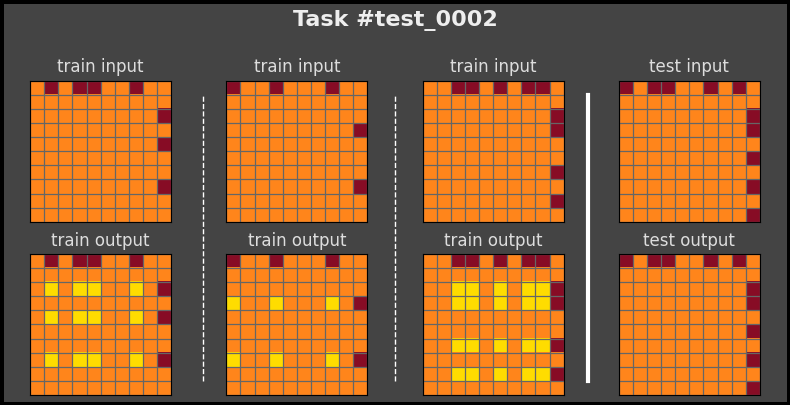

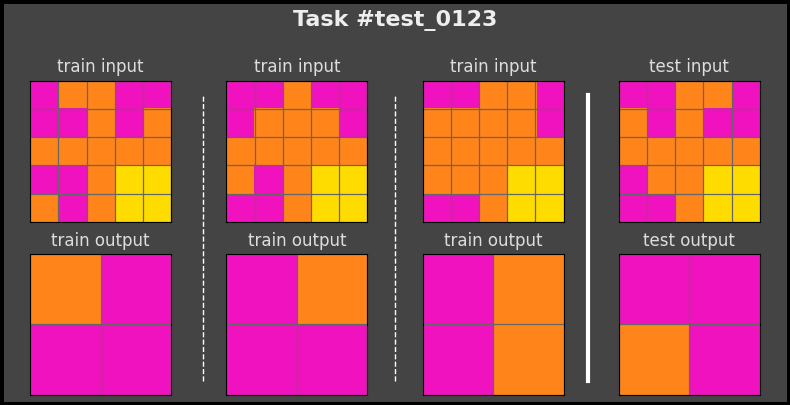

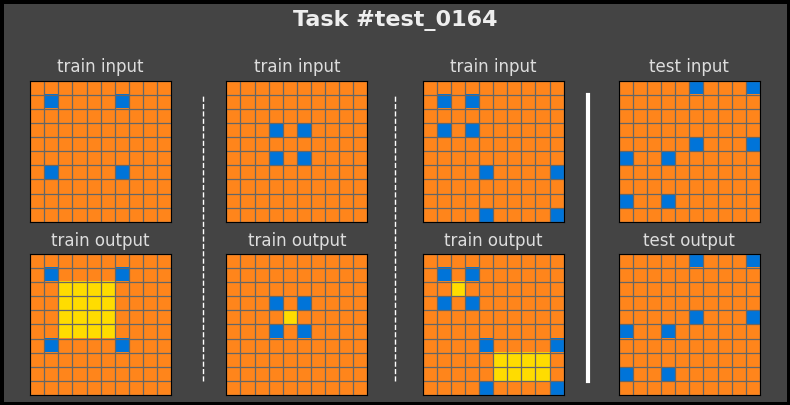

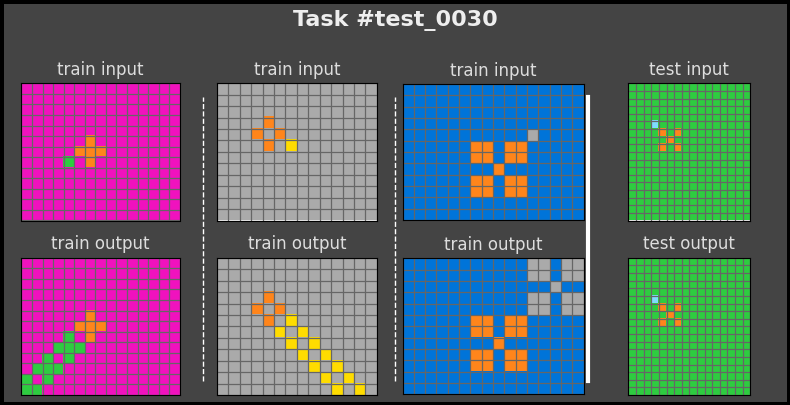

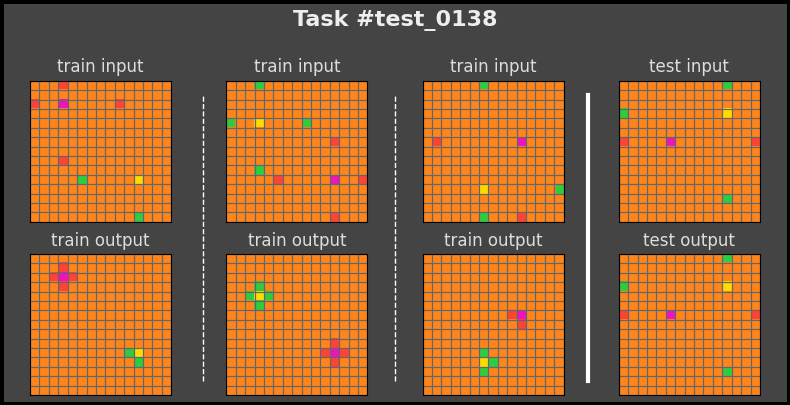

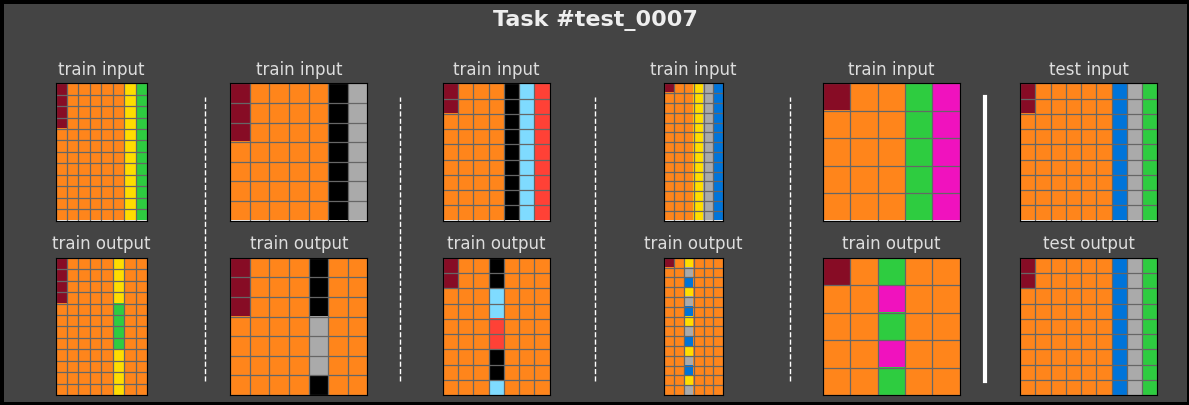

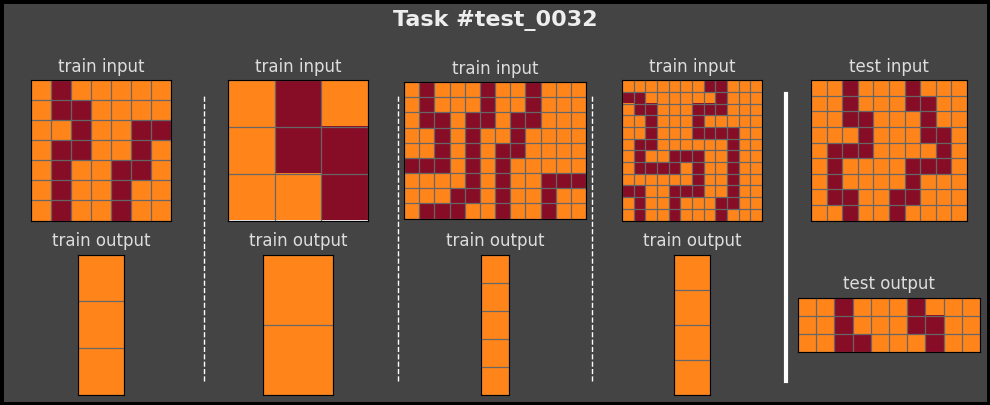

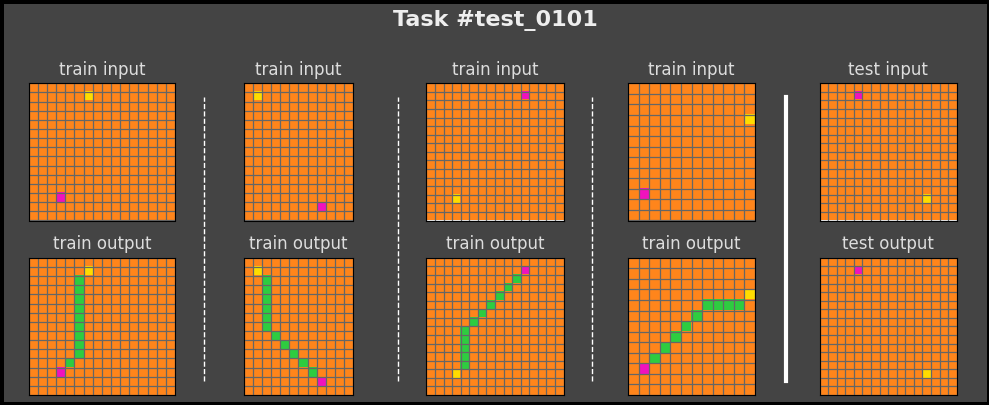

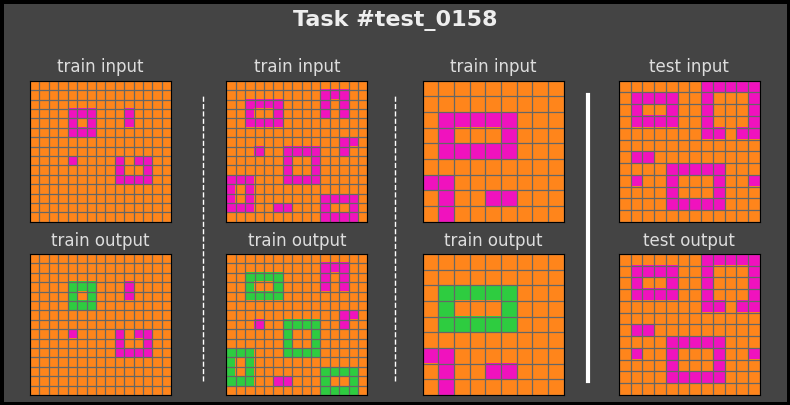

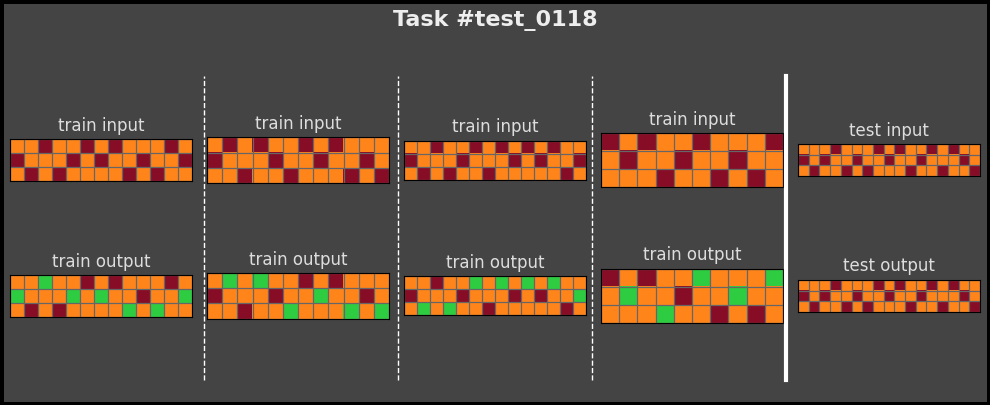

In [59]:
for i in range(10):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)